<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

## Intro: Problem Statement

<div class="container">
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

## 1.0 Libraries

In [1]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

In [3]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [4]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 Loading and Preprocessing Data


In [5]:
df_subm = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv", index_col=0)

validation = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old_all_ext.csv")
train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new_all_ext.csv")
test = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc_all_ext.csv")

In [6]:
#df_train_old.isna().sum()

In [7]:
train.shape, test.shape, validation.shape

((2190, 31), (730, 30), (365, 31))

In [8]:
df_all_new = pd.concat([train, test], axis=0)
print(df_all_new.shape)
df_all_new.head(3)

(2920, 31)


,pressure,temparature,dewpoint,humidity,cloud,sunshine,windspeed,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,cloud_sunshine,rolling_cloud_mean,rolling_humidity_mean,cloud_ratio,humidity_ratio,mean,std,rainfall
0,0.654955,-0.629296,-0.183091,0.638922,0.692700,-0.745242,-0.460377,0.266192,0.404027,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.103102,0.994671,0.137279,0.990532,-1.885535,-1.201297,-1.147765,0.202762,-0.667113,1.179413,1.133104,-0.012575,-0.002483,-0.663821,-0.432092,1.0
1,1.019030,-1.329863,-0.924418,1.616306,0.853347,-1.044309,0.013515,0.627866,0.523115,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,-2.468657,-1.047000,-1.714207,1.785597,-1.143049,1.316221,2.001867,0.056245,0.489094,-0.509969,1.260600,1.0
2,1.816533,-1.481337,-2.054941,-0.827153,-1.502805,1.212287,-0.369632,0.107086,0.537809,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,0.382156,1.678918,-1.102818,-1.006968,0.774952,0.024150,0.843517,-1.556966,-1.394965,-1.414627,0.788521,1.0


In [9]:
df_all_new.tail(3)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,windspeed,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,cloud_sunshine,rolling_cloud_mean,rolling_humidity_mean,cloud_ratio,humidity_ratio,mean,std,rainfall
727,1.573820,-1.026915,-0.905885,1.249787,1.121091,-1.044309,0.013515,0.627866,0.523115,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-2.051045e-01,0.978740,-2.719582e-01,0.962309,-0.136173,-0.275514,1.099351,1.826335,-1.143049,1.361823,1.288241,0.261176,0.543936,1.075949,0.195290,NaN
728,0.134842,-0.742902,-0.108959,1.494133,0.960444,-1.044309,1.788088,1.374918,1.376816,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.372788e-01,0.990532,-1.885537,-1.715621,-1.049108,1.789645,-1.143049,1.387882,1.877758,0.110873,0.439198,0.778698,1.009724,NaN
729,1.261754,-0.970113,-1.313614,-0.338461,0.746249,-0.989933,2.907279,1.368967,2.235567,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-7.347881e-16,1.000000,-1.469576e-15,1.000000,-1.959435e-15,1.000000,0.641322,1.010296,1.462053,1.115856,-1.055532,1.453028,1.691595,-0.102823,-1.322370,1.730059,1.154792,NaN


In [10]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 21

test_final = df_all_new.iloc[2190-past+1:,:]

In [11]:
# Train data
x_train = train.iloc[:,:-1].values
y_train = train.iloc[past-1:,-1].values.reshape(-1,1)
print(x_train.shape, y_train.shape)
# Valid Data
x_valid = validation.iloc[:,:-1].values
y_valid = validation.iloc[past-1:,-1].values.reshape(-1,1)
print(x_valid.shape, y_valid.shape)
# Test Data
x_test = test_final.iloc[:,:-1].values
y_test = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test.shape, y_test.shape)

(2190, 30) (2184, 1)
(365, 30) (359, 1)
(736, 30) (730, 1)


## 3.0 Dataset Management Functions

## Version 0

####  **3.1 Train Dataset**

In [12]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2184, 7, 30)
Target shape: (2184, 1)


In [13]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [14]:
indices_of_zeros.shape,indices_of_ones.shape

((539,), (1645,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [15]:
pos_features = inputs.numpy()[indices_of_ones]
neg_features = inputs.numpy()[indices_of_zeros]

pos_labels = targets.numpy()[indices_of_ones]
neg_labels = targets.numpy()[indices_of_zeros]

pos_features.shape,pos_labels.shape,neg_features.shape,neg_labels.shape

((1645, 7, 30), (1645, 1), (539, 7, 30), (539, 1))

In [16]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [17]:
for num, (features, label) in enumerate(pos_ds.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy())

Label sample 0:  [1]
Label sample 1:  [1]
Label sample 2:  [1]
Label sample 3:  [1]
Label sample 4:  [1]
Label sample 5:  [1]
Label sample 6:  [1]
Label sample 7:  [1]
Label sample 8:  [1]
Label sample 9:  [1]


In [18]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(64).prefetch(2)

In [19]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4375


#### **3.2 Validation Dataset**

In [20]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [21]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


## Version 1

In [22]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10_000,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs_val, targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (359, 7, 30)
Target shape: (359, 1)


In [23]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs_tr, targets_tr = batch

print("Input shape:", inputs_tr.numpy().shape)
print("Target shape:", targets_tr.numpy().shape)

Input shape: (2184, 7, 30)
Target shape: (2184, 1)


In [24]:
# Merge the arrays along the first axis
all_train = np.concatenate((inputs_val, inputs_tr), axis=0)
all_target = np.concatenate((targets_val, targets_tr), axis=0)
all_train.shape, all_target.shape

((2543, 7, 30), (2543, 1))

In [25]:
all_train.shape[0]-365, all_train.shape

(2178, (2543, 7, 30))

In [26]:
# Train data
x_train_v1 = all_train[:2178,:,:]
y_train_v1 = all_target[:2178,:]
print(x_train_v1.shape, y_train_v1.shape)
# Valid Data
x_valid_v1 = all_train[2178:,:,:]
y_valid_v1 = all_target[2178:,:]
print(x_valid_v1.shape, y_valid_v1.shape)
# Test Data
x_test_v1 = test_final.iloc[:,:-1].values
y_test_v1 = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test_v1.shape, y_test_v1.shape)

(2178, 7, 30) (2178, 1)
(365, 7, 30) (365, 1)
(736, 30) (730, 1)


####  **3.1 Train Dataset**

In [27]:
dataset_train_v1 = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train_v1,
                                                                    y_train_v1,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train_v1.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2172, 7, 7, 30)
Target shape: (2172, 1)


In [28]:
# Convert numpy arrays to TensorFlow datasets
feature_dataset = tf.data.Dataset.from_tensor_slices(x_train_v1)
target_dataset = tf.data.Dataset.from_tensor_slices(y_train_v1)

# Combine features and target into a single dataset
dataset_tr = tf.data.Dataset.zip((feature_dataset, target_dataset))

# Shuffle and batch the dataset
dataset_train_v1 = dataset_tr.shuffle(buffer_size=len(x_train_v1)).batch(10000)


for batch in dataset_train_v1.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2178, 7, 30)
Target shape: (2178, 1)


In [29]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [30]:
indices_of_zeros.shape,indices_of_ones.shape

((566,), (1612,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [31]:
pos_features_v1 = inputs.numpy()[indices_of_ones]
neg_features_v1 = inputs.numpy()[indices_of_zeros]

pos_labels_v1 = targets.numpy()[indices_of_ones]
neg_labels_v1 = targets.numpy()[indices_of_zeros]

pos_features_v1.shape,pos_labels_v1.shape,neg_features_v1.shape,neg_labels_v1.shape

((1612, 7, 30), (1612, 1), (566, 7, 30), (566, 1))

In [32]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds_v1 = make_ds(pos_features_v1, pos_labels_v1)
neg_ds_v1 = make_ds(neg_features_v1, neg_labels_v1)

In [33]:
for num, (features, label) in enumerate(pos_ds_v1.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy(), features.shape)

Label sample 0:  [1] (7, 30)
Label sample 1:  [1] (7, 30)
Label sample 2:  [1] (7, 30)
Label sample 3:  [1] (7, 30)
Label sample 4:  [1] (7, 30)
Label sample 5:  [1] (7, 30)
Label sample 6:  [1] (7, 30)
Label sample 7:  [1] (7, 30)
Label sample 8:  [1] (7, 30)
Label sample 9:  [1] (7, 30)


In [34]:
resampled_ds_v1 = tf.data.Dataset.sample_from_datasets([pos_ds_v1, neg_ds_v1], weights=[0.5, 0.5])
resampled_ds_v1 = resampled_ds_v1.batch(64).prefetch(2)

In [35]:
for features, label in resampled_ds_v1.take(1):
  print(label.shape,label.numpy().mean())

(64, 1) 0.5625


In [36]:
x_valid_v1.shape, y_valid_v1.shape, x_valid.shape, y_valid.shape

((365, 7, 30), (365, 1), (365, 30), (359, 1))

#### **3.2 Validation Dataset**

In [37]:
feature_dataset = tf.data.Dataset.from_tensor_slices(x_valid_v1)
target_dataset = tf.data.Dataset.from_tensor_slices(y_valid_v1)

# Combine features and target into a single dataset
dataset_validation_v1 = tf.data.Dataset.zip((feature_dataset, target_dataset))

# Shuffle and batch the dataset
dataset_validation_v1 = dataset_validation_v1.batch(64).prefetch(2)

for batch in dataset_validation_v1.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [38]:
dataset_test_v1 = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test_v1.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 30)
Target shape: (64, 1)


## 4.0 NN Models:

In [39]:
def plot_metrics(history):
  metrics = ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [40]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 101

In [41]:
METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

### 4.1 LSTM v0

In [ ]:
def make_model(metrics=METRICS, units=[32,32], output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_noised = keras.layers.GaussianNoise(stddev=0.05, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0")(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(lstm_out)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,64])

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

#### Fit the model

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_v2_all_data.csv")

### 4.2 LSTM-Tab v0

In [ ]:
def make_model(metrics=METRICS, units=[32,32],units_tab=[64,32], output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",)(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)

  # Tabular Section
  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Concatenate
  x = keras.layers.Concatenate(name="concat")([lstm_out, tabx,data_tabular])
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_tab_v1")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32],output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

#### Optuna Optimization

##### Optimization 00

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=make_model, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

 * Trial 21 finished with value: 0.8943167305236271
    * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.30781160547467370}.

 * Trial 41 finished with value: 0.8956648219100326
    * parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.09, 'do': 0.25}.

* Best is trial 25 with value: 0.8865119909181212.
    * {'units_0': 64,
 'units_1': 32,
 'units_tab_0': 256,
 'units_tab_1': 128,
 'activation': 'selu',
 'gn': 0.08,
 'do': 0.32}


##### Optimization 01

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu","mish"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid_v1, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds_v1,validation_data=dataset_validation_v1, model_class=make_model, n_trials=111, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

#### Fit the model

##### Model 00

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model(units=[64,64], units_tab=[128,32], activation="gelu", gn=0.09, do=0.39, output_bias=0) # Model v3 (best 0.86323)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

In [ ]:
plot_metrics(resampled_history)

##### Model 01

In [ ]:
model_cv1= make_model(units=[128,64], units_tab=[128,128], activation="mish", gn=0.09, do=0.24, output_bias=0)

resampled_history_v1 = model_cv1.fit(
                              resampled_ds_v1,
                              epochs=201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3,  factor=0.5, monitor="val_auc", mode="max", min_lr=0.000001, verbose=1),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max", verbose=1)],
                              validation_data=dataset_validation_v1
                              )

model_cv1.evaluate(dataset_validation_v1)

In [ ]:
plot_metrics(resampled_history_v1)

#### Evaluate Model:

In [ ]:
train_predictions_resampled_v0 = model.predict(dataset_train)
valid_predictions_resampled_v0 = model.predict(dataset_validation)
test_predictions_resampled_v0 = model.predict(dataset_test)

In [ ]:
train_predictions_resampled_v1 = model_cv1.predict(dataset_train)
valid_predictions_resampled_v1 = model_cv1.predict(dataset_validation)
test_predictions_resampled_v1 = model_cv1.predict(dataset_test)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
plt.scatter(test_predictions_resampled_v0,test_predictions_resampled_v1)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled_v0
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v4_all_data_ext_v0.csv")
df_subm["rainfall"] = test_predictions_resampled_v1
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v4_all_data_ext_v1.csv")
df_subm["rainfall"] = (test_predictions_resampled_v0+test_predictions_resampled_v1)/2
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v4_all_data_ext_average.csv")
df_subm

In [ ]:
#plot_cm(y_valid_v1, dataset_validation_v1)
test_predictions_resampled_cv0.shape, test_predictions_resampled_cv1.shape

In [ ]:
df_subm["rainfall"] = (test_predictions_resampled_cv0+test_predictions_resampled_cv1)/2
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_enhanced_v0_all_data_ext.csv")
df_subm

### 4.3 LSTM-Tab with Transformer v0

In [ ]:
inputs.shape

In [ ]:
def make_model(metrics=METRICS, units=[32,32],units_tab=[64,32], output_bias=None, gn=0.025, activation="relu", do=0.3, lr=5e-4):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  whole_seq_output, final_memory_state_0, final_carry_state_0 = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",return_state=True)(data_noised)
  whole_seq_output, final_memory_state_1, final_carry_state_1 = keras.layers.LSTM(units[1], name="lstm_1",return_state=True)(whole_seq_output)

  # print(final_memory_state_0.shape, final_carry_state_0.shape)
  # print(final_memory_state_1.shape, final_carry_state_1.shape)

  # Tabular Section
  data_tabular = keras.layers.Concatenate(name="concat_states")([data_tabular,final_memory_state_0,final_carry_state_0,final_memory_state_1,final_carry_state_1])

  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Concatenate
  x = keras.layers.Concatenate(name="concat")([whole_seq_output, tabx,data_tabular])
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_tab_v2")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32],output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

In [ ]:
#plot_model(model, show_shapes=True)

#### Optuna Optimization

##### Optimization 00

In [54]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False, epochs=101):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","mish","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [55]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [56]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-13 00:54:25,266] A new study created in memory with name: no-name-9fc050f3-97b7-4995-9abc-d91bfe38b615
[W 2025-03-13 00:54:25,285] Trial 0 failed with parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'mish', 'gn': 0.02, 'do': 0.33} because of the following error: TypeError("make_model() got an unexpected keyword argument 'units_tab'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-55-2887cb97a03e>", line 4, in <lambda>
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-54-3c

TypeError: make_model() got an unexpected keyword argument 'units_tab'

 * Trial 85 finished with value: 0.8963743436923514
    * parameters: {'units_0': 64, 'units_1': 32,  'units_tab_0': 128, 'units_tab_1': 32,
 'activation': 'selu', 'gn': 0.1, 'do': 0.44}


  * Trial 69 with value: 0.8962679154250035
    * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64,
 'activation': 'gelu', 'gn': 0.05, 'do': 0.32}

##### Optimization 01

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False, epochs=101):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","mish","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid_v1, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds_v1,validation_data=dataset_validation_v1, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

 * Trial 91 with value: 0.902684004334417
    * parameters: {'units_0': 128,
 'units_1': 64,
 'units_tab_0': 256,
 'units_tab_1': 64,
 'activation': 'mish',
 'gn': 0.09,
 'do': 0.2}

#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
# MODEL 00 'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.05, 'do': 0.32
model= make_model(units=[64,32], units_tab=[128,32], activation="selu", gn=0.10, do=0.44, output_bias=0) # Model v3 (best 0.86323)
model= make_model(units=[64,64], units_tab=[64,64], activation="gelu", gn=0.05, do=0.32, output_bias=0) # Model v3 (best 0.86323)
# MODEL 01
model= make_model(units=[128,64], units_tab=[256,64], activation="mish", gn=0.09, do=0.20, output_bias=0) # Model v3 (best 0.86323)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
model_cv0= make_model(units=[64,64], units_tab=[64,64], activation="gelu", gn=0.05, do=0.32, output_bias=0) # Model v3 (best 0.86323)

resampled_history_v0 = model_cv0.fit(
                              resampled_ds,
                              epochs=201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", mode="max", min_lr=0.000001, verbose=1),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max", verbose=1)],
                              validation_data=dataset_validation
                              )

model_cv0.evaluate(dataset_validation)

In [ ]:
plot_metrics(resampled_history_v0)

In [ ]:
model_cv1= make_model(units=[128,64], units_tab=[256,64], activation="mish", gn=0.09, do=0.20, output_bias=0, lr=5e-4) # Model v3 (best 0.86323)

resampled_history_v1 = model_cv1.fit(
                              resampled_ds_v1,
                              epochs=201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3,  factor=0.5, monitor="val_auc", mode="max", min_lr=0.000001, verbose=1),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max", verbose=1)],
                              validation_data=dataset_validation_v1
                              )

model_cv1.evaluate(dataset_validation_v1)

In [ ]:
plot_metrics(resampled_history_v1)

#### Evaluate Model:

In [ ]:
train_predictions_resampled_cv0 = model_cv0.predict(dataset_train)
valid_predictions_resampled_cv0 = model_cv0.predict(dataset_validation)
test_predictions_resampled_cv0 = model_cv0.predict(dataset_test)

In [ ]:
train_predictions_resampled_cv1 = model_cv1.predict(dataset_train_v1)
valid_predictions_resampled_cv1 = model_cv1.predict(dataset_validation_v1)
test_predictions_resampled_cv1 = model_cv1.predict(dataset_test_v1)

In [ ]:
plt.scatter(test_predictions_resampled_cv0,test_predictions_resampled_cv1)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled_cv0)

In [ ]:
#plot_cm(y_valid_v1, dataset_validation_v1)
test_predictions_resampled_cv0.shape, test_predictions_resampled_cv1.shape

In [ ]:
df_subm["rainfall"] = (test_predictions_resampled_cv0+test_predictions_resampled_cv1)/2
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_enhanced_v0_all_data_ext.csv")
df_subm

### 4.3 CNN Classifier

In [ ]:
def make_model_cnn(metrics=METRICS, filters=64, kernel_size=2, kr=0.01, sdo=0.2,
               units_dense=256, output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")

  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  # Cnn Layers
  # Layer 0
  cnn_out = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_0")(data_noised)
  cnn_out = keras.layers.LayerNormalization(name="ln_0")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_0")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_0")(cnn_out)
  cnn_out = keras.layers.MaxPooling1D(pool_size=2, name="max_pool_1")(cnn_out)
  # Layer 1
  cnn_out = keras.layers.Conv1D(filters=int(filters*2), kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_1")(cnn_out)
  cnn_out = keras.layers.LayerNormalization(name="ln_1")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_1")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_1")(cnn_out)

  #outputs
  cnn_out_ave = keras.layers.GlobalAveragePooling1D(name="average_pool_final")(cnn_out)
  cnn_out_max = keras.layers.GlobalMaxPooling1D(name="max_pool_final")(cnn_out)

  x = keras.layers.Concatenate(name="concat")([cnn_out_ave, cnn_out_max])

  # Dense Layer
  x = keras.layers.Dense(units_dense, name="dense_1")(x)
  x = keras.layers.BatchNormalization(name="batch_dense")(x)
  x = keras.layers.Activation(activation, name="act_dense")(x)
  x = keras.layers.Dropout(do, name="do_dense")(x)

  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="cnn_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=5e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model_cnn(output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

#### Optuna Optimization

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model_cnn, use_gpu=False, rs=42, fit_scaling=False, epochs=21):

    model_class = model

    params = {
              'filters': trial.suggest_categorical('filters', [16,32,64]),
              'kernel_size': trial.suggest_categorical('kernel_size', [2,3]),
              'units_dense': trial.suggest_categorical('units_dense', [256, 128, 64]),
              'sdo': trial.suggest_float('sdo', 0.20, 0.45, step=0.01),
              'kr': trial.suggest_float('kr', 0.01, 0.1, step=0.01),
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=9, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=make_model_cnn, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model_cnn, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

*  Best is trial 66 with value: 0.895310061
    * {'filters': 64,
 'kernel_size': 2,
 'units_dense': 256,
 'do': 0.39,
 'sdo': 0.39,
 'kr': 0.09999999999999999,
 'activation': 'gelu',
 'gn': 0.09999999999999999}


#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model_cnn(**{'filters': 64, 'kernel_size': 2, 'units_dense': 256, 'do': 0.39, 'sdo': 0.39, 'kr': 0.1, 'activation': 'gelu', 'gn': 0.1}) # Model v

model.summary()

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=2201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=101, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_v2_all_data_ext.csv")

### 4.4 CNN Classifier - Tab v0

In [ ]:
def make_model_cnn(metrics=METRICS, filters=64, kernel_size=2, kr=0.01, sdo=0.2,
                   units_dense=256, output_bias=None, gn=0.025, activation="relu",
                   do=0.3, units_tab=[128,128], lr=5e-4):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]

  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  # Cnn Layers
  # Layer 0
  cnn_out = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_0")(data_noised)
  cnn_out = keras.layers.LayerNormalization(name="ln_cnn_0")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_cnn_0")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_cnn_0")(cnn_out)
  cnn_out = keras.layers.MaxPooling1D(pool_size=2, name="max_pool_cnn_1")(cnn_out)
  # Layer 1
  cnn_out = keras.layers.Conv1D(filters=int(filters*2), kernel_size=kernel_size, strides=1,
                                kernel_regularizer=keras.regularizers.l2(kr),
                                padding="same", activation=None, name="cnn_1")(cnn_out)
  cnn_out = keras.layers.LayerNormalization(name="ln_cnn_1")(cnn_out)
  cnn_out = keras.layers.Activation("relu", name="act_cnn_1")(cnn_out)
  cnn_out = keras.layers.SpatialDropout1D(sdo, name="sdo_cnn_1")(cnn_out)

  #outputs
  cnn_out_ave = keras.layers.GlobalAveragePooling1D(name="average_pool_final")(cnn_out)
  cnn_out_max = keras.layers.GlobalMaxPooling1D(name="max_pool_final")(cnn_out)

  x = keras.layers.Concatenate(name="concat")([cnn_out_ave, cnn_out_max])

  # Dense Layer
  x = keras.layers.Dense(units_dense, name="dense_conv_1")(x)
  x = keras.layers.BatchNormalization(name="batch_dense_conv")(x)
  x = keras.layers.Activation(activation, name="act_dense_conv")(x)
  x = keras.layers.Dropout(do, name="do_dense_conv")(x)

  # Tabular Section
  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Final Concatenation
  x = keras.layers.Concatenate(name="final_concat")([x, tabx])

  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="cnn_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model_cnn(output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

#### Optuna Optimization

In [ ]:
def objective_nn(trial, train_data, validation_data, model=make_model_cnn, use_gpu=False, rs=42, fit_scaling=False,epochs=51):

    model_class = model

    params = {
              'filters': trial.suggest_categorical('filters', [32,64,128]),
              'kernel_size': trial.suggest_categorical('kernel_size', [2,3]),
              'units_dense': trial.suggest_categorical('units_dense', [256, 128, 64]),
              'sdo': trial.suggest_float('sdo', 0.20, 0.45, step=0.01),
              'kr': trial.suggest_float('kr', 0.01, 0.1, step=0.01),
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01),
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model_cnn, n_trials=151, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

 * Best is trial 119 with value: 0.9003476656733361.
    * parameters: {'filters': 32,
 'kernel_size': 3,
 'units_dense': 256,
 'do': 0.26,
 'sdo': 0.26,
 'kr': 0.08,
 'activation': 'relu',
 'gn': 0.03,
 'units_tab_0': 128,
 'units_tab_1': 64}.


 * Best is trial 129 with value: 0.897686958989641.
    * parameters: {'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'sdo': 0.22, 'kr': 0.05, 'activation': 'selu', 'gn': 0.06, 'do': 0.2, 'units_tab_0': 128, 'units_tab_1': 64}


#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
model= make_model_cnn(lr=5e-4, **{'filters': 32, 'kernel_size': 3, 'units_dense': 256, 'do': 0.26, 'sdo': 0.26, 'kr': 0.08, 'activation': 'relu', 'gn': 0.03, "units_tab":[128, 64]}) # auc: 0.8876
model= make_model_cnn(lr=5e-4, **{'filters': 64, 'kernel_size': 3, 'units_dense': 64, 'do': 0.20, 'sdo': 0.22, 'kr': 0.05, 'activation': 'relu', 'gn': 0.06, "units_tab":[128, 64]}) # auc: 0.8853


model.summary()

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

In [ ]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=151,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", min_lr=0.00001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

In [ ]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [ ]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

In [ ]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_tab_v1_all_data_ext.csv")

### 4.5 Temporal Transformer

In [42]:
num_samples = 5000
sequence_length = 7
num_features = 30
embed_dim = num_features
head_size = 32
num_heads = 4
gru_units = 64
dropout = 0.1

# 2. Positional Embedding Layer
class TimeSeriesPositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

# 3. Transformer Encoder Layer with GRU
def transformer_encoder_gru(inputs, head_size, num_heads, gru_units, embed_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part (GRU)
    x = keras.layers.GRU(units=gru_units, return_sequences=True)(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(units=embed_dim)(x) # Added Dense Layer
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [43]:
def make_model(metrics=METRICS, units=[32,32], output_bias=None, gn=0.025, activation="relu", do=0.3, num_transformer_layers=2,
               head_size=32, num_heads=4, gru_units=64):
  """
  Builds a transformer-based binary classification model for time series data.

  Args:
      input_shape: Tuple, the shape of the input data (sequence_length, num_features).
      num_transformer_layers: Integer, the number of transformer encoder layers to stack.
      head_size: Integer, the size of each attention head.
      num_heads: Integer, the number of attention heads.
      gru_units: Integer, the number of GRU units in the feed-forward part.
      dropout: Float, the dropout rate.

  Returns:
      A Keras model.
  """

  tot_obs, sequence_length, num_features = inputs.shape
  embed_dim = inputs.shape[2]

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",)(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)
  lstm_out = keras.layers.Dropout(do)(lstm_out)

  # Tabular Section

  x = TimeSeriesPositionalEmbedding(sequence_length, embed_dim)(data)

  # Stack Transformer Layers
  for _ in range(num_transformer_layers):
      x = transformer_encoder_gru(x, head_size, num_heads, gru_units, embed_dim, dropout)

  # Global Pooling and Output Layer
  x_av = keras.layers.GlobalAveragePooling1D()(x)
  x_av = keras.layers.Dropout(do)(x_av)
  # Max Pooling and Output Layer
  x_mx = keras.layers.GlobalMaxPooling1D()(x)
  x_mx = keras.layers.Dropout(do)(x_mx)


  # Concatenate
  x = keras.layers.Concatenate(name="concat")([lstm_out, x_av,x_mx])

  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="temp_trans_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "temp_trans_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 30)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_series_positional_e… │ (None, 7, 30)          │            210 │ input_layer[0][0]      │
│ (TimeSeriesPositionalEmb… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 7, 30)          │         15,774 │ time_series_positiona… │
│ (MultiHeadAttention)      │                        │                │ time_series_positiona… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 7, 30)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 7, 30)          │             60 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 7, 30)          │              0 │ layer_normalization[0… │
│                           │                        │                │ time_series_positiona… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 7, 64)          │         18,432 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 7, 64)          │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7, 30)          │          1,950 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 7, 30)          │             60 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 7, 30)          │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 7, 30)          │         15,774 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 7, 30)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 7, 30)          │             60 │ dropout_5[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 7, 30)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├──────────────────────

 Total params: 89,239 (348.59 KB)

 Trainable params: 89,239 (348.59 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#plot_model(model, show_shapes=True)

#### Optuna Optimization

##### Optimization 00

In [58]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False, epochs=101):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'output_bias':0,
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.15, 0.45, step=0.01),
              'num_transformer_layers': trial.suggest_categorical('num_transformer_layers', [2,3]),
              'head_size': trial.suggest_categorical('head_size', [32,64]),
              'num_heads': trial.suggest_categorical('num_heads', [4,8,16]),
              'gru_units': trial.suggest_categorical('gru_units', [32,64,128])
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=101,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, verbose=1, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [59]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [60]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-13 00:55:15,037] A new study created in memory with name: no-name-11eb644c-760b-4155-b43e-711580c0200c


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - auc: 0.6393 - cross entropy: 0.9404 - loss: 0.9404 - prc: 0.6165 - val_auc: 0.7742 - val_cross entropy: 0.5842 - val_loss: 0.5842 - val_prc: 0.8588 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7238 - cross entropy: 0.6611 - loss: 0.6611 - prc: 0.7154 - val_auc: 0.7948 - val_cross entropy: 0.5372 - val_loss: 0.5372 - val_prc: 0.8672 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7949 - cross entropy: 0.5607 - loss: 0.5607 - prc: 0.7844 - val_auc: 0.8492 - val_cross entropy: 0.5247 - val_loss: 0.5247 - val_prc: 0.9034 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8708 - cross entropy: 0.4556 - loss: 0.4556 - prc: 0.8467 - val_auc: 0.8690 - val_cross entropy: 0.4989 - val_loss: 0.4989 - val_prc: 0.9246 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8947 - cross entropy: 0.4105 - lo

[I 2025-03-13 00:57:27,329] Trial 0 finished with value: 0.8734213140343409 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.08, 'do': 0.39, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 0 with value: 0.8734213140343409.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - auc: 0.7081 - cross entropy: 0.7589 - loss: 0.8247 - prc: 0.7375 - val_auc: 0.7586 - val_cross entropy: 0.7087 - val_loss: 0.7087 - val_prc: 0.8260 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7431 - cross entropy: 0.6339 - loss: 0.6339 - prc: 0.7171 - val_auc: 0.7979 - val_cross entropy: 0.5512 - val_loss: 0.5512 - val_prc: 0.8448 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.7989 - cross entropy: 0.5502 - loss: 0.5502 - prc: 0.8091 - val_auc: 0.8388 - val_cross entropy: 0.5091 - val_loss: 0.5091 - val_prc: 0.8823 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8676 - cross entropy: 0.4559 - loss: 0.4559 - prc: 0.8520 - val_auc: 0.8661 - val_cross entropy: 0.5110 - val_loss: 0.5110 - val_prc: 0.9151 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9085 - cross entropy: 0.3831 - los

[I 2025-03-13 00:58:42,972] Trial 1 finished with value: 0.8701575138356747 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 0 with value: 0.8734213140343409.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - auc: 0.7081 - cross entropy: 0.8576 - loss: 0.9499 - prc: 0.7321 - val_auc: 0.7482 - val_cross entropy: 0.6083 - val_loss: 0.6083 - val_prc: 0.8097 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.7168 - cross entropy: 0.6568 - loss: 0.6568 - prc: 0.7080 - val_auc: 0.7842 - val_cross entropy: 0.5489 - val_loss: 0.5489 - val_prc: 0.8312 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.7659 - cross entropy: 0.5917 - loss: 0.5917 - prc: 0.7668 - val_auc: 0.8143 - val_cross entropy: 0.4928 - val_loss: 0.4928 - val_prc: 0.8592 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8320 - cross entropy: 0.5079 - loss: 0.5079 - prc: 0.8107 - val_auc: 0.8509 - val_cross entropy: 0.4664 - val_loss: 0.4664 - val_prc: 0.9029 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.8823 - cross entropy: 0.4298 - los

[I 2025-03-13 00:59:49,285] Trial 2 finished with value: 0.874982261955442 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.08, 'do': 0.32999999999999996, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 64}. Best is trial 2 with value: 0.874982261955442.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - auc: 0.7053 - cross entropy: 0.7681 - loss: 0.8550 - prc: 0.7428 - val_auc: 0.7479 - val_cross entropy: 0.6618 - val_loss: 0.6618 - val_prc: 0.8034 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7380 - cross entropy: 0.6233 - loss: 0.6233 - prc: 0.7355 - val_auc: 0.7721 - val_cross entropy: 0.5637 - val_loss: 0.5637 - val_prc: 0.8333 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8010 - cross entropy: 0.5429 - loss: 0.5429 - prc: 0.7939 - val_auc: 0.8266 - val_cross entropy: 0.5078 - val_loss: 0.5078 - val_prc: 0.8890 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8804 - cross entropy: 0.4387 - loss: 0.4387 - prc: 0.8596 - val_auc: 0.8660 - val_cross entropy: 0.4593 - val_loss: 0.4593 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9053 - cross entropy: 0.3900 - los

[I 2025-03-13 01:01:33,677] Trial 3 finished with value: 0.8665744288349653 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.01, 'do': 0.18, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 2 with value: 0.874982261955442.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - auc: 0.6899 - cross entropy: 0.8556 - loss: 0.9952 - prc: 0.7182 - val_auc: 0.7627 - val_cross entropy: 0.6268 - val_loss: 0.6268 - val_prc: 0.8174 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7264 - cross entropy: 0.6374 - loss: 0.6374 - prc: 0.7086 - val_auc: 0.7971 - val_cross entropy: 0.6127 - val_loss: 0.6127 - val_prc: 0.8568 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8167 - cross entropy: 0.5307 - loss: 0.5307 - prc: 0.8213 - val_auc: 0.8660 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9223 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8890 - cross entropy: 0.4197 - loss: 0.4197 - prc: 0.8794 - val_auc: 0.8676 - val_cross entropy: 0.4866 - val_loss: 0.4866 - val_prc: 0.9251 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.9062 - cross entropy: 0.3868 - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2025-03-13 01:03:06,726] Trial 4 finished with value: 0.8716829856676599 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 2 with value: 0.874982261955442.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - auc: 0.7192 - cross entropy: 0.7799 - loss: 0.8172 - prc: 0.7427 - val_auc: 0.7341 - val_cross entropy: 0.6989 - val_loss: 0.6989 - val_prc: 0.8206 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7423 - cross entropy: 0.6243 - loss: 0.6243 - prc: 0.7329 - val_auc: 0.7627 - val_cross entropy: 0.6352 - val_loss: 0.6352 - val_prc: 0.8444 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7937 - cross entropy: 0.5592 - loss: 0.5592 - prc: 0.8020 - val_auc: 0.8237 - val_cross entropy: 0.5415 - val_loss: 0.5415 - val_prc: 0.8918 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8468 - cross entropy: 0.4889 - loss: 0.4889 - prc: 0.8286 - val_auc: 0.8655 - val_cross entropy: 0.4521 - val_loss: 0.4521 - val_prc: 0.9246 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8865 - cross entropy: 0.4231 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2025-03-13 01:04:44,423] Trial 5 finished with value: 0.872179650915283 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.19, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 32}. Best is trial 2 with value: 0.874982261955442.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - auc: 0.7083 - cross entropy: 0.8453 - loss: 0.9594 - prc: 0.7282 - val_auc: 0.7638 - val_cross entropy: 0.6295 - val_loss: 0.6295 - val_prc: 0.8429 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7126 - cross entropy: 0.6953 - loss: 0.6953 - prc: 0.7007 - val_auc: 0.7860 - val_cross entropy: 0.5520 - val_loss: 0.5520 - val_prc: 0.8531 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.7817 - cross entropy: 0.5776 - loss: 0.5776 - prc: 0.7785 - val_auc: 0.8437 - val_cross entropy: 0.4728 - val_loss: 0.4728 - val_prc: 0.8922 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8682 - cross entropy: 0.4588 - loss: 0.4588 - prc: 0.8503 - val_auc: 0.8639 - val_cross entropy: 0.5055 - val_loss: 0.5055 - val_prc: 0.9143 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8905 - cross entropy: 0.4208 - lo

[I 2025-03-13 01:06:46,192] Trial 6 finished with value: 0.8718603661132398 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 2 with value: 0.874982261955442.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - auc: 0.6987 - cross entropy: 0.9075 - loss: 1.0464 - prc: 0.7315 - val_auc: 0.7606 - val_cross entropy: 0.6437 - val_loss: 0.6437 - val_prc: 0.8264 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7389 - cross entropy: 0.6350 - loss: 0.6350 - prc: 0.7241 - val_auc: 0.7853 - val_cross entropy: 0.5482 - val_loss: 0.5482 - val_prc: 0.8549 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7596 - cross entropy: 0.5950 - loss: 0.5950 - prc: 0.7626 - val_auc: 0.8088 - val_cross entropy: 0.5880 - val_loss: 0.5880 - val_prc: 0.8721 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8151 - cross entropy: 0.5304 - loss: 0.5304 - prc: 0.8069 - val_auc: 0.8446 - val_cross entropy: 0.5028 - val_loss: 0.5028 - val_prc: 0.9030 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8658 - cross entropy: 0.4625 - los

[I 2025-03-13 01:08:20,033] Trial 7 finished with value: 0.8780332056194126 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.05, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 7 with value: 0.8780332056194126.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - auc: 0.7349 - cross entropy: 0.6857 - loss: 0.7386 - prc: 0.7621 - val_auc: 0.7880 - val_cross entropy: 0.5760 - val_loss: 0.5760 - val_prc: 0.8538 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.7868 - cross entropy: 0.5726 - loss: 0.5726 - prc: 0.7641 - val_auc: 0.8664 - val_cross entropy: 0.4373 - val_loss: 0.4373 - val_prc: 0.9144 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8726 - cross entropy: 0.4474 - loss: 0.4474 - prc: 0.8689 - val_auc: 0.8803 - val_cross entropy: 0.4383 - val_loss: 0.4383 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9129 - cross entropy: 0.3759 - loss: 0.3759 - prc: 0.9097 - val_auc: 0.8883 - val_cross entropy: 0.4217 - val_loss: 0.4217 - val_prc: 0.9402 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.9089 - cross entropy: 0.3826 - los

[I 2025-03-13 01:09:59,543] Trial 8 finished with value: 0.8881793671065702 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.15, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - auc: 0.7183 - cross entropy: 0.8243 - loss: 0.8859 - prc: 0.7452 - val_auc: 0.7718 - val_cross entropy: 0.5620 - val_loss: 0.5620 - val_prc: 0.8315 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.7444 - cross entropy: 0.6110 - loss: 0.6110 - prc: 0.7284 - val_auc: 0.7952 - val_cross entropy: 0.5179 - val_loss: 0.5179 - val_prc: 0.8570 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.7886 - cross entropy: 0.5589 - loss: 0.5589 - prc: 0.7814 - val_auc: 0.8277 - val_cross entropy: 0.5010 - val_loss: 0.5010 - val_prc: 0.8835 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8530 - cross entropy: 0.4775 - loss: 0.4775 - prc: 0.8425 - val_auc: 0.8627 - val_cross entropy: 0.4672 - val_loss: 0.4672 - val_prc: 0.9174 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.8961 - cross entropy: 0.4065 - los

[I 2025-03-13 01:11:28,652] Trial 9 finished with value: 0.8715765574003123 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.08, 'do': 0.24, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - auc: 0.7338 - cross entropy: 0.7310 - loss: 0.7624 - prc: 0.7586 - val_auc: 0.8020 - val_cross entropy: 0.5448 - val_loss: 0.5448 - val_prc: 0.8904 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7815 - cross entropy: 0.5717 - loss: 0.5717 - prc: 0.7634 - val_auc: 0.8641 - val_cross entropy: 0.4767 - val_loss: 0.4767 - val_prc: 0.9195 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8796 - cross entropy: 0.4420 - loss: 0.4420 - prc: 0.8775 - val_auc: 0.8727 - val_cross entropy: 0.4643 - val_loss: 0.4643 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.9002 - cross entropy: 0.4009 - loss: 0.4009 - prc: 0.8988 - val_auc: 0.8755 - val_cross entropy: 0.4889 - val_loss: 0.4889 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9156 - cross entropy: 0.3691 - lo

[I 2025-03-13 01:13:27,368] Trial 10 finished with value: 0.8757272598268767 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.15, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - auc: 0.6986 - cross entropy: 0.8655 - loss: 0.9356 - prc: 0.7240 - val_auc: 0.7796 - val_cross entropy: 0.5751 - val_loss: 0.5751 - val_prc: 0.8494 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7425 - cross entropy: 0.6276 - loss: 0.6276 - prc: 0.7257 - val_auc: 0.8457 - val_cross entropy: 0.4702 - val_loss: 0.4702 - val_prc: 0.9001 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8574 - cross entropy: 0.4697 - loss: 0.4697 - prc: 0.8466 - val_auc: 0.8697 - val_cross entropy: 0.5134 - val_loss: 0.5134 - val_prc: 0.9253 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8941 - cross entropy: 0.4149 - loss: 0.4149 - prc: 0.8869 - val_auc: 0.8845 - val_cross entropy: 0.4123 - val_loss: 0.4123 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.9108 - cross entropy: 0.3811 - lo

[I 2025-03-13 01:15:36,092] Trial 11 finished with value: 0.8844543777493968 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.05, 'do': 0.35, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - auc: 0.7000 - cross entropy: 0.8501 - loss: 0.9381 - prc: 0.7225 - val_auc: 0.7784 - val_cross entropy: 0.5550 - val_loss: 0.5550 - val_prc: 0.8660 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7480 - cross entropy: 0.6198 - loss: 0.6198 - prc: 0.7209 - val_auc: 0.8435 - val_cross entropy: 0.4611 - val_loss: 0.4611 - val_prc: 0.9025 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8740 - cross entropy: 0.4432 - loss: 0.4432 - prc: 0.8657 - val_auc: 0.8754 - val_cross entropy: 0.4601 - val_loss: 0.4601 - val_prc: 0.9278 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8950 - cross entropy: 0.4124 - loss: 0.4124 - prc: 0.8917 - val_auc: 0.8664 - val_cross entropy: 0.4381 - val_loss: 0.4381 - val_prc: 0.9244 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.9120 - cross entropy: 0.3800 - lo

[I 2025-03-13 01:17:49,143] Trial 12 finished with value: 0.8684191854689939 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.060000000000000005, 'do': 0.25, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - auc: 0.7170 - cross entropy: 0.8213 - loss: 0.8879 - prc: 0.7420 - val_auc: 0.7744 - val_cross entropy: 0.6328 - val_loss: 0.6328 - val_prc: 0.8645 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7449 - cross entropy: 0.6248 - loss: 0.6248 - prc: 0.7266 - val_auc: 0.8293 - val_cross entropy: 0.5180 - val_loss: 0.5180 - val_prc: 0.8933 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8421 - cross entropy: 0.4929 - loss: 0.4929 - prc: 0.8470 - val_auc: 0.8837 - val_cross entropy: 0.4379 - val_loss: 0.4379 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8932 - cross entropy: 0.4138 - loss: 0.4138 - prc: 0.8831 - val_auc: 0.8820 - val_cross entropy: 0.4717 - val_loss: 0.4717 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.9062 - cross entropy: 0.3899 - lo

[I 2025-03-13 01:19:56,566] Trial 13 finished with value: 0.8823258124024408 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.04, 'do': 0.36, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - auc: 0.6935 - cross entropy: 0.8494 - loss: 0.9264 - prc: 0.7167 - val_auc: 0.7800 - val_cross entropy: 0.5637 - val_loss: 0.5637 - val_prc: 0.8578 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7416 - cross entropy: 0.6211 - loss: 0.6211 - prc: 0.7371 - val_auc: 0.8500 - val_cross entropy: 0.4759 - val_loss: 0.4759 - val_prc: 0.8980 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8696 - cross entropy: 0.4528 - loss: 0.4528 - prc: 0.8604 - val_auc: 0.8855 - val_cross entropy: 0.4085 - val_loss: 0.4085 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8971 - cross entropy: 0.4055 - loss: 0.4055 - prc: 0.8958 - val_auc: 0.8804 - val_cross entropy: 0.4607 - val_loss: 0.4607 - val_prc: 0.9333 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9119 - cross entropy: 0.3766 - lo

[I 2025-03-13 01:22:03,739] Trial 14 finished with value: 0.8840641407691217 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.26, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - auc: 0.7105 - cross entropy: 0.8159 - loss: 0.8866 - prc: 0.7445 - val_auc: 0.7907 - val_cross entropy: 0.5696 - val_loss: 0.5696 - val_prc: 0.8723 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.7277 - cross entropy: 0.6544 - loss: 0.6544 - prc: 0.7056 - val_auc: 0.8462 - val_cross entropy: 0.4810 - val_loss: 0.4810 - val_prc: 0.8937 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.8609 - cross entropy: 0.4687 - loss: 0.4687 - prc: 0.8606 - val_auc: 0.8750 - val_cross entropy: 0.4898 - val_loss: 0.4898 - val_prc: 0.9277 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - auc: 0.8992 - cross entropy: 0.4062 - loss: 0.4062 - prc: 0.8897 - val_auc: 0.8688 - val_cross entropy: 0.4911 - val_loss: 0.4911 - val_prc: 0.9245 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - auc: 0.9085 - cross entropy: 0.3822 

[I 2025-03-13 01:24:42,156] Trial 15 finished with value: 0.8689158507166169 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.01, 'do': 0.35, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - auc: 0.7136 - cross entropy: 0.7954 - loss: 0.8683 - prc: 0.7393 - val_auc: 0.8098 - val_cross entropy: 0.5643 - val_loss: 0.5643 - val_prc: 0.8910 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7670 - cross entropy: 0.5956 - loss: 0.5956 - prc: 0.7430 - val_auc: 0.8588 - val_cross entropy: 0.4687 - val_loss: 0.4687 - val_prc: 0.9162 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8613 - cross entropy: 0.4676 - loss: 0.4676 - prc: 0.8619 - val_auc: 0.8803 - val_cross entropy: 0.4762 - val_loss: 0.4762 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8902 - cross entropy: 0.4221 - loss: 0.4221 - prc: 0.8829 - val_auc: 0.8772 - val_cross entropy: 0.4589 - val_loss: 0.4589 - val_prc: 0.9278 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9063 - cross entropy: 0.3882 - lo

[I 2025-03-13 01:26:50,501] Trial 16 finished with value: 0.8788136795799631 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - auc: 0.7225 - cross entropy: 0.7556 - loss: 0.8001 - prc: 0.7497 - val_auc: 0.7653 - val_cross entropy: 0.6010 - val_loss: 0.6010 - val_prc: 0.8281 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.7547 - cross entropy: 0.6111 - loss: 0.6111 - prc: 0.7486 - val_auc: 0.8346 - val_cross entropy: 0.4816 - val_loss: 0.4816 - val_prc: 0.8865 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8698 - cross entropy: 0.4498 - loss: 0.4498 - prc: 0.8689 - val_auc: 0.8654 - val_cross entropy: 0.5110 - val_loss: 0.5110 - val_prc: 0.9269 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8896 - cross entropy: 0.4267 - loss: 0.4267 - prc: 0.8868 - val_auc: 0.8658 - val_cross entropy: 0.4421 - val_loss: 0.4421 - val_prc: 0.9259 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9041 - cross entropy: 0.3953 - los

[I 2025-03-13 01:28:33,782] Trial 17 finished with value: 0.8657939548744148 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.05, 'do': 0.21, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - auc: 0.7036 - cross entropy: 0.8605 - loss: 0.9008 - prc: 0.7264 - val_auc: 0.7829 - val_cross entropy: 0.6033 - val_loss: 0.6033 - val_prc: 0.8599 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - auc: 0.7619 - cross entropy: 0.6105 - loss: 0.6105 - prc: 0.7371 - val_auc: 0.8400 - val_cross entropy: 0.4920 - val_loss: 0.4920 - val_prc: 0.9047 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - auc: 0.8476 - cross entropy: 0.4878 - loss: 0.4878 - prc: 0.8450 - val_auc: 0.8779 - val_cross entropy: 0.4457 - val_loss: 0.4457 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - auc: 0.8879 - cross entropy: 0.4271 - loss: 0.4271 - prc: 0.8800 - val_auc: 0.8710 - val_cross entropy: 0.4738 - val_loss: 0.4738 - val_prc: 0.9294 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.8950 - cross entropy: 0.4134 

[I 2025-03-13 01:31:27,328] Trial 18 finished with value: 0.8743791684404711 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.03, 'do': 0.38, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - auc: 0.7170 - cross entropy: 0.7365 - loss: 0.7953 - prc: 0.7496 - val_auc: 0.8000 - val_cross entropy: 0.5667 - val_loss: 0.5667 - val_prc: 0.8707 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7845 - cross entropy: 0.5657 - loss: 0.5657 - prc: 0.7740 - val_auc: 0.8735 - val_cross entropy: 0.4987 - val_loss: 0.4987 - val_prc: 0.9302 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8817 - cross entropy: 0.4311 - loss: 0.4311 - prc: 0.8737 - val_auc: 0.8834 - val_cross entropy: 0.4896 - val_loss: 0.4896 - val_prc: 0.9404 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9119 - cross entropy: 0.3770 - loss: 0.3770 - prc: 0.9083 - val_auc: 0.8864 - val_cross entropy: 0.4661 - val_loss: 0.4661 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9149 - cross entropy: 0.3716 - lo

[I 2025-03-13 01:33:19,001] Trial 19 finished with value: 0.8867248474528167 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.15, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - auc: 0.7262 - cross entropy: 0.7533 - loss: 0.7549 - prc: 0.7524 - val_auc: 0.8123 - val_cross entropy: 0.5291 - val_loss: 0.5291 - val_prc: 0.8928 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.7973 - cross entropy: 0.5507 - loss: 0.5507 - prc: 0.7882 - val_auc: 0.8648 - val_cross entropy: 0.4482 - val_loss: 0.4482 - val_prc: 0.9226 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8878 - cross entropy: 0.4237 - loss: 0.4237 - prc: 0.8824 - val_auc: 0.8860 - val_cross entropy: 0.4518 - val_loss: 0.4518 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9041 - cross entropy: 0.3932 - loss: 0.3932 - prc: 0.8965 - val_auc: 0.8872 - val_cross entropy: 0.4284 - val_loss: 0.4284 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9235 - cross entropy: 0.3519 - los

[I 2025-03-13 01:35:06,685] Trial 20 finished with value: 0.8869731800766284 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.15, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - auc: 0.7196 - cross entropy: 0.7669 - loss: 0.7722 - prc: 0.7459 - val_auc: 0.8027 - val_cross entropy: 0.5565 - val_loss: 0.5565 - val_prc: 0.8780 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.7851 - cross entropy: 0.5678 - loss: 0.5678 - prc: 0.7641 - val_auc: 0.8674 - val_cross entropy: 0.4711 - val_loss: 0.4711 - val_prc: 0.9301 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8915 - cross entropy: 0.4148 - loss: 0.4148 - prc: 0.8870 - val_auc: 0.8953 - val_cross entropy: 0.4165 - val_loss: 0.4165 - val_prc: 0.9488 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.9046 - cross entropy: 0.3909 - loss: 0.3909 - prc: 0.9051 - val_auc: 0.8794 - val_cross entropy: 0.5290 - val_loss: 0.5290 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.9259 - cross entropy: 0.3461 - los

[I 2025-03-13 01:37:00,312] Trial 21 finished with value: 0.8797360578969774 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.16, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - auc: 0.7050 - cross entropy: 0.8379 - loss: 0.9008 - prc: 0.7359 - val_auc: 0.7909 - val_cross entropy: 0.5540 - val_loss: 0.5540 - val_prc: 0.8671 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7505 - cross entropy: 0.6121 - loss: 0.6121 - prc: 0.7330 - val_auc: 0.8541 - val_cross entropy: 0.4610 - val_loss: 0.4610 - val_prc: 0.9132 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8725 - cross entropy: 0.4469 - loss: 0.4469 - prc: 0.8626 - val_auc: 0.8835 - val_cross entropy: 0.4277 - val_loss: 0.4277 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.9033 - cross entropy: 0.3941 - loss: 0.3941 - prc: 0.8917 - val_auc: 0.8752 - val_cross entropy: 0.4561 - val_loss: 0.4561 - val_prc: 0.9369 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9131 - cross entropy: 0.3735 - lo

[I 2025-03-13 01:38:49,270] Trial 22 finished with value: 0.8749113097772101 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.21, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - auc: 0.7301 - cross entropy: 0.7259 - loss: 0.7733 - prc: 0.7555 - val_auc: 0.7983 - val_cross entropy: 0.5225 - val_loss: 0.5225 - val_prc: 0.8546 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.7805 - cross entropy: 0.5764 - loss: 0.5764 - prc: 0.7643 - val_auc: 0.8662 - val_cross entropy: 0.4915 - val_loss: 0.4915 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8837 - cross entropy: 0.4288 - loss: 0.4288 - prc: 0.8756 - val_auc: 0.8829 - val_cross entropy: 0.4661 - val_loss: 0.4661 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.9060 - cross entropy: 0.3892 - loss: 0.3892 - prc: 0.9023 - val_auc: 0.8747 - val_cross entropy: 0.4179 - val_loss: 0.4179 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9118 - cross entropy: 0.3764 - los

[I 2025-03-13 01:40:41,594] Trial 23 finished with value: 0.8828934298282956 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.16999999999999998, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - auc: 0.7242 - cross entropy: 0.7517 - loss: 0.8000 - prc: 0.7509 - val_auc: 0.8016 - val_cross entropy: 0.5186 - val_loss: 0.5186 - val_prc: 0.8700 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7809 - cross entropy: 0.5772 - loss: 0.5772 - prc: 0.7524 - val_auc: 0.8572 - val_cross entropy: 0.4392 - val_loss: 0.4392 - val_prc: 0.9113 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8801 - cross entropy: 0.4346 - loss: 0.4346 - prc: 0.8704 - val_auc: 0.8865 - val_cross entropy: 0.4143 - val_loss: 0.4143 - val_prc: 0.9391 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8965 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8867 - val_auc: 0.8816 - val_cross entropy: 0.4530 - val_loss: 0.4530 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9186 - cross entropy: 0.3635 - lo

[I 2025-03-13 01:42:41,068] Trial 24 finished with value: 0.8880729388392222 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.2, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - auc: 0.7186 - cross entropy: 0.8008 - loss: 0.8282 - prc: 0.7400 - val_auc: 0.8024 - val_cross entropy: 0.5177 - val_loss: 0.5177 - val_prc: 0.8678 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7767 - cross entropy: 0.5837 - loss: 0.5837 - prc: 0.7456 - val_auc: 0.8450 - val_cross entropy: 0.4950 - val_loss: 0.4950 - val_prc: 0.9012 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8761 - cross entropy: 0.4412 - loss: 0.4412 - prc: 0.8694 - val_auc: 0.8829 - val_cross entropy: 0.4441 - val_loss: 0.4441 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9051 - cross entropy: 0.3928 - loss: 0.3928 - prc: 0.8987 - val_auc: 0.8860 - val_cross entropy: 0.4330 - val_loss: 0.4330 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9149 - cross entropy: 0.3707 - lo

[I 2025-03-13 01:44:40,781] Trial 25 finished with value: 0.8865829430963531 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.21, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - auc: 0.7192 - cross entropy: 0.7741 - loss: 0.7984 - prc: 0.7409 - val_auc: 0.8062 - val_cross entropy: 0.5197 - val_loss: 0.5197 - val_prc: 0.8721 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7885 - cross entropy: 0.5692 - loss: 0.5692 - prc: 0.7715 - val_auc: 0.8819 - val_cross entropy: 0.4174 - val_loss: 0.4174 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8831 - cross entropy: 0.4316 - loss: 0.4316 - prc: 0.8811 - val_auc: 0.8832 - val_cross entropy: 0.4341 - val_loss: 0.4341 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9045 - cross entropy: 0.3907 - loss: 0.3907 - prc: 0.8980 - val_auc: 0.8792 - val_cross entropy: 0.4222 - val_loss: 0.4222 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.9161 - cross entropy: 0.3691 - lo

[I 2025-03-13 01:46:34,790] Trial 26 finished with value: 0.8792393926493544 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.19, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - auc: 0.7231 - cross entropy: 0.7578 - loss: 0.8077 - prc: 0.7473 - val_auc: 0.7908 - val_cross entropy: 0.5782 - val_loss: 0.5782 - val_prc: 0.8751 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7842 - cross entropy: 0.5773 - loss: 0.5773 - prc: 0.7722 - val_auc: 0.8590 - val_cross entropy: 0.4426 - val_loss: 0.4426 - val_prc: 0.9206 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8808 - cross entropy: 0.4357 - loss: 0.4357 - prc: 0.8751 - val_auc: 0.8787 - val_cross entropy: 0.4758 - val_loss: 0.4758 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.9043 - cross entropy: 0.3923 - loss: 0.3923 - prc: 0.8888 - val_auc: 0.8830 - val_cross entropy: 0.4281 - val_loss: 0.4281 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.9116 - cross entropy: 0.3787 - lo

[I 2025-03-13 01:48:28,618] Trial 27 finished with value: 0.8831772385412232 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.22999999999999998, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - auc: 0.7139 - cross entropy: 0.8213 - loss: 0.8532 - prc: 0.7335 - val_auc: 0.7920 - val_cross entropy: 0.6001 - val_loss: 0.6001 - val_prc: 0.8525 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7513 - cross entropy: 0.6184 - loss: 0.6184 - prc: 0.7298 - val_auc: 0.8563 - val_cross entropy: 0.4695 - val_loss: 0.4695 - val_prc: 0.9132 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8656 - cross entropy: 0.4609 - loss: 0.4609 - prc: 0.8598 - val_auc: 0.8872 - val_cross entropy: 0.4434 - val_loss: 0.4434 - val_prc: 0.9425 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8952 - cross entropy: 0.4104 - loss: 0.4104 - prc: 0.8887 - val_auc: 0.8868 - val_cross entropy: 0.4779 - val_loss: 0.4779 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.9087 - cross entropy: 0.3823 - lo

[I 2025-03-13 01:50:20,879] Trial 28 finished with value: 0.8867603235419327 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - auc: 0.7171 - cross entropy: 0.7596 - loss: 0.8078 - prc: 0.7461 - val_auc: 0.7834 - val_cross entropy: 0.5364 - val_loss: 0.5364 - val_prc: 0.8710 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7700 - cross entropy: 0.5846 - loss: 0.5846 - prc: 0.7521 - val_auc: 0.8476 - val_cross entropy: 0.4714 - val_loss: 0.4714 - val_prc: 0.9030 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8782 - cross entropy: 0.4399 - loss: 0.4399 - prc: 0.8716 - val_auc: 0.8803 - val_cross entropy: 0.4634 - val_loss: 0.4634 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9022 - cross entropy: 0.3986 - loss: 0.3986 - prc: 0.8902 - val_auc: 0.8746 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.9064 - cross entropy: 0.3879 - lo

[I 2025-03-13 01:52:23,646] Trial 29 finished with value: 0.8746984532425146 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.18, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - auc: 0.7187 - cross entropy: 0.7464 - loss: 0.7984 - prc: 0.7472 - val_auc: 0.7479 - val_cross entropy: 0.5958 - val_loss: 0.5958 - val_prc: 0.8150 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.7604 - cross entropy: 0.6004 - loss: 0.6004 - prc: 0.7381 - val_auc: 0.8592 - val_cross entropy: 0.4455 - val_loss: 0.4455 - val_prc: 0.9152 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.8800 - cross entropy: 0.4327 - loss: 0.4327 - prc: 0.8787 - val_auc: 0.8721 - val_cross entropy: 0.4442 - val_loss: 0.4442 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.9049 - cross entropy: 0.3923 - loss: 0.3923 - prc: 0.9046 - val_auc: 0.8719 - val_cross entropy: 0.4572 - val_loss: 0.4572 - val_prc: 0.9292 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.9207 - cross entropy: 0.3574 - los

[I 2025-03-13 01:53:47,362] Trial 30 finished with value: 0.8720022704697035 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.15, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 8 with value: 0.8881793671065702.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - auc: 0.7206 - cross entropy: 0.7966 - loss: 0.8534 - prc: 0.7466 - val_auc: 0.7906 - val_cross entropy: 0.5270 - val_loss: 0.5270 - val_prc: 0.8576 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7575 - cross entropy: 0.6044 - loss: 0.6044 - prc: 0.7378 - val_auc: 0.8435 - val_cross entropy: 0.5135 - val_loss: 0.5135 - val_prc: 0.9013 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8619 - cross entropy: 0.4650 - loss: 0.4650 - prc: 0.8585 - val_auc: 0.8841 - val_cross entropy: 0.4239 - val_loss: 0.4239 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.9039 - cross entropy: 0.3962 - loss: 0.3962 - prc: 0.8978 - val_auc: 0.8911 - val_cross entropy: 0.4166 - val_loss: 0.4166 - val_prc: 0.9442 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9044 - cross entropy: 0.3938 - lo

[I 2025-03-13 01:55:58,706] Trial 31 finished with value: 0.8910884064140769 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - auc: 0.7065 - cross entropy: 0.8161 - loss: 0.8672 - prc: 0.7365 - val_auc: 0.8013 - val_cross entropy: 0.5452 - val_loss: 0.5452 - val_prc: 0.8837 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.7670 - cross entropy: 0.5879 - loss: 0.5879 - prc: 0.7569 - val_auc: 0.8392 - val_cross entropy: 0.4980 - val_loss: 0.4980 - val_prc: 0.8983 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.8699 - cross entropy: 0.4527 - loss: 0.4527 - prc: 0.8684 - val_auc: 0.8860 - val_cross entropy: 0.4527 - val_loss: 0.4527 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8904 - cross entropy: 0.4184 - loss: 0.4184 - prc: 0.8854 - val_auc: 0.8770 - val_cross entropy: 0.5197 - val_loss: 0.5197 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.9178 - cross entropy: 0.3665 - lo

[I 2025-03-13 01:57:59,441] Trial 32 finished with value: 0.8767915425003547 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.27, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - auc: 0.7290 - cross entropy: 0.7443 - loss: 0.7931 - prc: 0.7524 - val_auc: 0.7966 - val_cross entropy: 0.5276 - val_loss: 0.5276 - val_prc: 0.8568 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7593 - cross entropy: 0.6008 - loss: 0.6008 - prc: 0.7379 - val_auc: 0.8707 - val_cross entropy: 0.4337 - val_loss: 0.4337 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8665 - cross entropy: 0.4567 - loss: 0.4567 - prc: 0.8598 - val_auc: 0.8824 - val_cross entropy: 0.4421 - val_loss: 0.4421 - val_prc: 0.9401 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8985 - cross entropy: 0.4065 - loss: 0.4065 - prc: 0.8944 - val_auc: 0.8814 - val_cross entropy: 0.4680 - val_loss: 0.4680 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9057 - cross entropy: 0.3902 - lo

[I 2025-03-13 01:59:54,772] Trial 33 finished with value: 0.881651766709238 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.22, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - auc: 0.7103 - cross entropy: 0.7634 - loss: 0.8221 - prc: 0.7403 - val_auc: 0.7745 - val_cross entropy: 0.6228 - val_loss: 0.6228 - val_prc: 0.8578 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7680 - cross entropy: 0.5903 - loss: 0.5903 - prc: 0.7418 - val_auc: 0.8429 - val_cross entropy: 0.4959 - val_loss: 0.4959 - val_prc: 0.9064 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8604 - cross entropy: 0.4655 - loss: 0.4655 - prc: 0.8513 - val_auc: 0.8782 - val_cross entropy: 0.4744 - val_loss: 0.4744 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.9034 - cross entropy: 0.3928 - loss: 0.3928 - prc: 0.9001 - val_auc: 0.8781 - val_cross entropy: 0.4769 - val_loss: 0.4769 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.9202 - cross entropy: 0.3595 - los

[I 2025-03-13 02:01:24,578] Trial 34 finished with value: 0.8780686817085285 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - auc: 0.7277 - cross entropy: 0.8108 - loss: 0.8518 - prc: 0.7478 - val_auc: 0.7672 - val_cross entropy: 0.5990 - val_loss: 0.5990 - val_prc: 0.8246 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7635 - cross entropy: 0.5922 - loss: 0.5922 - prc: 0.7334 - val_auc: 0.8097 - val_cross entropy: 0.5316 - val_loss: 0.5316 - val_prc: 0.8719 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 0.8355 - cross entropy: 0.4995 - loss: 0.4995 - prc: 0.8315 - val_auc: 0.8632 - val_cross entropy: 0.4580 - val_loss: 0.4580 - val_prc: 0.9098 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.9035 - cross entropy: 0.3926 - loss: 0.3926 - prc: 0.8944 - val_auc: 0.8535 - val_cross entropy: 0.4613 - val_loss: 0.4613 - val_prc: 0.9125 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.9254 - cross entropy: 0.3492 - los

[I 2025-03-13 02:02:48,229] Trial 35 finished with value: 0.8533063715056052 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.19, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - auc: 0.7055 - cross entropy: 0.7808 - loss: 0.8580 - prc: 0.7341 - val_auc: 0.7810 - val_cross entropy: 0.5545 - val_loss: 0.5545 - val_prc: 0.8589 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7706 - cross entropy: 0.5894 - loss: 0.5894 - prc: 0.7532 - val_auc: 0.8103 - val_cross entropy: 0.5094 - val_loss: 0.5094 - val_prc: 0.8721 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8270 - cross entropy: 0.5149 - loss: 0.5149 - prc: 0.8105 - val_auc: 0.8518 - val_cross entropy: 0.4700 - val_loss: 0.4700 - val_prc: 0.9151 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8999 - cross entropy: 0.3981 - loss: 0.3981 - prc: 0.8824 - val_auc: 0.8588 - val_cross entropy: 0.4747 - val_loss: 0.4747 - val_prc: 0.9197 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9024 - cross entropy: 0.3947 - lo

[I 2025-03-13 02:04:54,985] Trial 36 finished with value: 0.8585213566056477 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.16999999999999998, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - auc: 0.7048 - cross entropy: 0.7862 - loss: 0.8574 - prc: 0.7360 - val_auc: 0.7707 - val_cross entropy: 0.5656 - val_loss: 0.5656 - val_prc: 0.8431 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7824 - cross entropy: 0.5726 - loss: 0.5726 - prc: 0.7665 - val_auc: 0.8182 - val_cross entropy: 0.5362 - val_loss: 0.5362 - val_prc: 0.8899 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.8504 - cross entropy: 0.4805 - loss: 0.4805 - prc: 0.8422 - val_auc: 0.8625 - val_cross entropy: 0.5189 - val_loss: 0.5189 - val_prc: 0.9236 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8956 - cross entropy: 0.4092 - loss: 0.4092 - prc: 0.8857 - val_auc: 0.8725 - val_cross entropy: 0.4865 - val_loss: 0.4865 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9096 - cross entropy: 0.3794 - lo

[I 2025-03-13 02:06:47,690] Trial 37 finished with value: 0.8725344118064424 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.2, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - auc: 0.7314 - cross entropy: 0.6864 - loss: 0.7143 - prc: 0.7559 - val_auc: 0.7509 - val_cross entropy: 0.6362 - val_loss: 0.6362 - val_prc: 0.8471 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.7709 - cross entropy: 0.5780 - loss: 0.5780 - prc: 0.7555 - val_auc: 0.8113 - val_cross entropy: 0.5407 - val_loss: 0.5407 - val_prc: 0.8727 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.8461 - cross entropy: 0.4840 - loss: 0.4840 - prc: 0.8485 - val_auc: 0.8588 - val_cross entropy: 0.4912 - val_loss: 0.4912 - val_prc: 0.9195 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.9017 - cross entropy: 0.3942 - loss: 0.3942 - prc: 0.8943 - val_auc: 0.8669 - val_cross entropy: 0.5454 - val_loss: 0.5454 - val_prc: 0.9252 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.9168 - cross entropy: 0.3669 - los

[I 2025-03-13 02:07:48,721] Trial 38 finished with value: 0.868915850716617 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.16999999999999998, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - auc: 0.6896 - cross entropy: 0.9092 - loss: 1.0166 - prc: 0.7179 - val_auc: 0.7646 - val_cross entropy: 0.6375 - val_loss: 0.6375 - val_prc: 0.8398 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7182 - cross entropy: 0.6821 - loss: 0.6821 - prc: 0.6982 - val_auc: 0.8022 - val_cross entropy: 0.5627 - val_loss: 0.5627 - val_prc: 0.8610 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.7807 - cross entropy: 0.5745 - loss: 0.5745 - prc: 0.7848 - val_auc: 0.8542 - val_cross entropy: 0.4957 - val_loss: 0.4957 - val_prc: 0.9040 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8604 - cross entropy: 0.4766 - loss: 0.4766 - prc: 0.8472 - val_auc: 0.8732 - val_cross entropy: 0.4817 - val_loss: 0.4817 - val_prc: 0.9178 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9011 - cross entropy: 0.4014 - los

[I 2025-03-13 02:09:40,273] Trial 39 finished with value: 0.8733148857669931 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - auc: 0.7265 - cross entropy: 0.6986 - loss: 0.7464 - prc: 0.7580 - val_auc: 0.7609 - val_cross entropy: 0.6262 - val_loss: 0.6262 - val_prc: 0.8186 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.7719 - cross entropy: 0.5807 - loss: 0.5807 - prc: 0.7631 - val_auc: 0.8030 - val_cross entropy: 0.5414 - val_loss: 0.5414 - val_prc: 0.8720 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8326 - cross entropy: 0.5020 - loss: 0.5020 - prc: 0.8289 - val_auc: 0.8422 - val_cross entropy: 0.5173 - val_loss: 0.5173 - val_prc: 0.8965 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8934 - cross entropy: 0.4115 - loss: 0.4115 - prc: 0.8796 - val_auc: 0.8439 - val_cross entropy: 0.5346 - val_loss: 0.5346 - val_prc: 0.8994 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.9174 - cross entropy: 0.3652 - los

[I 2025-03-13 02:11:14,348] Trial 40 finished with value: 0.8634525329927629 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.08, 'do': 0.24, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - auc: 0.7200 - cross entropy: 0.7925 - loss: 0.8362 - prc: 0.7462 - val_auc: 0.7857 - val_cross entropy: 0.5793 - val_loss: 0.5793 - val_prc: 0.8721 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7535 - cross entropy: 0.6164 - loss: 0.6164 - prc: 0.7212 - val_auc: 0.8415 - val_cross entropy: 0.5298 - val_loss: 0.5298 - val_prc: 0.9055 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8538 - cross entropy: 0.4786 - loss: 0.4786 - prc: 0.8432 - val_auc: 0.8920 - val_cross entropy: 0.4102 - val_loss: 0.4102 - val_prc: 0.9449 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8973 - cross entropy: 0.4079 - loss: 0.4079 - prc: 0.8840 - val_auc: 0.8703 - val_cross entropy: 0.5158 - val_loss: 0.5158 - val_prc: 0.9285 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9110 - cross entropy: 0.3774 - lo

[I 2025-03-13 02:13:09,215] Trial 41 finished with value: 0.8819355754221654 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - auc: 0.7163 - cross entropy: 0.7921 - loss: 0.8642 - prc: 0.7385 - val_auc: 0.7937 - val_cross entropy: 0.5684 - val_loss: 0.5684 - val_prc: 0.8626 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.7555 - cross entropy: 0.6128 - loss: 0.6128 - prc: 0.7494 - val_auc: 0.8406 - val_cross entropy: 0.5041 - val_loss: 0.5041 - val_prc: 0.8904 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8642 - cross entropy: 0.4627 - loss: 0.4627 - prc: 0.8560 - val_auc: 0.8793 - val_cross entropy: 0.4718 - val_loss: 0.4718 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9037 - cross entropy: 0.3940 - loss: 0.3940 - prc: 0.9007 - val_auc: 0.8881 - val_cross entropy: 0.4423 - val_loss: 0.4423 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9073 - cross entropy: 0.3891 - lo

[I 2025-03-13 02:14:59,708] Trial 42 finished with value: 0.8887469845324252 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 104ms/step - auc: 0.6943 - cross entropy: 0.8379 - loss: 0.9221 - prc: 0.7306 - val_auc: 0.7792 - val_cross entropy: 0.5834 - val_loss: 0.5834 - val_prc: 0.8417 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.7458 - cross entropy: 0.6250 - loss: 0.6250 - prc: 0.7297 - val_auc: 0.8500 - val_cross entropy: 0.4753 - val_loss: 0.4753 - val_prc: 0.9063 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8654 - cross entropy: 0.4598 - loss: 0.4598 - prc: 0.8647 - val_auc: 0.8865 - val_cross entropy: 0.4129 - val_loss: 0.4129 - val_prc: 0.9397 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8926 - cross entropy: 0.4133 - loss: 0.4133 - prc: 0.8867 - val_auc: 0.8732 - val_cross entropy: 0.4715 - val_loss: 0.4715 - val_prc: 0.9290 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.9129 - cross entropy: 0.3773 - lo

[I 2025-03-13 02:17:05,543] Trial 43 finished with value: 0.873988931460196 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.31, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - auc: 0.7088 - cross entropy: 0.8210 - loss: 0.8940 - prc: 0.7300 - val_auc: 0.7895 - val_cross entropy: 0.6004 - val_loss: 0.6004 - val_prc: 0.8604 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7524 - cross entropy: 0.6175 - loss: 0.6175 - prc: 0.7340 - val_auc: 0.8567 - val_cross entropy: 0.4795 - val_loss: 0.4795 - val_prc: 0.9173 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8353 - cross entropy: 0.5094 - loss: 0.5094 - prc: 0.8315 - val_auc: 0.8871 - val_cross entropy: 0.4263 - val_loss: 0.4263 - val_prc: 0.9426 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8881 - cross entropy: 0.4233 - loss: 0.4233 - prc: 0.8782 - val_auc: 0.8878 - val_cross entropy: 0.4573 - val_loss: 0.4573 - val_prc: 0.9413 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9045 - cross entropy: 0.3935 - lo

[I 2025-03-13 02:19:17,038] Trial 44 finished with value: 0.8909819781467291 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - auc: 0.7069 - cross entropy: 0.8663 - loss: 0.9305 - prc: 0.7378 - val_auc: 0.7692 - val_cross entropy: 0.6285 - val_loss: 0.6285 - val_prc: 0.8402 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7395 - cross entropy: 0.6351 - loss: 0.6351 - prc: 0.7271 - val_auc: 0.8037 - val_cross entropy: 0.5409 - val_loss: 0.5409 - val_prc: 0.8738 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7961 - cross entropy: 0.5601 - loss: 0.5601 - prc: 0.7888 - val_auc: 0.8672 - val_cross entropy: 0.4928 - val_loss: 0.4928 - val_prc: 0.9221 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8970 - cross entropy: 0.4085 - loss: 0.4085 - prc: 0.8846 - val_auc: 0.8709 - val_cross entropy: 0.4688 - val_loss: 0.4688 - val_prc: 0.9262 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8939 - cross entropy: 0.4154 - lo

[I 2025-03-13 02:21:22,419] Trial 45 finished with value: 0.8717539378458918 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.39, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - auc: 0.6959 - cross entropy: 0.8827 - loss: 0.9522 - prc: 0.7239 - val_auc: 0.7672 - val_cross entropy: 0.6065 - val_loss: 0.6065 - val_prc: 0.8503 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7270 - cross entropy: 0.6410 - loss: 0.6410 - prc: 0.7226 - val_auc: 0.8039 - val_cross entropy: 0.5146 - val_loss: 0.5146 - val_prc: 0.8735 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8104 - cross entropy: 0.5373 - loss: 0.5373 - prc: 0.8077 - val_auc: 0.8651 - val_cross entropy: 0.4336 - val_loss: 0.4336 - val_prc: 0.9172 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8891 - cross entropy: 0.4204 - loss: 0.4204 - prc: 0.8722 - val_auc: 0.8787 - val_cross entropy: 0.4419 - val_loss: 0.4419 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8951 - cross entropy: 0.4094 - lo

[I 2025-03-13 02:23:22,193] Trial 46 finished with value: 0.8788491556690791 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.32, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - auc: 0.7089 - cross entropy: 0.8204 - loss: 0.9220 - prc: 0.7336 - val_auc: 0.7827 - val_cross entropy: 0.5711 - val_loss: 0.5711 - val_prc: 0.8586 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.7235 - cross entropy: 0.6761 - loss: 0.6761 - prc: 0.6945 - val_auc: 0.8326 - val_cross entropy: 0.4934 - val_loss: 0.4934 - val_prc: 0.8960 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8349 - cross entropy: 0.5067 - loss: 0.5067 - prc: 0.8355 - val_auc: 0.8766 - val_cross entropy: 0.4699 - val_loss: 0.4699 - val_prc: 0.9307 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8914 - cross entropy: 0.4221 - loss: 0.4221 - prc: 0.8773 - val_auc: 0.8818 - val_cross entropy: 0.4623 - val_loss: 0.4623 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.9021 - cross entropy: 0.3990 - los

[I 2025-03-13 02:25:06,851] Trial 47 finished with value: 0.8858024691358024 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - auc: 0.7255 - cross entropy: 0.7565 - loss: 0.7806 - prc: 0.7468 - val_auc: 0.7757 - val_cross entropy: 0.6128 - val_loss: 0.6128 - val_prc: 0.8398 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7545 - cross entropy: 0.5995 - loss: 0.5995 - prc: 0.7434 - val_auc: 0.8292 - val_cross entropy: 0.5269 - val_loss: 0.5269 - val_prc: 0.8768 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8658 - cross entropy: 0.4537 - loss: 0.4537 - prc: 0.8564 - val_auc: 0.8738 - val_cross entropy: 0.4493 - val_loss: 0.4493 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.9005 - cross entropy: 0.3978 - loss: 0.3978 - prc: 0.8900 - val_auc: 0.8756 - val_cross entropy: 0.4532 - val_loss: 0.4532 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.9205 - cross entropy: 0.3580 - los

[I 2025-03-13 02:26:42,705] Trial 48 finished with value: 0.8850574712643677 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - auc: 0.7027 - cross entropy: 0.8448 - loss: 0.8932 - prc: 0.7326 - val_auc: 0.7895 - val_cross entropy: 0.5776 - val_loss: 0.5776 - val_prc: 0.8464 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7542 - cross entropy: 0.6087 - loss: 0.6087 - prc: 0.7434 - val_auc: 0.8484 - val_cross entropy: 0.4602 - val_loss: 0.4602 - val_prc: 0.9043 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.8620 - cross entropy: 0.4656 - loss: 0.4656 - prc: 0.8613 - val_auc: 0.8849 - val_cross entropy: 0.4497 - val_loss: 0.4497 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9051 - cross entropy: 0.3926 - loss: 0.3926 - prc: 0.8923 - val_auc: 0.8845 - val_cross entropy: 0.4565 - val_loss: 0.4565 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.9094 - cross entropy: 0.3821 - los

[I 2025-03-13 02:28:28,094] Trial 49 finished with value: 0.884383425571165 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.32999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - auc: 0.7099 - cross entropy: 0.8735 - loss: 0.9563 - prc: 0.7301 - val_auc: 0.7576 - val_cross entropy: 0.5974 - val_loss: 0.5974 - val_prc: 0.8211 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.7314 - cross entropy: 0.6418 - loss: 0.6418 - prc: 0.7258 - val_auc: 0.7957 - val_cross entropy: 0.5443 - val_loss: 0.5443 - val_prc: 0.8531 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.7964 - cross entropy: 0.5602 - loss: 0.5602 - prc: 0.8027 - val_auc: 0.8345 - val_cross entropy: 0.4689 - val_loss: 0.4689 - val_prc: 0.8838 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8702 - cross entropy: 0.4524 - loss: 0.4524 - prc: 0.8480 - val_auc: 0.8576 - val_cross entropy: 0.4592 - val_loss: 0.4592 - val_prc: 0.9100 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8944 - cross entropy: 0.4112 - lo

[I 2025-03-13 02:30:56,003] Trial 50 finished with value: 0.8632396764580672 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.02, 'do': 0.37, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - auc: 0.6938 - cross entropy: 0.9012 - loss: 0.9800 - prc: 0.7195 - val_auc: 0.7935 - val_cross entropy: 0.5293 - val_loss: 0.5293 - val_prc: 0.8750 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7265 - cross entropy: 0.6579 - loss: 0.6579 - prc: 0.7112 - val_auc: 0.8275 - val_cross entropy: 0.5384 - val_loss: 0.5384 - val_prc: 0.8978 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8292 - cross entropy: 0.5186 - loss: 0.5186 - prc: 0.8182 - val_auc: 0.8784 - val_cross entropy: 0.4409 - val_loss: 0.4409 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8969 - cross entropy: 0.4082 - loss: 0.4082 - prc: 0.8876 - val_auc: 0.8792 - val_cross entropy: 0.4957 - val_loss: 0.4957 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8995 - cross entropy: 0.4055 - lo

[I 2025-03-13 02:32:55,484] Trial 51 finished with value: 0.8807648644813395 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - auc: 0.7040 - cross entropy: 0.8411 - loss: 0.8853 - prc: 0.7301 - val_auc: 0.8003 - val_cross entropy: 0.5430 - val_loss: 0.5430 - val_prc: 0.8784 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7674 - cross entropy: 0.5935 - loss: 0.5935 - prc: 0.7435 - val_auc: 0.8595 - val_cross entropy: 0.4625 - val_loss: 0.4625 - val_prc: 0.9184 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8721 - cross entropy: 0.4482 - loss: 0.4482 - prc: 0.8714 - val_auc: 0.8882 - val_cross entropy: 0.4274 - val_loss: 0.4274 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9097 - cross entropy: 0.3802 - loss: 0.3802 - prc: 0.9039 - val_auc: 0.8862 - val_cross entropy: 0.4153 - val_loss: 0.4153 - val_prc: 0.9418 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.9099 - cross entropy: 0.3818 - lo

[I 2025-03-13 02:34:54,064] Trial 52 finished with value: 0.8859088974031503 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.25, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - auc: 0.7132 - cross entropy: 0.8034 - loss: 0.8653 - prc: 0.7400 - val_auc: 0.7989 - val_cross entropy: 0.5896 - val_loss: 0.5896 - val_prc: 0.8815 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.7485 - cross entropy: 0.6192 - loss: 0.6192 - prc: 0.7319 - val_auc: 0.8439 - val_cross entropy: 0.5392 - val_loss: 0.5392 - val_prc: 0.9067 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8626 - cross entropy: 0.4665 - loss: 0.4665 - prc: 0.8647 - val_auc: 0.8812 - val_cross entropy: 0.4675 - val_loss: 0.4675 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8946 - cross entropy: 0.4118 - loss: 0.4118 - prc: 0.8884 - val_auc: 0.8835 - val_cross entropy: 0.4814 - val_loss: 0.4814 - val_prc: 0.9388 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.9152 - cross entropy: 0.3702 - lo

[I 2025-03-13 02:36:45,653] Trial 53 finished with value: 0.8839577125017737 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - auc: 0.7063 - cross entropy: 0.7896 - loss: 0.8321 - prc: 0.7310 - val_auc: 0.7894 - val_cross entropy: 0.5574 - val_loss: 0.5574 - val_prc: 0.8710 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7755 - cross entropy: 0.5772 - loss: 0.5772 - prc: 0.7634 - val_auc: 0.8798 - val_cross entropy: 0.4153 - val_loss: 0.4153 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8902 - cross entropy: 0.4166 - loss: 0.4166 - prc: 0.8860 - val_auc: 0.8881 - val_cross entropy: 0.4190 - val_loss: 0.4190 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9060 - cross entropy: 0.3885 - loss: 0.3885 - prc: 0.8905 - val_auc: 0.8868 - val_cross entropy: 0.4280 - val_loss: 0.4280 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9173 - cross entropy: 0.3665 - lo

[I 2025-03-13 02:38:48,022] Trial 54 finished with value: 0.8869731800766284 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.16, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - auc: 0.7123 - cross entropy: 0.8153 - loss: 0.9047 - prc: 0.7450 - val_auc: 0.7754 - val_cross entropy: 0.5750 - val_loss: 0.5750 - val_prc: 0.8499 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.7269 - cross entropy: 0.6571 - loss: 0.6571 - prc: 0.7116 - val_auc: 0.8390 - val_cross entropy: 0.4836 - val_loss: 0.4836 - val_prc: 0.8898 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8401 - cross entropy: 0.5023 - loss: 0.5023 - prc: 0.8341 - val_auc: 0.8735 - val_cross entropy: 0.4899 - val_loss: 0.4899 - val_prc: 0.9281 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.9015 - cross entropy: 0.3988 - loss: 0.3988 - prc: 0.8946 - val_auc: 0.8807 - val_cross entropy: 0.4289 - val_loss: 0.4289 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.9061 - cross entropy: 0.3913 - los

[I 2025-03-13 02:40:14,908] Trial 55 finished with value: 0.8806584362139918 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.04, 'do': 0.33999999999999997, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - auc: 0.7121 - cross entropy: 0.8035 - loss: 0.8668 - prc: 0.7431 - val_auc: 0.7953 - val_cross entropy: 0.5243 - val_loss: 0.5243 - val_prc: 0.8705 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7535 - cross entropy: 0.6055 - loss: 0.6055 - prc: 0.7417 - val_auc: 0.8495 - val_cross entropy: 0.4857 - val_loss: 0.4857 - val_prc: 0.9031 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8592 - cross entropy: 0.4702 - loss: 0.4702 - prc: 0.8405 - val_auc: 0.8866 - val_cross entropy: 0.4014 - val_loss: 0.4014 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8961 - cross entropy: 0.4093 - loss: 0.4093 - prc: 0.8906 - val_auc: 0.8760 - val_cross entropy: 0.4634 - val_loss: 0.4634 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.9271 - cross entropy: 0.3446 - lo

[I 2025-03-13 02:42:27,360] Trial 56 finished with value: 0.8767560664112387 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.26, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - auc: 0.7114 - cross entropy: 0.8023 - loss: 0.8642 - prc: 0.7424 - val_auc: 0.7690 - val_cross entropy: 0.5814 - val_loss: 0.5814 - val_prc: 0.8476 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.7480 - cross entropy: 0.6187 - loss: 0.6187 - prc: 0.7305 - val_auc: 0.8017 - val_cross entropy: 0.5378 - val_loss: 0.5378 - val_prc: 0.8677 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8294 - cross entropy: 0.5124 - loss: 0.5124 - prc: 0.8205 - val_auc: 0.8635 - val_cross entropy: 0.4663 - val_loss: 0.4663 - val_prc: 0.9182 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.8851 - cross entropy: 0.4302 - loss: 0.4302 - prc: 0.8764 - val_auc: 0.8894 - val_cross entropy: 0.4239 - val_loss: 0.4239 - val_prc: 0.9434 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8891 - cross entropy: 0.4196 - los

[I 2025-03-13 02:44:10,533] Trial 57 finished with value: 0.8893855541365121 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - auc: 0.7064 - cross entropy: 0.7840 - loss: 0.8663 - prc: 0.7396 - val_auc: 0.7793 - val_cross entropy: 0.5818 - val_loss: 0.5818 - val_prc: 0.8591 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - auc: 0.7254 - cross entropy: 0.6381 - loss: 0.6381 - prc: 0.6973 - val_auc: 0.8065 - val_cross entropy: 0.5577 - val_loss: 0.5577 - val_prc: 0.8707 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - auc: 0.8105 - cross entropy: 0.5384 - loss: 0.5384 - prc: 0.8096 - val_auc: 0.8729 - val_cross entropy: 0.4645 - val_loss: 0.4645 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.8822 - cross entropy: 0.4354 - loss: 0.4354 - prc: 0.8701 - val_auc: 0.8663 - val_cross entropy: 0.4724 - val_loss: 0.4724 - val_prc: 0.9195 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - auc: 0.9013 - cross entropy: 0.3988 

[I 2025-03-13 02:46:59,680] Trial 58 finished with value: 0.8687029941819213 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - auc: 0.7011 - cross entropy: 0.8276 - loss: 0.9169 - prc: 0.7275 - val_auc: 0.7708 - val_cross entropy: 0.6084 - val_loss: 0.6084 - val_prc: 0.8525 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7278 - cross entropy: 0.6416 - loss: 0.6416 - prc: 0.7118 - val_auc: 0.8181 - val_cross entropy: 0.5138 - val_loss: 0.5138 - val_prc: 0.8792 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8075 - cross entropy: 0.5386 - loss: 0.5386 - prc: 0.8101 - val_auc: 0.8791 - val_cross entropy: 0.4112 - val_loss: 0.4112 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8790 - cross entropy: 0.4415 - loss: 0.4415 - prc: 0.8580 - val_auc: 0.8834 - val_cross entropy: 0.4462 - val_loss: 0.4462 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.8981 - cross entropy: 0.4064 - los

[I 2025-03-13 02:48:46,355] Trial 59 finished with value: 0.883886760323542 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.32999999999999996, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - auc: 0.7111 - cross entropy: 0.7997 - loss: 0.8821 - prc: 0.7396 - val_auc: 0.7972 - val_cross entropy: 0.5611 - val_loss: 0.5611 - val_prc: 0.8806 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7373 - cross entropy: 0.6300 - loss: 0.6300 - prc: 0.7265 - val_auc: 0.8311 - val_cross entropy: 0.5198 - val_loss: 0.5198 - val_prc: 0.8911 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8349 - cross entropy: 0.5004 - loss: 0.5004 - prc: 0.8305 - val_auc: 0.8759 - val_cross entropy: 0.4537 - val_loss: 0.4537 - val_prc: 0.9314 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8952 - cross entropy: 0.4097 - loss: 0.4097 - prc: 0.8822 - val_auc: 0.8788 - val_cross entropy: 0.4969 - val_loss: 0.4969 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8972 - cross entropy: 0.4068 - lo

[I 2025-03-13 02:50:57,747] Trial 60 finished with value: 0.8796651057187456 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - auc: 0.7145 - cross entropy: 0.7515 - loss: 0.8164 - prc: 0.7427 - val_auc: 0.7848 - val_cross entropy: 0.5385 - val_loss: 0.5385 - val_prc: 0.8730 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.7681 - cross entropy: 0.5886 - loss: 0.5886 - prc: 0.7522 - val_auc: 0.8184 - val_cross entropy: 0.5304 - val_loss: 0.5304 - val_prc: 0.8770 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8462 - cross entropy: 0.4896 - loss: 0.4896 - prc: 0.8409 - val_auc: 0.8569 - val_cross entropy: 0.5058 - val_loss: 0.5058 - val_prc: 0.9176 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8915 - cross entropy: 0.4168 - loss: 0.4168 - prc: 0.8738 - val_auc: 0.8665 - val_cross entropy: 0.4804 - val_loss: 0.4804 - val_prc: 0.9258 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.9111 - cross entropy: 0.3762 - lo

[I 2025-03-13 02:52:52,269] Trial 61 finished with value: 0.8702994181921384 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.16, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - auc: 0.7030 - cross entropy: 0.8212 - loss: 0.8797 - prc: 0.7261 - val_auc: 0.7649 - val_cross entropy: 0.6226 - val_loss: 0.6226 - val_prc: 0.8584 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7523 - cross entropy: 0.6106 - loss: 0.6106 - prc: 0.7355 - val_auc: 0.8202 - val_cross entropy: 0.4948 - val_loss: 0.4948 - val_prc: 0.8872 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8273 - cross entropy: 0.5098 - loss: 0.5098 - prc: 0.8266 - val_auc: 0.8821 - val_cross entropy: 0.4391 - val_loss: 0.4391 - val_prc: 0.9268 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8876 - cross entropy: 0.4254 - loss: 0.4254 - prc: 0.8722 - val_auc: 0.8818 - val_cross entropy: 0.4607 - val_loss: 0.4607 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9055 - cross entropy: 0.3910 - lo

[I 2025-03-13 02:54:38,110] Trial 62 finished with value: 0.8814389101745425 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.27, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - auc: 0.7161 - cross entropy: 0.7624 - loss: 0.8409 - prc: 0.7456 - val_auc: 0.8015 - val_cross entropy: 0.5120 - val_loss: 0.5120 - val_prc: 0.8771 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7881 - cross entropy: 0.5616 - loss: 0.5616 - prc: 0.7850 - val_auc: 0.8527 - val_cross entropy: 0.5035 - val_loss: 0.5035 - val_prc: 0.9154 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8843 - cross entropy: 0.4306 - loss: 0.4306 - prc: 0.8711 - val_auc: 0.8777 - val_cross entropy: 0.4231 - val_loss: 0.4231 - val_prc: 0.9355 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.9027 - cross entropy: 0.3943 - loss: 0.3943 - prc: 0.8947 - val_auc: 0.8866 - val_cross entropy: 0.4740 - val_loss: 0.4740 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9150 - cross entropy: 0.3701 - lo

[I 2025-03-13 02:56:36,528] Trial 63 finished with value: 0.8868312757201646 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.18, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - auc: 0.7026 - cross entropy: 0.8369 - loss: 0.8858 - prc: 0.7301 - val_auc: 0.7982 - val_cross entropy: 0.5604 - val_loss: 0.5604 - val_prc: 0.8622 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7636 - cross entropy: 0.5943 - loss: 0.5943 - prc: 0.7502 - val_auc: 0.8605 - val_cross entropy: 0.4812 - val_loss: 0.4812 - val_prc: 0.9149 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.8698 - cross entropy: 0.4542 - loss: 0.4542 - prc: 0.8638 - val_auc: 0.8761 - val_cross entropy: 0.4459 - val_loss: 0.4459 - val_prc: 0.9293 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.9084 - cross entropy: 0.3846 - loss: 0.3846 - prc: 0.8929 - val_auc: 0.8867 - val_cross entropy: 0.4205 - val_loss: 0.4205 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9121 - cross entropy: 0.3790 - lo

[I 2025-03-13 02:58:45,011] Trial 64 finished with value: 0.8870441322548602 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.22999999999999998, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - auc: 0.7200 - cross entropy: 0.7850 - loss: 0.8355 - prc: 0.7453 - val_auc: 0.7712 - val_cross entropy: 0.6273 - val_loss: 0.6273 - val_prc: 0.8684 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7567 - cross entropy: 0.6057 - loss: 0.6057 - prc: 0.7447 - val_auc: 0.8628 - val_cross entropy: 0.4648 - val_loss: 0.4648 - val_prc: 0.9211 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8742 - cross entropy: 0.4477 - loss: 0.4477 - prc: 0.8664 - val_auc: 0.8807 - val_cross entropy: 0.4959 - val_loss: 0.4959 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8891 - cross entropy: 0.4243 - loss: 0.4243 - prc: 0.8794 - val_auc: 0.8773 - val_cross entropy: 0.4978 - val_loss: 0.4978 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.9149 - cross entropy: 0.3703 - los

[I 2025-03-13 03:00:28,627] Trial 65 finished with value: 0.8772882077479779 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.22999999999999998, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - auc: 0.6996 - cross entropy: 0.8483 - loss: 0.9218 - prc: 0.7341 - val_auc: 0.7915 - val_cross entropy: 0.5499 - val_loss: 0.5499 - val_prc: 0.8730 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7494 - cross entropy: 0.6129 - loss: 0.6129 - prc: 0.7322 - val_auc: 0.8504 - val_cross entropy: 0.4531 - val_loss: 0.4531 - val_prc: 0.9055 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8710 - cross entropy: 0.4476 - loss: 0.4476 - prc: 0.8655 - val_auc: 0.8830 - val_cross entropy: 0.4867 - val_loss: 0.4867 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8932 - cross entropy: 0.4146 - loss: 0.4146 - prc: 0.8861 - val_auc: 0.8897 - val_cross entropy: 0.4080 - val_loss: 0.4080 - val_prc: 0.9442 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9089 - cross entropy: 0.3851 - lo

[I 2025-03-13 03:02:35,945] Trial 66 finished with value: 0.8892081736909324 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - auc: 0.7227 - cross entropy: 0.7730 - loss: 0.8257 - prc: 0.7514 - val_auc: 0.7906 - val_cross entropy: 0.5976 - val_loss: 0.5976 - val_prc: 0.8598 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.7687 - cross entropy: 0.5913 - loss: 0.5913 - prc: 0.7575 - val_auc: 0.8348 - val_cross entropy: 0.5104 - val_loss: 0.5104 - val_prc: 0.8908 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8183 - cross entropy: 0.5291 - loss: 0.5291 - prc: 0.8162 - val_auc: 0.8745 - val_cross entropy: 0.4400 - val_loss: 0.4400 - val_prc: 0.9255 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8925 - cross entropy: 0.4141 - loss: 0.4141 - prc: 0.8809 - val_auc: 0.8727 - val_cross entropy: 0.5075 - val_loss: 0.5075 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8954 - cross entropy: 0.4110 - lo

[I 2025-03-13 03:04:28,181] Trial 67 finished with value: 0.8786362991343835 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - auc: 0.7165 - cross entropy: 0.7473 - loss: 0.8198 - prc: 0.7404 - val_auc: 0.7827 - val_cross entropy: 0.5876 - val_loss: 0.5876 - val_prc: 0.8572 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.7665 - cross entropy: 0.5937 - loss: 0.5937 - prc: 0.7461 - val_auc: 0.8545 - val_cross entropy: 0.4722 - val_loss: 0.4722 - val_prc: 0.9126 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8750 - cross entropy: 0.4446 - loss: 0.4446 - prc: 0.8727 - val_auc: 0.8795 - val_cross entropy: 0.4472 - val_loss: 0.4472 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.9119 - cross entropy: 0.3782 - loss: 0.3782 - prc: 0.9089 - val_auc: 0.8782 - val_cross entropy: 0.4446 - val_loss: 0.4446 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.9200 - cross entropy: 0.3590 - lo

[I 2025-03-13 03:06:01,512] Trial 68 finished with value: 0.8782105860649922 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.32, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - auc: 0.7223 - cross entropy: 0.7874 - loss: 0.8570 - prc: 0.7444 - val_auc: 0.7882 - val_cross entropy: 0.5549 - val_loss: 0.5549 - val_prc: 0.8544 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - auc: 0.7612 - cross entropy: 0.6018 - loss: 0.6018 - prc: 0.7467 - val_auc: 0.8404 - val_cross entropy: 0.4885 - val_loss: 0.4885 - val_prc: 0.9049 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.8547 - cross entropy: 0.4743 - loss: 0.4743 - prc: 0.8435 - val_auc: 0.8744 - val_cross entropy: 0.4717 - val_loss: 0.4717 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.8918 - cross entropy: 0.4158 - loss: 0.4158 - prc: 0.8787 - val_auc: 0.8778 - val_cross entropy: 0.4660 - val_loss: 0.4660 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.9157 - cross entropy: 0.3699 - l

[I 2025-03-13 03:08:25,885] Trial 69 finished with value: 0.8777139208173691 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - auc: 0.7104 - cross entropy: 0.8260 - loss: 0.8728 - prc: 0.7358 - val_auc: 0.7609 - val_cross entropy: 0.5942 - val_loss: 0.5942 - val_prc: 0.8226 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7259 - cross entropy: 0.6458 - loss: 0.6458 - prc: 0.7159 - val_auc: 0.7898 - val_cross entropy: 0.5473 - val_loss: 0.5473 - val_prc: 0.8580 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8085 - cross entropy: 0.5376 - loss: 0.5376 - prc: 0.8067 - val_auc: 0.8571 - val_cross entropy: 0.4994 - val_loss: 0.4994 - val_prc: 0.9120 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8860 - cross entropy: 0.4295 - loss: 0.4295 - prc: 0.8706 - val_auc: 0.8661 - val_cross entropy: 0.4583 - val_loss: 0.4583 - val_prc: 0.9172 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.9034 - cross entropy: 0.3964 - los

[I 2025-03-13 03:10:07,085] Trial 70 finished with value: 0.8661841918546899 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.26, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - auc: 0.7227 - cross entropy: 0.7769 - loss: 0.8310 - prc: 0.7469 - val_auc: 0.8108 - val_cross entropy: 0.5199 - val_loss: 0.5199 - val_prc: 0.8820 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7687 - cross entropy: 0.5903 - loss: 0.5903 - prc: 0.7530 - val_auc: 0.8564 - val_cross entropy: 0.4610 - val_loss: 0.4610 - val_prc: 0.9153 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8617 - cross entropy: 0.4678 - loss: 0.4678 - prc: 0.8568 - val_auc: 0.8911 - val_cross entropy: 0.4456 - val_loss: 0.4456 - val_prc: 0.9449 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8944 - cross entropy: 0.4155 - loss: 0.4155 - prc: 0.8867 - val_auc: 0.8841 - val_cross entropy: 0.4666 - val_loss: 0.4666 - val_prc: 0.9387 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9121 - cross entropy: 0.3767 - lo

[I 2025-03-13 03:12:12,061] Trial 71 finished with value: 0.8837448559670782 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.27, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - auc: 0.7175 - cross entropy: 0.7586 - loss: 0.7994 - prc: 0.7463 - val_auc: 0.8041 - val_cross entropy: 0.5351 - val_loss: 0.5351 - val_prc: 0.8729 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7789 - cross entropy: 0.5763 - loss: 0.5763 - prc: 0.7498 - val_auc: 0.8600 - val_cross entropy: 0.4469 - val_loss: 0.4469 - val_prc: 0.9155 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8819 - cross entropy: 0.4361 - loss: 0.4361 - prc: 0.8784 - val_auc: 0.8674 - val_cross entropy: 0.4346 - val_loss: 0.4346 - val_prc: 0.9231 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9053 - cross entropy: 0.3903 - loss: 0.3903 - prc: 0.8974 - val_auc: 0.8831 - val_cross entropy: 0.4356 - val_loss: 0.4356 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.9179 - cross entropy: 0.3607 - lo

[I 2025-03-13 03:14:17,271] Trial 72 finished with value: 0.8828224776500639 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.2, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - auc: 0.7054 - cross entropy: 0.8367 - loss: 0.8969 - prc: 0.7338 - val_auc: 0.7909 - val_cross entropy: 0.5580 - val_loss: 0.5580 - val_prc: 0.8719 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7419 - cross entropy: 0.6205 - loss: 0.6205 - prc: 0.7289 - val_auc: 0.8492 - val_cross entropy: 0.4635 - val_loss: 0.4635 - val_prc: 0.9006 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8680 - cross entropy: 0.4546 - loss: 0.4546 - prc: 0.8549 - val_auc: 0.8843 - val_cross entropy: 0.4150 - val_loss: 0.4150 - val_prc: 0.9323 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8965 - cross entropy: 0.4074 - loss: 0.4074 - prc: 0.8874 - val_auc: 0.8809 - val_cross entropy: 0.4648 - val_loss: 0.4648 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9010 - cross entropy: 0.4016 - lo

[I 2025-03-13 03:16:24,038] Trial 73 finished with value: 0.8803391514119483 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.24, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - auc: 0.7126 - cross entropy: 0.7717 - loss: 0.8278 - prc: 0.7457 - val_auc: 0.7937 - val_cross entropy: 0.5768 - val_loss: 0.5768 - val_prc: 0.8688 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7728 - cross entropy: 0.5868 - loss: 0.5868 - prc: 0.7613 - val_auc: 0.8508 - val_cross entropy: 0.4788 - val_loss: 0.4788 - val_prc: 0.9081 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8743 - cross entropy: 0.4451 - loss: 0.4451 - prc: 0.8699 - val_auc: 0.8769 - val_cross entropy: 0.4310 - val_loss: 0.4310 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.9014 - cross entropy: 0.3985 - loss: 0.3985 - prc: 0.8974 - val_auc: 0.8853 - val_cross entropy: 0.4223 - val_loss: 0.4223 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9150 - cross entropy: 0.3745 - lo

[I 2025-03-13 03:18:33,298] Trial 74 finished with value: 0.8858379452249183 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.22999999999999998, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - auc: 0.7049 - cross entropy: 0.8221 - loss: 0.8873 - prc: 0.7358 - val_auc: 0.7857 - val_cross entropy: 0.5441 - val_loss: 0.5441 - val_prc: 0.8554 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - auc: 0.7633 - cross entropy: 0.5999 - loss: 0.5999 - prc: 0.7408 - val_auc: 0.8646 - val_cross entropy: 0.4406 - val_loss: 0.4406 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - auc: 0.8795 - cross entropy: 0.4352 - loss: 0.4352 - prc: 0.8752 - val_auc: 0.8827 - val_cross entropy: 0.4319 - val_loss: 0.4319 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - auc: 0.8966 - cross entropy: 0.4075 - loss: 0.4075 - prc: 0.8925 - val_auc: 0.8847 - val_cross entropy: 0.4325 - val_loss: 0.4325 - val_prc: 0.9406 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - auc: 0.9174 - cross entropy: 0.3671 

[I 2025-03-13 03:21:37,705] Trial 75 finished with value: 0.8850219951752518 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - auc: 0.7033 - cross entropy: 0.8318 - loss: 0.8930 - prc: 0.7376 - val_auc: 0.7865 - val_cross entropy: 0.5694 - val_loss: 0.5694 - val_prc: 0.8611 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7698 - cross entropy: 0.5820 - loss: 0.5820 - prc: 0.7565 - val_auc: 0.8482 - val_cross entropy: 0.4832 - val_loss: 0.4832 - val_prc: 0.8972 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8678 - cross entropy: 0.4557 - loss: 0.4557 - prc: 0.8688 - val_auc: 0.8832 - val_cross entropy: 0.4370 - val_loss: 0.4370 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9016 - cross entropy: 0.3987 - loss: 0.3987 - prc: 0.8965 - val_auc: 0.8870 - val_cross entropy: 0.4320 - val_loss: 0.4320 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9081 - cross entropy: 0.3891 - lo

[I 2025-03-13 03:23:42,097] Trial 76 finished with value: 0.8874698453242514 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.22, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - auc: 0.7218 - cross entropy: 0.7809 - loss: 0.8210 - prc: 0.7463 - val_auc: 0.7896 - val_cross entropy: 0.6671 - val_loss: 0.6671 - val_prc: 0.8559 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.7547 - cross entropy: 0.6100 - loss: 0.6100 - prc: 0.7537 - val_auc: 0.8722 - val_cross entropy: 0.4258 - val_loss: 0.4258 - val_prc: 0.9296 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8835 - cross entropy: 0.4309 - loss: 0.4309 - prc: 0.8729 - val_auc: 0.8962 - val_cross entropy: 0.4010 - val_loss: 0.4010 - val_prc: 0.9489 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.9047 - cross entropy: 0.3919 - loss: 0.3919 - prc: 0.9011 - val_auc: 0.8866 - val_cross entropy: 0.4652 - val_loss: 0.4652 - val_prc: 0.9420 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9184 - cross entropy: 0.3633 - lo

[I 2025-03-13 03:25:32,452] Trial 77 finished with value: 0.8864765148290052 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.25, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - auc: 0.7089 - cross entropy: 0.8115 - loss: 0.8715 - prc: 0.7354 - val_auc: 0.7655 - val_cross entropy: 0.5627 - val_loss: 0.5627 - val_prc: 0.8387 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7382 - cross entropy: 0.6266 - loss: 0.6266 - prc: 0.7184 - val_auc: 0.8084 - val_cross entropy: 0.5212 - val_loss: 0.5212 - val_prc: 0.8845 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8091 - cross entropy: 0.5386 - loss: 0.5386 - prc: 0.8106 - val_auc: 0.8543 - val_cross entropy: 0.4765 - val_loss: 0.4765 - val_prc: 0.9131 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8772 - cross entropy: 0.4389 - loss: 0.4389 - prc: 0.8634 - val_auc: 0.8659 - val_cross entropy: 0.5085 - val_loss: 0.5085 - val_prc: 0.9241 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.9092 - cross entropy: 0.3809 - los

[I 2025-03-13 03:27:00,061] Trial 78 finished with value: 0.8658649070526465 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.08, 'do': 0.31, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 64}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - auc: 0.7080 - cross entropy: 0.7408 - loss: 0.8023 - prc: 0.7444 - val_auc: 0.7680 - val_cross entropy: 0.6654 - val_loss: 0.6654 - val_prc: 0.8292 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7704 - cross entropy: 0.5820 - loss: 0.5820 - prc: 0.7517 - val_auc: 0.8426 - val_cross entropy: 0.4769 - val_loss: 0.4769 - val_prc: 0.8764 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8805 - cross entropy: 0.4335 - loss: 0.4335 - prc: 0.8792 - val_auc: 0.8588 - val_cross entropy: 0.4868 - val_loss: 0.4868 - val_prc: 0.9209 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.9048 - cross entropy: 0.3920 - loss: 0.3920 - prc: 0.9001 - val_auc: 0.8731 - val_cross entropy: 0.4817 - val_loss: 0.4817 - val_prc: 0.9288 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.9293 - cross entropy: 0.3396 - los

[I 2025-03-13 03:28:32,910] Trial 79 finished with value: 0.873350361856109 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.2, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - auc: 0.7021 - cross entropy: 0.8494 - loss: 0.9064 - prc: 0.7255 - val_auc: 0.7723 - val_cross entropy: 0.5833 - val_loss: 0.5833 - val_prc: 0.8543 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7498 - cross entropy: 0.6184 - loss: 0.6184 - prc: 0.7286 - val_auc: 0.8109 - val_cross entropy: 0.5174 - val_loss: 0.5174 - val_prc: 0.8870 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8188 - cross entropy: 0.5264 - loss: 0.5264 - prc: 0.8119 - val_auc: 0.8673 - val_cross entropy: 0.5169 - val_loss: 0.5169 - val_prc: 0.9259 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8964 - cross entropy: 0.4083 - loss: 0.4083 - prc: 0.8826 - val_auc: 0.8702 - val_cross entropy: 0.4400 - val_loss: 0.4400 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9099 - cross entropy: 0.3817 - lo

[I 2025-03-13 03:30:34,039] Trial 80 finished with value: 0.879416773094934 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.32, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - auc: 0.7241 - cross entropy: 0.7555 - loss: 0.7857 - prc: 0.7495 - val_auc: 0.7776 - val_cross entropy: 0.5330 - val_loss: 0.5330 - val_prc: 0.8588 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7565 - cross entropy: 0.6048 - loss: 0.6048 - prc: 0.7561 - val_auc: 0.8535 - val_cross entropy: 0.4782 - val_loss: 0.4782 - val_prc: 0.9048 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8788 - cross entropy: 0.4375 - loss: 0.4375 - prc: 0.8680 - val_auc: 0.8782 - val_cross entropy: 0.4318 - val_loss: 0.4318 - val_prc: 0.9240 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9032 - cross entropy: 0.3946 - loss: 0.3946 - prc: 0.9017 - val_auc: 0.8834 - val_cross entropy: 0.4565 - val_loss: 0.4565 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9087 - cross entropy: 0.3837 - lo

[I 2025-03-13 03:32:42,467] Trial 81 finished with value: 0.8833546189868029 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.21, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - auc: 0.6967 - cross entropy: 0.8557 - loss: 0.9307 - prc: 0.7281 - val_auc: 0.7909 - val_cross entropy: 0.5997 - val_loss: 0.5997 - val_prc: 0.8584 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7669 - cross entropy: 0.5987 - loss: 0.5987 - prc: 0.7398 - val_auc: 0.8578 - val_cross entropy: 0.4394 - val_loss: 0.4394 - val_prc: 0.9075 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8704 - cross entropy: 0.4528 - loss: 0.4528 - prc: 0.8700 - val_auc: 0.8905 - val_cross entropy: 0.4330 - val_loss: 0.4330 - val_prc: 0.9432 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8950 - cross entropy: 0.4107 - loss: 0.4107 - prc: 0.8877 - val_auc: 0.8816 - val_cross entropy: 0.4654 - val_loss: 0.4654 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9086 - cross entropy: 0.3855 - lo

[I 2025-03-13 03:34:51,340] Trial 82 finished with value: 0.8876472257698311 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - auc: 0.6961 - cross entropy: 0.8300 - loss: 0.9181 - prc: 0.7336 - val_auc: 0.7951 - val_cross entropy: 0.5282 - val_loss: 0.5282 - val_prc: 0.8725 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7666 - cross entropy: 0.5938 - loss: 0.5938 - prc: 0.7478 - val_auc: 0.8697 - val_cross entropy: 0.4285 - val_loss: 0.4285 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8556 - cross entropy: 0.4726 - loss: 0.4726 - prc: 0.8478 - val_auc: 0.8816 - val_cross entropy: 0.4497 - val_loss: 0.4497 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8957 - cross entropy: 0.4131 - loss: 0.4131 - prc: 0.8821 - val_auc: 0.8827 - val_cross entropy: 0.4132 - val_loss: 0.4132 - val_prc: 0.9358 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9105 - cross entropy: 0.3823 - lo

[I 2025-03-13 03:36:58,769] Trial 83 finished with value: 0.8869731800766283 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - auc: 0.7028 - cross entropy: 0.8615 - loss: 0.9118 - prc: 0.7275 - val_auc: 0.7902 - val_cross entropy: 0.5713 - val_loss: 0.5713 - val_prc: 0.8671 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7563 - cross entropy: 0.6079 - loss: 0.6079 - prc: 0.7454 - val_auc: 0.8481 - val_cross entropy: 0.4772 - val_loss: 0.4772 - val_prc: 0.9063 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8518 - cross entropy: 0.4795 - loss: 0.4795 - prc: 0.8467 - val_auc: 0.8776 - val_cross entropy: 0.4732 - val_loss: 0.4732 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8983 - cross entropy: 0.4088 - loss: 0.4088 - prc: 0.8793 - val_auc: 0.8836 - val_cross entropy: 0.4314 - val_loss: 0.4314 - val_prc: 0.9407 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.9040 - cross entropy: 0.3938 - lo

[I 2025-03-13 03:39:00,206] Trial 84 finished with value: 0.8833900950759188 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - auc: 0.7153 - cross entropy: 0.8067 - loss: 0.8393 - prc: 0.7382 - val_auc: 0.7796 - val_cross entropy: 0.5370 - val_loss: 0.5370 - val_prc: 0.8457 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7685 - cross entropy: 0.5899 - loss: 0.5899 - prc: 0.7539 - val_auc: 0.8361 - val_cross entropy: 0.5089 - val_loss: 0.5089 - val_prc: 0.8829 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8661 - cross entropy: 0.4586 - loss: 0.4586 - prc: 0.8525 - val_auc: 0.8812 - val_cross entropy: 0.4205 - val_loss: 0.4205 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9000 - cross entropy: 0.4026 - loss: 0.4026 - prc: 0.8890 - val_auc: 0.8843 - val_cross entropy: 0.4493 - val_loss: 0.4493 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9179 - cross entropy: 0.3651 - lo

[I 2025-03-13 03:41:04,736] Trial 85 finished with value: 0.8844543777493968 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - auc: 0.7125 - cross entropy: 0.8272 - loss: 0.8906 - prc: 0.7412 - val_auc: 0.8013 - val_cross entropy: 0.5221 - val_loss: 0.5221 - val_prc: 0.8837 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.7259 - cross entropy: 0.6460 - loss: 0.6460 - prc: 0.7062 - val_auc: 0.8412 - val_cross entropy: 0.4893 - val_loss: 0.4893 - val_prc: 0.9042 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8509 - cross entropy: 0.4839 - loss: 0.4839 - prc: 0.8407 - val_auc: 0.8919 - val_cross entropy: 0.4243 - val_loss: 0.4243 - val_prc: 0.9431 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8959 - cross entropy: 0.4112 - loss: 0.4112 - prc: 0.8921 - val_auc: 0.8910 - val_cross entropy: 0.4496 - val_loss: 0.4496 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9078 - cross entropy: 0.3854 - lo

[I 2025-03-13 03:42:59,876] Trial 86 finished with value: 0.8910529303249608 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.33999999999999997, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - auc: 0.7145 - cross entropy: 0.8145 - loss: 0.8948 - prc: 0.7349 - val_auc: 0.7972 - val_cross entropy: 0.5759 - val_loss: 0.5759 - val_prc: 0.8680 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7568 - cross entropy: 0.6135 - loss: 0.6135 - prc: 0.7366 - val_auc: 0.8442 - val_cross entropy: 0.5127 - val_loss: 0.5127 - val_prc: 0.8972 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.8502 - cross entropy: 0.4845 - loss: 0.4845 - prc: 0.8396 - val_auc: 0.8888 - val_cross entropy: 0.4340 - val_loss: 0.4340 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8956 - cross entropy: 0.4132 - loss: 0.4132 - prc: 0.8833 - val_auc: 0.8839 - val_cross entropy: 0.4301 - val_loss: 0.4301 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8958 - cross entropy: 0.4142 - lo

[I 2025-03-13 03:45:22,347] Trial 87 finished with value: 0.883886760323542 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.36, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - auc: 0.6954 - cross entropy: 0.8850 - loss: 0.9778 - prc: 0.7277 - val_auc: 0.7623 - val_cross entropy: 0.6414 - val_loss: 0.6414 - val_prc: 0.8394 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7255 - cross entropy: 0.6597 - loss: 0.6597 - prc: 0.7081 - val_auc: 0.8165 - val_cross entropy: 0.5286 - val_loss: 0.5286 - val_prc: 0.8776 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8404 - cross entropy: 0.4979 - loss: 0.4979 - prc: 0.8374 - val_auc: 0.8671 - val_cross entropy: 0.4872 - val_loss: 0.4872 - val_prc: 0.9270 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8896 - cross entropy: 0.4240 - loss: 0.4240 - prc: 0.8773 - val_auc: 0.8597 - val_cross entropy: 0.4624 - val_loss: 0.4624 - val_prc: 0.9190 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8991 - cross entropy: 0.4057 - lo

[I 2025-03-13 03:47:40,760] Trial 88 finished with value: 0.8688448985383851 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.05, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - auc: 0.6993 - cross entropy: 0.8564 - loss: 0.9405 - prc: 0.7318 - val_auc: 0.7872 - val_cross entropy: 0.5708 - val_loss: 0.5708 - val_prc: 0.8437 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.7567 - cross entropy: 0.6109 - loss: 0.6109 - prc: 0.7465 - val_auc: 0.8254 - val_cross entropy: 0.5428 - val_loss: 0.5428 - val_prc: 0.8888 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8609 - cross entropy: 0.4647 - loss: 0.4647 - prc: 0.8632 - val_auc: 0.8620 - val_cross entropy: 0.5470 - val_loss: 0.5470 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8844 - cross entropy: 0.4358 - loss: 0.4358 - prc: 0.8709 - val_auc: 0.8773 - val_cross entropy: 0.4515 - val_loss: 0.4515 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.9120 - cross entropy: 0.3776 - lo

[I 2025-03-13 03:49:38,018] Trial 89 finished with value: 0.8770753512132822 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.32, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - auc: 0.7176 - cross entropy: 0.7769 - loss: 0.8250 - prc: 0.7415 - val_auc: 0.7654 - val_cross entropy: 0.5974 - val_loss: 0.5974 - val_prc: 0.8387 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.7290 - cross entropy: 0.6324 - loss: 0.6324 - prc: 0.7241 - val_auc: 0.7992 - val_cross entropy: 0.5487 - val_loss: 0.5487 - val_prc: 0.8561 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.8044 - cross entropy: 0.5420 - loss: 0.5420 - prc: 0.8027 - val_auc: 0.8478 - val_cross entropy: 0.4956 - val_loss: 0.4956 - val_prc: 0.9056 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8848 - cross entropy: 0.4282 - loss: 0.4282 - prc: 0.8656 - val_auc: 0.8724 - val_cross entropy: 0.4700 - val_loss: 0.4700 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9050 - cross entropy: 0.3902 - los

[I 2025-03-13 03:50:57,429] Trial 90 finished with value: 0.8740244075493118 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.39, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 31 with value: 0.8910884064140769.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - auc: 0.7045 - cross entropy: 0.8639 - loss: 0.9527 - prc: 0.7220 - val_auc: 0.7898 - val_cross entropy: 0.5347 - val_loss: 0.5347 - val_prc: 0.8659 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.7398 - cross entropy: 0.6405 - loss: 0.6405 - prc: 0.7092 - val_auc: 0.8224 - val_cross entropy: 0.5257 - val_loss: 0.5257 - val_prc: 0.8963 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.8048 - cross entropy: 0.5447 - loss: 0.5447 - prc: 0.8034 - val_auc: 0.8785 - val_cross entropy: 0.4315 - val_loss: 0.4315 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8818 - cross entropy: 0.4393 - loss: 0.4393 - prc: 0.8716 - val_auc: 0.8922 - val_cross entropy: 0.4200 - val_loss: 0.4200 - val_prc: 0.9454 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9074 - cross entropy: 0.3878 - lo

[I 2025-03-13 03:52:52,100] Trial 91 finished with value: 0.8922236412657868 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - auc: 0.7070 - cross entropy: 0.8550 - loss: 0.9308 - prc: 0.7322 - val_auc: 0.7728 - val_cross entropy: 0.5451 - val_loss: 0.5451 - val_prc: 0.8554 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7353 - cross entropy: 0.6459 - loss: 0.6459 - prc: 0.7230 - val_auc: 0.8463 - val_cross entropy: 0.4773 - val_loss: 0.4773 - val_prc: 0.9124 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - auc: 0.8460 - cross entropy: 0.4874 - loss: 0.4874 - prc: 0.8455 - val_auc: 0.8840 - val_cross entropy: 0.4531 - val_loss: 0.4531 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8905 - cross entropy: 0.4222 - loss: 0.4222 - prc: 0.8879 - val_auc: 0.8821 - val_cross entropy: 0.4856 - val_loss: 0.4856 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.9070 - cross entropy: 0.3886 - lo

[I 2025-03-13 03:54:45,950] Trial 92 finished with value: 0.8828224776500637 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.060000000000000005, 'do': 0.43000000000000005, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - auc: 0.7190 - cross entropy: 0.8392 - loss: 0.9184 - prc: 0.7437 - val_auc: 0.7689 - val_cross entropy: 0.6190 - val_loss: 0.6190 - val_prc: 0.8405 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7386 - cross entropy: 0.6450 - loss: 0.6450 - prc: 0.7253 - val_auc: 0.8236 - val_cross entropy: 0.4991 - val_loss: 0.4991 - val_prc: 0.8922 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8188 - cross entropy: 0.5264 - loss: 0.5264 - prc: 0.8102 - val_auc: 0.8828 - val_cross entropy: 0.4431 - val_loss: 0.4431 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8913 - cross entropy: 0.4181 - loss: 0.4181 - prc: 0.8861 - val_auc: 0.8819 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8884 - cross entropy: 0.4255 - lo

[I 2025-03-13 03:56:40,880] Trial 93 finished with value: 0.8823967645806727 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - auc: 0.7156 - cross entropy: 0.8435 - loss: 0.9314 - prc: 0.7356 - val_auc: 0.7801 - val_cross entropy: 0.5787 - val_loss: 0.5787 - val_prc: 0.8524 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.7256 - cross entropy: 0.6524 - loss: 0.6524 - prc: 0.7091 - val_auc: 0.8348 - val_cross entropy: 0.4853 - val_loss: 0.4853 - val_prc: 0.8950 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8576 - cross entropy: 0.4732 - loss: 0.4732 - prc: 0.8459 - val_auc: 0.8824 - val_cross entropy: 0.4417 - val_loss: 0.4417 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8721 - cross entropy: 0.4557 - loss: 0.4557 - prc: 0.8535 - val_auc: 0.8795 - val_cross entropy: 0.4926 - val_loss: 0.4926 - val_prc: 0.9319 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9109 - cross entropy: 0.3812 - lo

[I 2025-03-13 03:58:36,470] Trial 94 finished with value: 0.8801262948772527 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - auc: 0.6942 - cross entropy: 0.8749 - loss: 0.9780 - prc: 0.7221 - val_auc: 0.7854 - val_cross entropy: 0.5731 - val_loss: 0.5731 - val_prc: 0.8627 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7558 - cross entropy: 0.6203 - loss: 0.6203 - prc: 0.7398 - val_auc: 0.8227 - val_cross entropy: 0.5252 - val_loss: 0.5252 - val_prc: 0.8836 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8415 - cross entropy: 0.4980 - loss: 0.4980 - prc: 0.8393 - val_auc: 0.8799 - val_cross entropy: 0.4579 - val_loss: 0.4579 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8793 - cross entropy: 0.4455 - loss: 0.4455 - prc: 0.8696 - val_auc: 0.8897 - val_cross entropy: 0.4440 - val_loss: 0.4440 - val_prc: 0.9417 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.9078 - cross entropy: 0.3836 - lo

[I 2025-03-13 04:00:46,098] Trial 95 finished with value: 0.8895984106712076 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - auc: 0.6883 - cross entropy: 0.8987 - loss: 0.9816 - prc: 0.7246 - val_auc: 0.7939 - val_cross entropy: 0.5785 - val_loss: 0.5785 - val_prc: 0.8666 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.7413 - cross entropy: 0.6216 - loss: 0.6216 - prc: 0.7383 - val_auc: 0.8384 - val_cross entropy: 0.4920 - val_loss: 0.4920 - val_prc: 0.8989 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8326 - cross entropy: 0.5054 - loss: 0.5054 - prc: 0.8372 - val_auc: 0.8861 - val_cross entropy: 0.4312 - val_loss: 0.4312 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.8876 - cross entropy: 0.4267 - loss: 0.4267 - prc: 0.8807 - val_auc: 0.8839 - val_cross entropy: 0.4174 - val_loss: 0.4174 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.9011 - cross entropy: 0.4013 - lo

[I 2025-03-13 04:02:41,143] Trial 96 finished with value: 0.8836029516106144 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 64}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - auc: 0.6998 - cross entropy: 0.8639 - loss: 0.9548 - prc: 0.7287 - val_auc: 0.7962 - val_cross entropy: 0.5659 - val_loss: 0.5659 - val_prc: 0.8619 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7476 - cross entropy: 0.6244 - loss: 0.6244 - prc: 0.7267 - val_auc: 0.8412 - val_cross entropy: 0.5105 - val_loss: 0.5105 - val_prc: 0.9057 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8361 - cross entropy: 0.5015 - loss: 0.5015 - prc: 0.8295 - val_auc: 0.8937 - val_cross entropy: 0.4168 - val_loss: 0.4168 - val_prc: 0.9433 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8943 - cross entropy: 0.4137 - loss: 0.4137 - prc: 0.8802 - val_auc: 0.8840 - val_cross entropy: 0.4513 - val_loss: 0.4513 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9033 - cross entropy: 0.3969 - lo

[I 2025-03-13 04:04:51,591] Trial 97 finished with value: 0.8860862778487301 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.060000000000000005, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - auc: 0.6843 - cross entropy: 0.8927 - loss: 0.9951 - prc: 0.7137 - val_auc: 0.7495 - val_cross entropy: 0.7078 - val_loss: 0.7078 - val_prc: 0.8255 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7241 - cross entropy: 0.6561 - loss: 0.6561 - prc: 0.7144 - val_auc: 0.7875 - val_cross entropy: 0.6004 - val_loss: 0.6004 - val_prc: 0.8610 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8155 - cross entropy: 0.5314 - loss: 0.5314 - prc: 0.8119 - val_auc: 0.8663 - val_cross entropy: 0.4977 - val_loss: 0.4977 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8835 - cross entropy: 0.4342 - loss: 0.4342 - prc: 0.8679 - val_auc: 0.8869 - val_cross entropy: 0.4379 - val_loss: 0.4379 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9041 - cross entropy: 0.3922 - lo

[I 2025-03-13 04:06:56,910] Trial 98 finished with value: 0.886618419185469 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.38, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - auc: 0.6966 - cross entropy: 0.8743 - loss: 0.9733 - prc: 0.7289 - val_auc: 0.7677 - val_cross entropy: 0.6028 - val_loss: 0.6028 - val_prc: 0.8334 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7127 - cross entropy: 0.6876 - loss: 0.6876 - prc: 0.6952 - val_auc: 0.7943 - val_cross entropy: 0.5390 - val_loss: 0.5390 - val_prc: 0.8600 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.7922 - cross entropy: 0.5685 - loss: 0.5685 - prc: 0.7878 - val_auc: 0.8491 - val_cross entropy: 0.4616 - val_loss: 0.4616 - val_prc: 0.8994 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8641 - cross entropy: 0.4656 - loss: 0.4656 - prc: 0.8362 - val_auc: 0.8762 - val_cross entropy: 0.4456 - val_loss: 0.4456 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8889 - cross entropy: 0.4259 - los

[I 2025-03-13 04:08:36,407] Trial 99 finished with value: 0.8764367816091955 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 91 with value: 0.8922236412657868.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - auc: 0.6950 - cross entropy: 0.8424 - loss: 0.9553 - prc: 0.7243 - val_auc: 0.7895 - val_cross entropy: 0.5595 - val_loss: 0.5595 - val_prc: 0.8575 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7513 - cross entropy: 0.6089 - loss: 0.6089 - prc: 0.7424 - val_auc: 0.8603 - val_cross entropy: 0.4474 - val_loss: 0.4474 - val_prc: 0.9149 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8617 - cross entropy: 0.4640 - loss: 0.4640 - prc: 0.8618 - val_auc: 0.8799 - val_cross entropy: 0.4500 - val_loss: 0.4500 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8963 - cross entropy: 0.4081 - loss: 0.4081 - prc: 0.8826 - val_auc: 0.8846 - val_cross entropy: 0.4241 - val_loss: 0.4241 - val_prc: 0.9380 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9029 - cross entropy: 0.3976 - lo

[I 2025-03-13 04:10:41,903] Trial 100 finished with value: 0.8850219951752519 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.060000000000000005, 'do': 0.33999999999999997, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 128}. Best is trial 91 with value: 0.8922236412657868.


{'units_0': 128,
 'units_1': 64,
 'gn': 0.08,
 'do': 0.43999999999999995,
 'num_transformer_layers': 3,
 'head_size': 32,
 'num_heads': 4,
 'gru_units': 128}

* Best is trial 91 with value: 0.8922236412657868
  * Parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}

##### Optimization 01

In [49]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'output_bias':0,
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.15, 0.45, step=0.01),
              'num_transformer_layers': trial.suggest_categorical('num_transformer_layers', [2,3]),
              'head_size': trial.suggest_categorical('head_size', [32,64]),
              'num_heads': trial.suggest_categorical('num_heads', [4,8,16]),
              'gru_units': trial.suggest_categorical('gru_units', [32,64,128])
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=101,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, verbose=1, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid_v1, y_pred)

    return rmse_scores

In [50]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=model_class, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [51]:
nn_study = tune_hyperparameters(train_data=resampled_ds_v1,validation_data=dataset_validation_v1, model_class=make_model, n_trials=111, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params
cat_params

[I 2025-03-13 23:41:02,418] A new study created in memory with name: no-name-539676be-e669-4b73-abcb-7323ceb19187


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - auc: 0.6886 - cross entropy: 0.8408 - loss: 0.9979 - prc: 0.7026 - val_auc: 0.7518 - val_cross entropy: 0.5801 - val_loss: 0.5801 - val_prc: 0.8943 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.7199 - cross entropy: 0.6497 - loss: 0.6497 - prc: 0.7045 - val_auc: 0.7725 - val_cross entropy: 0.5583 - val_loss: 0.5583 - val_prc: 0.9006 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - auc: 0.7540 - cross entropy: 0.6032 - loss: 0.6032 - prc: 0.7463 - val_auc: 0.8050 - val_cross entropy: 0.5109 - val_loss: 0.5109 - val_prc: 0.9119 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - auc: 0.8424 - cross entropy: 0.4956 - loss: 0.4956 - prc: 0.8160 - val_auc: 0.8359 - val_cross entropy: 0.4635 - val_loss: 0.4635 - val_prc: 0.9209 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8751 - cross entropy: 0.4482 - lo

[I 2025-03-13 23:43:51,610] Trial 0 finished with value: 0.8724149161374369 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.04, 'do': 0.27, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 0 with value: 0.8724149161374369.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - auc: 0.7113 - cross entropy: 0.8351 - loss: 0.9844 - prc: 0.7405 - val_auc: 0.7677 - val_cross entropy: 0.5176 - val_loss: 0.5176 - val_prc: 0.8928 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.7253 - cross entropy: 0.6568 - loss: 0.6568 - prc: 0.7133 - val_auc: 0.8255 - val_cross entropy: 0.4551 - val_loss: 0.4551 - val_prc: 0.9113 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8407 - cross entropy: 0.4952 - loss: 0.4952 - prc: 0.8321 - val_auc: 0.8748 - val_cross entropy: 0.3924 - val_loss: 0.3924 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8978 - cross entropy: 0.4078 - loss: 0.4078 - prc: 0.8801 - val_auc: 0.8722 - val_cross entropy: 0.3762 - val_loss: 0.3762 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.9050 - cross entropy: 0.3932 - lo

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step


[I 2025-03-13 23:46:10,767] Trial 1 finished with value: 0.8783992835043153 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.02, 'do': 0.38, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 1 with value: 0.8783992835043153.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - auc: 0.7232 - cross entropy: 0.7404 - loss: 0.8668 - prc: 0.7518 - val_auc: 0.7801 - val_cross entropy: 0.5128 - val_loss: 0.5128 - val_prc: 0.8988 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.7519 - cross entropy: 0.6140 - loss: 0.6140 - prc: 0.7317 - val_auc: 0.8332 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9111 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8732 - cross entropy: 0.4458 - loss: 0.4458 - prc: 0.8635 - val_auc: 0.8573 - val_cross entropy: 0.4077 - val_loss: 0.4077 - val_prc: 0.9264 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.9023 - cross entropy: 0.3960 - loss: 0.3960 - prc: 0.8955 - val_auc: 0.8682 - val_cross entropy: 0.3896 - val_loss: 0.3896 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.9133 - cross entropy: 0.3747 - lo

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step


[I 2025-03-13 23:48:45,856] Trial 2 finished with value: 0.8722520762090864 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.02, 'do': 0.28, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 128}. Best is trial 1 with value: 0.8783992835043153.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - auc: 0.7091 - cross entropy: 0.9089 - loss: 1.0605 - prc: 0.7537 - val_auc: 0.6975 - val_cross entropy: 0.5929 - val_loss: 0.5929 - val_prc: 0.8553 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - auc: 0.6997 - cross entropy: 0.7014 - loss: 0.7014 - prc: 0.6761 - val_auc: 0.7776 - val_cross entropy: 0.5405 - val_loss: 0.5405 - val_prc: 0.8947 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.7972 - cross entropy: 0.5648 - loss: 0.5648 - prc: 0.7858 - val_auc: 0.8690 - val_cross entropy: 0.4259 - val_loss: 0.4259 - val_prc: 0.9268 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.8803 - cross entropy: 0.4462 - loss: 0.4462 - prc: 0.8597 - val_auc: 0.8704 - val_cross entropy: 0.3718 - val_loss: 0.3718 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - auc: 0.8966 - cross entropy: 0.4109 

[I 2025-03-13 23:51:46,457] Trial 3 finished with value: 0.8808418824295716 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 3 with value: 0.8808418824295716.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - auc: 0.7241 - cross entropy: 0.7321 - loss: 0.8525 - prc: 0.7546 - val_auc: 0.7661 - val_cross entropy: 0.5628 - val_loss: 0.5628 - val_prc: 0.8880 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.7738 - cross entropy: 0.5884 - loss: 0.5884 - prc: 0.7665 - val_auc: 0.8296 - val_cross entropy: 0.4227 - val_loss: 0.4227 - val_prc: 0.9097 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8559 - cross entropy: 0.4715 - loss: 0.4715 - prc: 0.8482 - val_auc: 0.8675 - val_cross entropy: 0.3787 - val_loss: 0.3787 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.9052 - cross entropy: 0.3902 - loss: 0.3902 - prc: 0.8993 - val_auc: 0.8784 - val_cross entropy: 0.3687 - val_loss: 0.3687 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.9193 - cross entropy: 0.3619 - lo

[I 2025-03-13 23:54:04,365] Trial 4 finished with value: 0.8788878032893666 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.24, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 8, 'gru_units': 128}. Best is trial 3 with value: 0.8808418824295716.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - auc: 0.7191 - cross entropy: 0.7400 - loss: 0.8612 - prc: 0.7476 - val_auc: 0.7886 - val_cross entropy: 0.5283 - val_loss: 0.5283 - val_prc: 0.9016 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7555 - cross entropy: 0.6050 - loss: 0.6050 - prc: 0.7499 - val_auc: 0.8429 - val_cross entropy: 0.4583 - val_loss: 0.4583 - val_prc: 0.9172 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8680 - cross entropy: 0.4557 - loss: 0.4557 - prc: 0.8565 - val_auc: 0.8637 - val_cross entropy: 0.4165 - val_loss: 0.4165 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8978 - cross entropy: 0.4056 - loss: 0.4056 - prc: 0.8791 - val_auc: 0.8647 - val_cross entropy: 0.4057 - val_loss: 0.4057 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.9207 - cross entropy: 0.3568 - los

[I 2025-03-13 23:55:57,787] Trial 5 finished with value: 0.8726591760299626 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.39, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 128}. Best is trial 3 with value: 0.8808418824295716.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - auc: 0.7308 - cross entropy: 0.7518 - loss: 0.8394 - prc: 0.7709 - val_auc: 0.7869 - val_cross entropy: 0.5404 - val_loss: 0.5404 - val_prc: 0.9033 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.7584 - cross entropy: 0.6002 - loss: 0.6002 - prc: 0.7411 - val_auc: 0.8258 - val_cross entropy: 0.4667 - val_loss: 0.4667 - val_prc: 0.9166 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8404 - cross entropy: 0.4929 - loss: 0.4929 - prc: 0.8350 - val_auc: 0.8682 - val_cross entropy: 0.4275 - val_loss: 0.4275 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.9026 - cross entropy: 0.3936 - loss: 0.3936 - prc: 0.8968 - val_auc: 0.8663 - val_cross entropy: 0.4021 - val_loss: 0.4021 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.9122 - cross entropy: 0.3769 - los

[I 2025-03-13 23:57:28,389] Trial 6 finished with value: 0.8757124246865331 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.18, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 3 with value: 0.8808418824295716.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - auc: 0.6981 - cross entropy: 0.8832 - loss: 1.0747 - prc: 0.7227 - val_auc: 0.7600 - val_cross entropy: 0.5545 - val_loss: 0.5545 - val_prc: 0.8941 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7301 - cross entropy: 0.6493 - loss: 0.6493 - prc: 0.7135 - val_auc: 0.7908 - val_cross entropy: 0.5228 - val_loss: 0.5228 - val_prc: 0.8996 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.7995 - cross entropy: 0.5589 - loss: 0.5589 - prc: 0.7826 - val_auc: 0.8630 - val_cross entropy: 0.4069 - val_loss: 0.4069 - val_prc: 0.9271 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8703 - cross entropy: 0.4578 - loss: 0.4578 - prc: 0.8577 - val_auc: 0.8664 - val_cross entropy: 0.3840 - val_loss: 0.3840 - val_prc: 0.9297 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8907 - cross entropy: 0.4212 - los

[I 2025-03-13 23:59:18,248] Trial 7 finished with value: 0.8740026054388536 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.02, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 64}. Best is trial 3 with value: 0.8808418824295716.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - auc: 0.7098 - cross entropy: 0.8289 - loss: 0.9907 - prc: 0.7356 - val_auc: 0.7637 - val_cross entropy: 0.5336 - val_loss: 0.5336 - val_prc: 0.8916 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7145 - cross entropy: 0.6838 - loss: 0.6838 - prc: 0.7095 - val_auc: 0.7808 - val_cross entropy: 0.5265 - val_loss: 0.5265 - val_prc: 0.8968 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7965 - cross entropy: 0.5566 - loss: 0.5566 - prc: 0.7861 - val_auc: 0.8667 - val_cross entropy: 0.4130 - val_loss: 0.4130 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8848 - cross entropy: 0.4272 - loss: 0.4272 - prc: 0.8727 - val_auc: 0.8678 - val_cross entropy: 0.4247 - val_loss: 0.4247 - val_prc: 0.9367 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8995 - cross entropy: 0.4034 - los

[I 2025-03-14 00:01:07,904] Trial 8 finished with value: 0.881656082071324 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 8 with value: 0.881656082071324.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - auc: 0.7462 - cross entropy: 0.6589 - loss: 0.7363 - prc: 0.7806 - val_auc: 0.7867 - val_cross entropy: 0.5332 - val_loss: 0.5332 - val_prc: 0.9043 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7953 - cross entropy: 0.5526 - loss: 0.5526 - prc: 0.7829 - val_auc: 0.8585 - val_cross entropy: 0.4548 - val_loss: 0.4548 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8818 - cross entropy: 0.4316 - loss: 0.4316 - prc: 0.8812 - val_auc: 0.8693 - val_cross entropy: 0.4146 - val_loss: 0.4146 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.9173 - cross entropy: 0.3658 - loss: 0.3658 - prc: 0.9081 - val_auc: 0.8577 - val_cross entropy: 0.4162 - val_loss: 0.4162 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.9236 - cross entropy: 0.3530 - los

[I 2025-03-14 00:02:43,379] Trial 9 finished with value: 0.876363784399935 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.22, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 8 with value: 0.881656082071324.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - auc: 0.7176 - cross entropy: 0.7904 - loss: 0.9119 - prc: 0.7593 - val_auc: 0.7535 - val_cross entropy: 0.5946 - val_loss: 0.5946 - val_prc: 0.8853 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7188 - cross entropy: 0.6710 - loss: 0.6710 - prc: 0.7022 - val_auc: 0.7852 - val_cross entropy: 0.5371 - val_loss: 0.5371 - val_prc: 0.9014 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.7820 - cross entropy: 0.5797 - loss: 0.5797 - prc: 0.7734 - val_auc: 0.8157 - val_cross entropy: 0.4932 - val_loss: 0.4932 - val_prc: 0.9060 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.8465 - cross entropy: 0.4856 - loss: 0.4856 - prc: 0.8339 - val_auc: 0.8614 - val_cross entropy: 0.4170 - val_loss: 0.4170 - val_prc: 0.9339 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.8919 - cross entropy: 0.4168 - los

[I 2025-03-14 00:03:44,427] Trial 10 finished with value: 0.8695245074092167 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.05, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 8 with value: 0.881656082071324.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - auc: 0.7000 - cross entropy: 0.8183 - loss: 0.9716 - prc: 0.7218 - val_auc: 0.7670 - val_cross entropy: 0.5471 - val_loss: 0.5471 - val_prc: 0.8962 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7175 - cross entropy: 0.6709 - loss: 0.6709 - prc: 0.6998 - val_auc: 0.7961 - val_cross entropy: 0.5154 - val_loss: 0.5154 - val_prc: 0.8994 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.7626 - cross entropy: 0.5988 - loss: 0.5988 - prc: 0.7504 - val_auc: 0.8217 - val_cross entropy: 0.4807 - val_loss: 0.4807 - val_prc: 0.9139 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8358 - cross entropy: 0.5030 - loss: 0.5030 - prc: 0.8013 - val_auc: 0.8701 - val_cross entropy: 0.3863 - val_loss: 0.3863 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8882 - cross entropy: 0.4226 - los

[I 2025-03-14 00:05:17,848] Trial 11 finished with value: 0.8789285132714542 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 8 with value: 0.881656082071324.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - auc: 0.7245 - cross entropy: 0.7965 - loss: 0.9574 - prc: 0.7502 - val_auc: 0.7750 - val_cross entropy: 0.5323 - val_loss: 0.5323 - val_prc: 0.8976 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7502 - cross entropy: 0.6301 - loss: 0.6301 - prc: 0.7242 - val_auc: 0.7970 - val_cross entropy: 0.5124 - val_loss: 0.5124 - val_prc: 0.8995 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.8229 - cross entropy: 0.5186 - loss: 0.5186 - prc: 0.8047 - val_auc: 0.8673 - val_cross entropy: 0.3900 - val_loss: 0.3900 - val_prc: 0.9383 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8920 - cross entropy: 0.4168 - loss: 0.4168 - prc: 0.8782 - val_auc: 0.8729 - val_cross entropy: 0.3686 - val_loss: 0.3686 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.9052 - cross entropy: 0.3938 - lo

[I 2025-03-14 00:07:28,652] Trial 12 finished with value: 0.8819410519459371 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.32999999999999996, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - auc: 0.7313 - cross entropy: 0.7716 - loss: 0.8926 - prc: 0.7700 - val_auc: 0.7577 - val_cross entropy: 0.5575 - val_loss: 0.5575 - val_prc: 0.8820 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7329 - cross entropy: 0.6513 - loss: 0.6513 - prc: 0.7198 - val_auc: 0.8092 - val_cross entropy: 0.5102 - val_loss: 0.5102 - val_prc: 0.9100 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.8209 - cross entropy: 0.5255 - loss: 0.5255 - prc: 0.8206 - val_auc: 0.8581 - val_cross entropy: 0.4119 - val_loss: 0.4119 - val_prc: 0.9237 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.8812 - cross entropy: 0.4382 - loss: 0.4382 - prc: 0.8703 - val_auc: 0.8642 - val_cross entropy: 0.3729 - val_loss: 0.3729 - val_prc: 0.9239 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.9037 - cross entropy: 0.3951 - los

[I 2025-03-14 00:08:30,014] Trial 13 finished with value: 0.8655349291646313 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.32999999999999996, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - auc: 0.7093 - cross entropy: 0.8151 - loss: 0.9748 - prc: 0.7444 - val_auc: 0.7627 - val_cross entropy: 0.5358 - val_loss: 0.5358 - val_prc: 0.8949 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7370 - cross entropy: 0.6411 - loss: 0.6411 - prc: 0.7324 - val_auc: 0.7905 - val_cross entropy: 0.5161 - val_loss: 0.5161 - val_prc: 0.9054 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.7911 - cross entropy: 0.5620 - loss: 0.5620 - prc: 0.7861 - val_auc: 0.8090 - val_cross entropy: 0.4703 - val_loss: 0.4703 - val_prc: 0.9023 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8483 - cross entropy: 0.4827 - loss: 0.4827 - prc: 0.8367 - val_auc: 0.8575 - val_cross entropy: 0.3922 - val_loss: 0.3922 - val_prc: 0.9278 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8811 - cross entropy: 0.4327 - lo

[I 2025-03-14 00:10:34,536] Trial 14 finished with value: 0.8725370460836998 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - auc: 0.7243 - cross entropy: 0.7709 - loss: 0.9200 - prc: 0.7484 - val_auc: 0.7671 - val_cross entropy: 0.5182 - val_loss: 0.5182 - val_prc: 0.8983 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7321 - cross entropy: 0.6432 - loss: 0.6432 - prc: 0.7119 - val_auc: 0.7928 - val_cross entropy: 0.4862 - val_loss: 0.4862 - val_prc: 0.9103 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8043 - cross entropy: 0.5534 - loss: 0.5534 - prc: 0.7919 - val_auc: 0.8695 - val_cross entropy: 0.4016 - val_loss: 0.4016 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.8859 - cross entropy: 0.4284 - loss: 0.4284 - prc: 0.8807 - val_auc: 0.8734 - val_cross entropy: 0.3766 - val_loss: 0.3766 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.9034 - cross entropy: 0.3981 - los

[I 2025-03-14 00:12:06,780] Trial 15 finished with value: 0.876974434131249 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.38, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - auc: 0.7113 - cross entropy: 0.8124 - loss: 0.9737 - prc: 0.7420 - val_auc: 0.7581 - val_cross entropy: 0.5747 - val_loss: 0.5747 - val_prc: 0.8886 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7081 - cross entropy: 0.6705 - loss: 0.6705 - prc: 0.6943 - val_auc: 0.8007 - val_cross entropy: 0.5028 - val_loss: 0.5028 - val_prc: 0.9042 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8004 - cross entropy: 0.5535 - loss: 0.5535 - prc: 0.7884 - val_auc: 0.8662 - val_cross entropy: 0.4472 - val_loss: 0.4472 - val_prc: 0.9313 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8849 - cross entropy: 0.4308 - loss: 0.4308 - prc: 0.8693 - val_auc: 0.8729 - val_cross entropy: 0.3952 - val_loss: 0.3952 - val_prc: 0.9403 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.8881 - cross entropy: 0.4275 - los

[I 2025-03-14 00:13:44,523] Trial 16 finished with value: 0.8803126526624329 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - auc: 0.7419 - cross entropy: 0.7043 - loss: 0.8187 - prc: 0.7848 - val_auc: 0.7508 - val_cross entropy: 0.5523 - val_loss: 0.5523 - val_prc: 0.8881 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7634 - cross entropy: 0.5929 - loss: 0.5929 - prc: 0.7488 - val_auc: 0.8149 - val_cross entropy: 0.5003 - val_loss: 0.5003 - val_prc: 0.9122 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8668 - cross entropy: 0.4563 - loss: 0.4563 - prc: 0.8641 - val_auc: 0.8607 - val_cross entropy: 0.4036 - val_loss: 0.4036 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9008 - cross entropy: 0.3987 - loss: 0.3987 - prc: 0.8956 - val_auc: 0.8657 - val_cross entropy: 0.3894 - val_loss: 0.3894 - val_prc: 0.9366 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9174 - cross entropy: 0.3657 - los

[I 2025-03-14 00:14:54,022] Trial 17 finished with value: 0.8672854583943983 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.16, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 4, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - auc: 0.7244 - cross entropy: 0.7914 - loss: 0.9386 - prc: 0.7633 - val_auc: 0.7688 - val_cross entropy: 0.5438 - val_loss: 0.5438 - val_prc: 0.8928 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7460 - cross entropy: 0.6205 - loss: 0.6205 - prc: 0.7260 - val_auc: 0.7836 - val_cross entropy: 0.5199 - val_loss: 0.5199 - val_prc: 0.9022 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.7986 - cross entropy: 0.5488 - loss: 0.5488 - prc: 0.7995 - val_auc: 0.8072 - val_cross entropy: 0.5148 - val_loss: 0.5148 - val_prc: 0.9070 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8445 - cross entropy: 0.4919 - loss: 0.4919 - prc: 0.8300 - val_auc: 0.8518 - val_cross entropy: 0.4041 - val_loss: 0.4041 - val_prc: 0.9224 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8911 - cross entropy: 0.4167 - lo

[I 2025-03-14 00:17:42,564] Trial 18 finished with value: 0.8757124246865332 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.04, 'do': 0.4, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - auc: 0.7237 - cross entropy: 0.7636 - loss: 0.9117 - prc: 0.7539 - val_auc: 0.7636 - val_cross entropy: 0.5747 - val_loss: 0.5747 - val_prc: 0.8986 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7544 - cross entropy: 0.6086 - loss: 0.6086 - prc: 0.7481 - val_auc: 0.7828 - val_cross entropy: 0.5121 - val_loss: 0.5121 - val_prc: 0.8993 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8242 - cross entropy: 0.5155 - loss: 0.5155 - prc: 0.8189 - val_auc: 0.8626 - val_cross entropy: 0.4503 - val_loss: 0.4503 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8873 - cross entropy: 0.4238 - loss: 0.4238 - prc: 0.8807 - val_auc: 0.8647 - val_cross entropy: 0.4123 - val_loss: 0.4123 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9002 - cross entropy: 0.4012 - los

[I 2025-03-14 00:19:23,379] Trial 19 finished with value: 0.8702979970688813 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.3, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - auc: 0.7250 - cross entropy: 0.8038 - loss: 0.9281 - prc: 0.7567 - val_auc: 0.7629 - val_cross entropy: 0.5481 - val_loss: 0.5481 - val_prc: 0.8962 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.7363 - cross entropy: 0.6557 - loss: 0.6557 - prc: 0.7170 - val_auc: 0.8072 - val_cross entropy: 0.4990 - val_loss: 0.4990 - val_prc: 0.9122 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7954 - cross entropy: 0.5607 - loss: 0.5607 - prc: 0.8007 - val_auc: 0.8558 - val_cross entropy: 0.4263 - val_loss: 0.4263 - val_prc: 0.9282 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8787 - cross entropy: 0.4389 - loss: 0.4389 - prc: 0.8647 - val_auc: 0.8685 - val_cross entropy: 0.3743 - val_loss: 0.3743 - val_prc: 0.9299 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.9002 - cross entropy: 0.4007 - los

[I 2025-03-14 00:20:28,578] Trial 20 finished with value: 0.8705829669434946 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.41000000000000003, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - auc: 0.7022 - cross entropy: 0.9115 - loss: 1.0920 - prc: 0.7334 - val_auc: 0.7448 - val_cross entropy: 0.5788 - val_loss: 0.5788 - val_prc: 0.8841 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.7277 - cross entropy: 0.6666 - loss: 0.6666 - prc: 0.7170 - val_auc: 0.7655 - val_cross entropy: 0.5429 - val_loss: 0.5429 - val_prc: 0.8891 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - auc: 0.7625 - cross entropy: 0.6124 - loss: 0.6124 - prc: 0.7438 - val_auc: 0.8445 - val_cross entropy: 0.4417 - val_loss: 0.4417 - val_prc: 0.9185 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - auc: 0.8693 - cross entropy: 0.4600 - loss: 0.4600 - prc: 0.8491 - val_auc: 0.8566 - val_cross entropy: 0.3976 - val_loss: 0.3976 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - auc: 0.8875 - cross entropy: 0.4222 - 

[I 2025-03-14 00:23:22,658] Trial 21 finished with value: 0.8748168050806058 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - auc: 0.7038 - cross entropy: 0.9019 - loss: 1.0990 - prc: 0.7186 - val_auc: 0.7534 - val_cross entropy: 0.5740 - val_loss: 0.5740 - val_prc: 0.8890 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - auc: 0.7055 - cross entropy: 0.6971 - loss: 0.6971 - prc: 0.6921 - val_auc: 0.7953 - val_cross entropy: 0.5071 - val_loss: 0.5071 - val_prc: 0.9044 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - auc: 0.7844 - cross entropy: 0.5749 - loss: 0.5749 - prc: 0.7772 - val_auc: 0.8564 - val_cross entropy: 0.4236 - val_loss: 0.4236 - val_prc: 0.9233 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - auc: 0.8695 - cross entropy: 0.4595 - loss: 0.4595 - prc: 0.8409 - val_auc: 0.8699 - val_cross entropy: 0.4002 - val_loss: 0.4002 - val_prc: 0.9297 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - auc: 0.8939 - cross entropy: 0.4164 - 

[I 2025-03-14 00:26:21,535] Trial 22 finished with value: 0.8767301742387233 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - auc: 0.6997 - cross entropy: 0.8430 - loss: 1.0134 - prc: 0.7289 - val_auc: 0.7038 - val_cross entropy: 0.6048 - val_loss: 0.6048 - val_prc: 0.8788 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - auc: 0.7146 - cross entropy: 0.6829 - loss: 0.6829 - prc: 0.7040 - val_auc: 0.8173 - val_cross entropy: 0.4911 - val_loss: 0.4911 - val_prc: 0.9177 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - auc: 0.8140 - cross entropy: 0.5359 - loss: 0.5359 - prc: 0.8012 - val_auc: 0.8683 - val_cross entropy: 0.4011 - val_loss: 0.4011 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - auc: 0.8857 - cross entropy: 0.4304 - loss: 0.4304 - prc: 0.8719 - val_auc: 0.8730 - val_cross entropy: 0.3961 - val_loss: 0.3961 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - auc: 0.9076 - cross entropy: 0.3876 -

[I 2025-03-14 00:28:55,217] Trial 23 finished with value: 0.8731069858329262 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.36, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - auc: 0.6977 - cross entropy: 0.8973 - loss: 1.0855 - prc: 0.7114 - val_auc: 0.7356 - val_cross entropy: 0.5940 - val_loss: 0.5940 - val_prc: 0.8781 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - auc: 0.7290 - cross entropy: 0.6586 - loss: 0.6586 - prc: 0.7070 - val_auc: 0.7742 - val_cross entropy: 0.5386 - val_loss: 0.5386 - val_prc: 0.8893 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.7851 - cross entropy: 0.5742 - loss: 0.5742 - prc: 0.7782 - val_auc: 0.8535 - val_cross entropy: 0.4407 - val_loss: 0.4407 - val_prc: 0.9217 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - auc: 0.8777 - cross entropy: 0.4431 - loss: 0.4431 - prc: 0.8637 - val_auc: 0.8658 - val_cross entropy: 0.3849 - val_loss: 0.3849 - val_prc: 0.9181 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - auc: 0.8964 - cross entropy: 0.4116 - 

[I 2025-03-14 00:32:03,888] Trial 24 finished with value: 0.8747353851164306 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - auc: 0.7104 - cross entropy: 0.8725 - loss: 1.0541 - prc: 0.7446 - val_auc: 0.7608 - val_cross entropy: 0.5698 - val_loss: 0.5698 - val_prc: 0.8935 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.7204 - cross entropy: 0.6756 - loss: 0.6756 - prc: 0.7076 - val_auc: 0.7840 - val_cross entropy: 0.5041 - val_loss: 0.5041 - val_prc: 0.8949 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - auc: 0.8071 - cross entropy: 0.5432 - loss: 0.5432 - prc: 0.8164 - val_auc: 0.8574 - val_cross entropy: 0.4194 - val_loss: 0.4194 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8716 - cross entropy: 0.4532 - loss: 0.4532 - prc: 0.8630 - val_auc: 0.8595 - val_cross entropy: 0.3886 - val_loss: 0.3886 - val_prc: 0.9293 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8911 - cross entropy: 0.4195 - lo

[I 2025-03-14 00:34:15,808] Trial 25 finished with value: 0.8766487542745481 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.42000000000000004, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - auc: 0.7067 - cross entropy: 0.8492 - loss: 1.0179 - prc: 0.7487 - val_auc: 0.7759 - val_cross entropy: 0.5068 - val_loss: 0.5068 - val_prc: 0.8977 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - auc: 0.6940 - cross entropy: 0.6955 - loss: 0.6955 - prc: 0.6717 - val_auc: 0.7929 - val_cross entropy: 0.4770 - val_loss: 0.4770 - val_prc: 0.9030 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - auc: 0.7764 - cross entropy: 0.5731 - loss: 0.5731 - prc: 0.7681 - val_auc: 0.8580 - val_cross entropy: 0.4069 - val_loss: 0.4069 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - auc: 0.8725 - cross entropy: 0.4509 - loss: 0.4509 - prc: 0.8507 - val_auc: 0.8654 - val_cross entropy: 0.4085 - val_loss: 0.4085 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.8969 - cross entropy: 0.4078 - 

[I 2025-03-14 00:37:22,140] Trial 26 finished with value: 0.8733919557075395 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09, 'do': 0.37, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - auc: 0.7243 - cross entropy: 0.7695 - loss: 0.9105 - prc: 0.7593 - val_auc: 0.7617 - val_cross entropy: 0.5512 - val_loss: 0.5512 - val_prc: 0.8946 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7352 - cross entropy: 0.6373 - loss: 0.6373 - prc: 0.7237 - val_auc: 0.7928 - val_cross entropy: 0.5050 - val_loss: 0.5050 - val_prc: 0.9079 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8036 - cross entropy: 0.5494 - loss: 0.5494 - prc: 0.7957 - val_auc: 0.8652 - val_cross entropy: 0.4311 - val_loss: 0.4311 - val_prc: 0.9297 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8785 - cross entropy: 0.4415 - loss: 0.4415 - prc: 0.8718 - val_auc: 0.8710 - val_cross entropy: 0.3988 - val_loss: 0.3988 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.9026 - cross entropy: 0.3962 - lo

[I 2025-03-14 00:39:27,863] Trial 27 finished with value: 0.872089236280736 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.32999999999999996, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - auc: 0.6977 - cross entropy: 0.8545 - loss: 1.0225 - prc: 0.7257 - val_auc: 0.7501 - val_cross entropy: 0.5736 - val_loss: 0.5736 - val_prc: 0.8840 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - auc: 0.7376 - cross entropy: 0.6398 - loss: 0.6398 - prc: 0.7192 - val_auc: 0.8108 - val_cross entropy: 0.4953 - val_loss: 0.4953 - val_prc: 0.9002 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8189 - cross entropy: 0.5272 - loss: 0.5272 - prc: 0.8191 - val_auc: 0.8576 - val_cross entropy: 0.4086 - val_loss: 0.4086 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8848 - cross entropy: 0.4313 - loss: 0.4313 - prc: 0.8687 - val_auc: 0.8676 - val_cross entropy: 0.4132 - val_loss: 0.4132 - val_prc: 0.9219 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8984 - cross entropy: 0.4078 - lo

[I 2025-03-14 00:41:28,959] Trial 28 finished with value: 0.8684660478749389 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - auc: 0.7033 - cross entropy: 0.8353 - loss: 0.9950 - prc: 0.7312 - val_auc: 0.7474 - val_cross entropy: 0.5271 - val_loss: 0.5271 - val_prc: 0.8909 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - auc: 0.7285 - cross entropy: 0.6337 - loss: 0.6337 - prc: 0.7242 - val_auc: 0.7745 - val_cross entropy: 0.5309 - val_loss: 0.5309 - val_prc: 0.8955 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - auc: 0.7801 - cross entropy: 0.5795 - loss: 0.5795 - prc: 0.7703 - val_auc: 0.8125 - val_cross entropy: 0.4623 - val_loss: 0.4623 - val_prc: 0.9181 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - auc: 0.8366 - cross entropy: 0.5007 - loss: 0.5007 - prc: 0.8160 - val_auc: 0.8497 - val_cross entropy: 0.4178 - val_loss: 0.4178 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - auc: 0.8938 - cross entropy: 0.4131 

[I 2025-03-14 00:44:39,645] Trial 29 finished with value: 0.8669597785376975 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.05, 'do': 0.24, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - auc: 0.7099 - cross entropy: 0.8295 - loss: 0.9811 - prc: 0.7452 - val_auc: 0.7693 - val_cross entropy: 0.5163 - val_loss: 0.5163 - val_prc: 0.8964 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.7491 - cross entropy: 0.6253 - loss: 0.6253 - prc: 0.7293 - val_auc: 0.8087 - val_cross entropy: 0.4676 - val_loss: 0.4676 - val_prc: 0.9076 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8277 - cross entropy: 0.5167 - loss: 0.5167 - prc: 0.8104 - val_auc: 0.8634 - val_cross entropy: 0.4233 - val_loss: 0.4233 - val_prc: 0.9260 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8943 - cross entropy: 0.4116 - loss: 0.4116 - prc: 0.8890 - val_auc: 0.8645 - val_cross entropy: 0.4153 - val_loss: 0.4153 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9086 - cross entropy: 0.3846 - lo

[I 2025-03-14 00:46:50,379] Trial 30 finished with value: 0.8659827389675949 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.27, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - auc: 0.7213 - cross entropy: 0.7620 - loss: 0.9006 - prc: 0.7496 - val_auc: 0.7599 - val_cross entropy: 0.5560 - val_loss: 0.5560 - val_prc: 0.8899 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.7404 - cross entropy: 0.6278 - loss: 0.6278 - prc: 0.7276 - val_auc: 0.7928 - val_cross entropy: 0.5131 - val_loss: 0.5131 - val_prc: 0.8927 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8366 - cross entropy: 0.5044 - loss: 0.5044 - prc: 0.8284 - val_auc: 0.8605 - val_cross entropy: 0.4550 - val_loss: 0.4550 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8754 - cross entropy: 0.4479 - loss: 0.4479 - prc: 0.8601 - val_auc: 0.8600 - val_cross entropy: 0.4047 - val_loss: 0.4047 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.9044 - cross entropy: 0.3946 - lo

[I 2025-03-14 00:48:26,501] Trial 31 finished with value: 0.8720485262986485 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.33999999999999997, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - auc: 0.7138 - cross entropy: 0.7734 - loss: 0.9161 - prc: 0.7521 - val_auc: 0.7674 - val_cross entropy: 0.5586 - val_loss: 0.5586 - val_prc: 0.8906 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.7276 - cross entropy: 0.6418 - loss: 0.6418 - prc: 0.7117 - val_auc: 0.8150 - val_cross entropy: 0.4897 - val_loss: 0.4897 - val_prc: 0.9125 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8266 - cross entropy: 0.5126 - loss: 0.5126 - prc: 0.8194 - val_auc: 0.8703 - val_cross entropy: 0.4242 - val_loss: 0.4242 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8883 - cross entropy: 0.4233 - loss: 0.4233 - prc: 0.8797 - val_auc: 0.8738 - val_cross entropy: 0.3965 - val_loss: 0.3965 - val_prc: 0.9337 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.9078 - cross entropy: 0.3895 - los

[I 2025-03-14 00:50:02,427] Trial 32 finished with value: 0.8777886337730012 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - auc: 0.7265 - cross entropy: 0.7602 - loss: 0.8983 - prc: 0.7599 - val_auc: 0.7904 - val_cross entropy: 0.5548 - val_loss: 0.5548 - val_prc: 0.9041 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7374 - cross entropy: 0.6284 - loss: 0.6284 - prc: 0.7286 - val_auc: 0.8171 - val_cross entropy: 0.4691 - val_loss: 0.4691 - val_prc: 0.9058 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8178 - cross entropy: 0.5286 - loss: 0.5286 - prc: 0.8014 - val_auc: 0.8740 - val_cross entropy: 0.4281 - val_loss: 0.4281 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8886 - cross entropy: 0.4241 - loss: 0.4241 - prc: 0.8711 - val_auc: 0.8706 - val_cross entropy: 0.3929 - val_loss: 0.3929 - val_prc: 0.9284 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.8962 - cross entropy: 0.4122 - los

[I 2025-03-14 00:51:35,730] Trial 33 finished with value: 0.870542256961407 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - auc: 0.7271 - cross entropy: 0.7046 - loss: 0.8233 - prc: 0.7424 - val_auc: 0.7834 - val_cross entropy: 0.5712 - val_loss: 0.5712 - val_prc: 0.9017 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7599 - cross entropy: 0.5976 - loss: 0.5976 - prc: 0.7398 - val_auc: 0.8279 - val_cross entropy: 0.4890 - val_loss: 0.4890 - val_prc: 0.9107 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.8549 - cross entropy: 0.4759 - loss: 0.4759 - prc: 0.8381 - val_auc: 0.8727 - val_cross entropy: 0.4435 - val_loss: 0.4435 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.9009 - cross entropy: 0.4010 - loss: 0.4010 - prc: 0.8896 - val_auc: 0.8714 - val_cross entropy: 0.3863 - val_loss: 0.3863 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.9062 - cross entropy: 0.3891 - los

[I 2025-03-14 00:53:20,121] Trial 34 finished with value: 0.873758345546328 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.01, 'do': 0.37, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - auc: 0.7156 - cross entropy: 0.7977 - loss: 0.9430 - prc: 0.7421 - val_auc: 0.7744 - val_cross entropy: 0.5062 - val_loss: 0.5062 - val_prc: 0.8911 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.7572 - cross entropy: 0.6122 - loss: 0.6122 - prc: 0.7363 - val_auc: 0.8045 - val_cross entropy: 0.4833 - val_loss: 0.4833 - val_prc: 0.9021 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8474 - cross entropy: 0.4872 - loss: 0.4872 - prc: 0.8415 - val_auc: 0.8660 - val_cross entropy: 0.3959 - val_loss: 0.3959 - val_prc: 0.9327 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8972 - cross entropy: 0.4068 - loss: 0.4068 - prc: 0.8864 - val_auc: 0.8760 - val_cross entropy: 0.3660 - val_loss: 0.3660 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.9036 - cross entropy: 0.3963 - lo

[I 2025-03-14 00:56:05,923] Trial 35 finished with value: 0.8779514737013516 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.39, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 128}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - auc: 0.7100 - cross entropy: 0.8644 - loss: 1.0401 - prc: 0.7423 - val_auc: 0.7743 - val_cross entropy: 0.5690 - val_loss: 0.5690 - val_prc: 0.9030 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7284 - cross entropy: 0.6568 - loss: 0.6568 - prc: 0.7093 - val_auc: 0.7976 - val_cross entropy: 0.5112 - val_loss: 0.5112 - val_prc: 0.9080 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8035 - cross entropy: 0.5504 - loss: 0.5504 - prc: 0.7950 - val_auc: 0.8635 - val_cross entropy: 0.3910 - val_loss: 0.3910 - val_prc: 0.9346 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8735 - cross entropy: 0.4525 - loss: 0.4525 - prc: 0.8582 - val_auc: 0.8679 - val_cross entropy: 0.3835 - val_loss: 0.3835 - val_prc: 0.9272 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.9048 - cross entropy: 0.3921 - los

[I 2025-03-14 00:57:46,460] Trial 36 finished with value: 0.8741247353851165 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - auc: 0.7197 - cross entropy: 0.7438 - loss: 0.8676 - prc: 0.7531 - val_auc: 0.7426 - val_cross entropy: 0.5562 - val_loss: 0.5562 - val_prc: 0.8870 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7550 - cross entropy: 0.6057 - loss: 0.6057 - prc: 0.7345 - val_auc: 0.8018 - val_cross entropy: 0.4978 - val_loss: 0.4978 - val_prc: 0.8984 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8525 - cross entropy: 0.4794 - loss: 0.4794 - prc: 0.8401 - val_auc: 0.8648 - val_cross entropy: 0.4045 - val_loss: 0.4045 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9018 - cross entropy: 0.3978 - loss: 0.3978 - prc: 0.8941 - val_auc: 0.8550 - val_cross entropy: 0.4014 - val_loss: 0.4014 - val_prc: 0.9245 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8970 - cross entropy: 0.4073 - los

[I 2025-03-14 00:59:45,534] Trial 37 finished with value: 0.8702979970688813 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.24, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 8, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - auc: 0.7357 - cross entropy: 0.7019 - loss: 0.8121 - prc: 0.7698 - val_auc: 0.7870 - val_cross entropy: 0.5534 - val_loss: 0.5534 - val_prc: 0.9042 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.7680 - cross entropy: 0.5845 - loss: 0.5845 - prc: 0.7547 - val_auc: 0.8498 - val_cross entropy: 0.4752 - val_loss: 0.4752 - val_prc: 0.9232 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - auc: 0.8752 - cross entropy: 0.4442 - loss: 0.4442 - prc: 0.8688 - val_auc: 0.8666 - val_cross entropy: 0.4235 - val_loss: 0.4235 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - auc: 0.9048 - cross entropy: 0.3921 - loss: 0.3921 - prc: 0.8991 - val_auc: 0.8616 - val_cross entropy: 0.4065 - val_loss: 0.4065 - val_prc: 0.9284 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.9143 - cross entropy: 0.3732 - lo

[I 2025-03-14 01:02:19,428] Trial 38 finished with value: 0.876038104543234 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.09, 'do': 0.32999999999999996, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - auc: 0.7257 - cross entropy: 0.7866 - loss: 0.8919 - prc: 0.7649 - val_auc: 0.7491 - val_cross entropy: 0.5568 - val_loss: 0.5568 - val_prc: 0.8789 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7378 - cross entropy: 0.6275 - loss: 0.6275 - prc: 0.7214 - val_auc: 0.8008 - val_cross entropy: 0.5177 - val_loss: 0.5177 - val_prc: 0.9028 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.8402 - cross entropy: 0.4968 - loss: 0.4968 - prc: 0.8323 - val_auc: 0.8723 - val_cross entropy: 0.4385 - val_loss: 0.4385 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.8991 - cross entropy: 0.4046 - loss: 0.4046 - prc: 0.8792 - val_auc: 0.8728 - val_cross entropy: 0.3851 - val_loss: 0.3851 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9071 - cross entropy: 0.3869 - los

[I 2025-03-14 01:03:39,791] Trial 39 finished with value: 0.8751831949193942 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - auc: 0.7140 - cross entropy: 0.7930 - loss: 0.9263 - prc: 0.7450 - val_auc: 0.7652 - val_cross entropy: 0.5293 - val_loss: 0.5293 - val_prc: 0.8940 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - auc: 0.7361 - cross entropy: 0.6388 - loss: 0.6388 - prc: 0.7184 - val_auc: 0.8007 - val_cross entropy: 0.5248 - val_loss: 0.5248 - val_prc: 0.9047 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - auc: 0.7989 - cross entropy: 0.5482 - loss: 0.5482 - prc: 0.7857 - val_auc: 0.8602 - val_cross entropy: 0.4154 - val_loss: 0.4154 - val_prc: 0.9225 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - auc: 0.8864 - cross entropy: 0.4281 - loss: 0.4281 - prc: 0.8699 - val_auc: 0.8636 - val_cross entropy: 0.4312 - val_loss: 0.4312 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - auc: 0.8997 - cross entropy: 0.4034 -

[I 2025-03-14 01:06:24,341] Trial 40 finished with value: 0.8765266243282853 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.39, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - auc: 0.7025 - cross entropy: 0.8202 - loss: 0.9820 - prc: 0.7267 - val_auc: 0.7624 - val_cross entropy: 0.5289 - val_loss: 0.5289 - val_prc: 0.8812 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7089 - cross entropy: 0.6724 - loss: 0.6724 - prc: 0.6890 - val_auc: 0.7854 - val_cross entropy: 0.5384 - val_loss: 0.5384 - val_prc: 0.8965 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7508 - cross entropy: 0.6062 - loss: 0.6062 - prc: 0.7431 - val_auc: 0.8232 - val_cross entropy: 0.5181 - val_loss: 0.5181 - val_prc: 0.9094 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8328 - cross entropy: 0.5057 - loss: 0.5057 - prc: 0.8146 - val_auc: 0.8694 - val_cross entropy: 0.4138 - val_loss: 0.4138 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8825 - cross entropy: 0.4336 - los

[I 2025-03-14 01:08:02,850] Trial 41 finished with value: 0.8732698257612768 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - auc: 0.7080 - cross entropy: 0.8020 - loss: 0.9443 - prc: 0.7348 - val_auc: 0.7052 - val_cross entropy: 0.6564 - val_loss: 0.6564 - val_prc: 0.8786 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.6845 - cross entropy: 0.7095 - loss: 0.7095 - prc: 0.6715 - val_auc: 0.7690 - val_cross entropy: 0.6366 - val_loss: 0.6366 - val_prc: 0.8941 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7627 - cross entropy: 0.6052 - loss: 0.6052 - prc: 0.7585 - val_auc: 0.8133 - val_cross entropy: 0.5098 - val_loss: 0.5098 - val_prc: 0.9089 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8283 - cross entropy: 0.5119 - loss: 0.5119 - prc: 0.8078 - val_auc: 0.8645 - val_cross entropy: 0.4067 - val_loss: 0.4067 - val_prc: 0.9294 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8910 - cross entropy: 0.4172 - los

[I 2025-03-14 01:09:34,250] Trial 42 finished with value: 0.8749796450089563 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - auc: 0.7046 - cross entropy: 0.8086 - loss: 0.9626 - prc: 0.7230 - val_auc: 0.7662 - val_cross entropy: 0.5594 - val_loss: 0.5594 - val_prc: 0.8933 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7084 - cross entropy: 0.6769 - loss: 0.6769 - prc: 0.6886 - val_auc: 0.7654 - val_cross entropy: 0.5421 - val_loss: 0.5421 - val_prc: 0.8914 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7663 - cross entropy: 0.5938 - loss: 0.5938 - prc: 0.7571 - val_auc: 0.8147 - val_cross entropy: 0.4937 - val_loss: 0.4937 - val_prc: 0.9099 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8390 - cross entropy: 0.4941 - loss: 0.4941 - prc: 0.8242 - val_auc: 0.8621 - val_cross entropy: 0.3981 - val_loss: 0.3981 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8944 - cross entropy: 0.4119 - los

[I 2025-03-14 01:11:13,469] Trial 43 finished with value: 0.8771372740595995 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.08, 'do': 0.41000000000000003, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - auc: 0.7003 - cross entropy: 0.8645 - loss: 1.0511 - prc: 0.7316 - val_auc: 0.7460 - val_cross entropy: 0.5822 - val_loss: 0.5822 - val_prc: 0.8861 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.7061 - cross entropy: 0.6959 - loss: 0.6959 - prc: 0.6791 - val_auc: 0.7662 - val_cross entropy: 0.5568 - val_loss: 0.5568 - val_prc: 0.8895 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.7479 - cross entropy: 0.6186 - loss: 0.6186 - prc: 0.7417 - val_auc: 0.8027 - val_cross entropy: 0.4827 - val_loss: 0.4827 - val_prc: 0.9084 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8303 - cross entropy: 0.5090 - loss: 0.5090 - prc: 0.8181 - val_auc: 0.8656 - val_cross entropy: 0.4214 - val_loss: 0.4214 - val_prc: 0.9264 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8730 - cross entropy: 0.4460 - los

[I 2025-03-14 01:12:28,363] Trial 44 finished with value: 0.8777479237909136 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.44999999999999996, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 8, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - auc: 0.7153 - cross entropy: 0.8369 - loss: 1.0137 - prc: 0.7264 - val_auc: 0.7293 - val_cross entropy: 0.6222 - val_loss: 0.6222 - val_prc: 0.8830 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6959 - cross entropy: 0.7063 - loss: 0.7063 - prc: 0.6636 - val_auc: 0.7817 - val_cross entropy: 0.5738 - val_loss: 0.5738 - val_prc: 0.9024 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.7744 - cross entropy: 0.5765 - loss: 0.5765 - prc: 0.7755 - val_auc: 0.8146 - val_cross entropy: 0.4919 - val_loss: 0.4919 - val_prc: 0.9122 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8216 - cross entropy: 0.5202 - loss: 0.5202 - prc: 0.7982 - val_auc: 0.8384 - val_cross entropy: 0.4296 - val_loss: 0.4296 - val_prc: 0.9236 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8710 - cross entropy: 0.4519 - los

[I 2025-03-14 01:14:11,514] Trial 45 finished with value: 0.8798241328773815 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - auc: 0.7297 - cross entropy: 0.7827 - loss: 0.9189 - prc: 0.7572 - val_auc: 0.7516 - val_cross entropy: 0.6067 - val_loss: 0.6067 - val_prc: 0.8845 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7358 - cross entropy: 0.6397 - loss: 0.6397 - prc: 0.7160 - val_auc: 0.7884 - val_cross entropy: 0.5204 - val_loss: 0.5204 - val_prc: 0.8984 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7883 - cross entropy: 0.5665 - loss: 0.5665 - prc: 0.7723 - val_auc: 0.8163 - val_cross entropy: 0.4797 - val_loss: 0.4797 - val_prc: 0.9098 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8466 - cross entropy: 0.4854 - loss: 0.4854 - prc: 0.8259 - val_auc: 0.8670 - val_cross entropy: 0.4181 - val_loss: 0.4181 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8896 - cross entropy: 0.4210 - los

[I 2025-03-14 01:15:17,964] Trial 46 finished with value: 0.8737176355642403 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09, 'do': 0.37, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - auc: 0.7198 - cross entropy: 0.7995 - loss: 0.9635 - prc: 0.7364 - val_auc: 0.7658 - val_cross entropy: 0.6032 - val_loss: 0.6032 - val_prc: 0.8887 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.7263 - cross entropy: 0.6564 - loss: 0.6564 - prc: 0.7107 - val_auc: 0.8038 - val_cross entropy: 0.5359 - val_loss: 0.5359 - val_prc: 0.9048 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8126 - cross entropy: 0.5345 - loss: 0.5345 - prc: 0.7992 - val_auc: 0.8618 - val_cross entropy: 0.4378 - val_loss: 0.4378 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.8964 - cross entropy: 0.4081 - loss: 0.4081 - prc: 0.8896 - val_auc: 0.8710 - val_cross entropy: 0.3840 - val_loss: 0.3840 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8943 - cross entropy: 0.4121 - los

[I 2025-03-14 01:17:18,263] Trial 47 finished with value: 0.8727405959941378 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.41000000000000003, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - auc: 0.7214 - cross entropy: 0.7855 - loss: 0.9469 - prc: 0.7424 - val_auc: 0.7688 - val_cross entropy: 0.5710 - val_loss: 0.5710 - val_prc: 0.8909 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7261 - cross entropy: 0.6444 - loss: 0.6444 - prc: 0.7130 - val_auc: 0.7989 - val_cross entropy: 0.5177 - val_loss: 0.5177 - val_prc: 0.9051 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8300 - cross entropy: 0.5104 - loss: 0.5104 - prc: 0.8130 - val_auc: 0.8646 - val_cross entropy: 0.4323 - val_loss: 0.4323 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8897 - cross entropy: 0.4207 - loss: 0.4207 - prc: 0.8784 - val_auc: 0.8762 - val_cross entropy: 0.3757 - val_loss: 0.3757 - val_prc: 0.9390 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.9074 - cross entropy: 0.3868 - lo

[I 2025-03-14 01:19:29,499] Trial 48 finished with value: 0.8809640123758345 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - auc: 0.7088 - cross entropy: 0.8268 - loss: 1.0150 - prc: 0.7430 - val_auc: 0.7457 - val_cross entropy: 0.6384 - val_loss: 0.6384 - val_prc: 0.8852 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7546 - cross entropy: 0.6119 - loss: 0.6119 - prc: 0.7409 - val_auc: 0.7926 - val_cross entropy: 0.5285 - val_loss: 0.5285 - val_prc: 0.8989 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc: 0.8154 - cross entropy: 0.5284 - loss: 0.5284 - prc: 0.8122 - val_auc: 0.8581 - val_cross entropy: 0.4279 - val_loss: 0.4279 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8945 - cross entropy: 0.4112 - loss: 0.4112 - prc: 0.8790 - val_auc: 0.8684 - val_cross entropy: 0.3764 - val_loss: 0.3764 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.9025 - cross entropy: 0.4011 - los

[I 2025-03-14 01:21:15,138] Trial 49 finished with value: 0.8689138576779026 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - auc: 0.7444 - cross entropy: 0.6975 - loss: 0.8093 - prc: 0.7654 - val_auc: 0.7622 - val_cross entropy: 0.5355 - val_loss: 0.5355 - val_prc: 0.8906 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7592 - cross entropy: 0.6019 - loss: 0.6019 - prc: 0.7533 - val_auc: 0.7988 - val_cross entropy: 0.5723 - val_loss: 0.5723 - val_prc: 0.9014 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8438 - cross entropy: 0.4886 - loss: 0.4886 - prc: 0.8368 - val_auc: 0.8537 - val_cross entropy: 0.4479 - val_loss: 0.4479 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8923 - cross entropy: 0.4145 - loss: 0.4145 - prc: 0.8870 - val_auc: 0.8477 - val_cross entropy: 0.4355 - val_loss: 0.4355 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9099 - cross entropy: 0.3814 - lo

[I 2025-03-14 01:23:20,713] Trial 50 finished with value: 0.8744911252239049 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.25, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - auc: 0.7136 - cross entropy: 0.7704 - loss: 0.9060 - prc: 0.7479 - val_auc: 0.7635 - val_cross entropy: 0.5421 - val_loss: 0.5421 - val_prc: 0.8878 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7746 - cross entropy: 0.5795 - loss: 0.5795 - prc: 0.7583 - val_auc: 0.8066 - val_cross entropy: 0.5228 - val_loss: 0.5228 - val_prc: 0.9060 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8538 - cross entropy: 0.4755 - loss: 0.4755 - prc: 0.8414 - val_auc: 0.8670 - val_cross entropy: 0.4418 - val_loss: 0.4418 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8942 - cross entropy: 0.4129 - loss: 0.4129 - prc: 0.8938 - val_auc: 0.8659 - val_cross entropy: 0.4214 - val_loss: 0.4214 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.9131 - cross entropy: 0.3752 - lo

[I 2025-03-14 01:25:27,937] Trial 51 finished with value: 0.866796938609347 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.2, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - auc: 0.7176 - cross entropy: 0.7919 - loss: 0.9602 - prc: 0.7347 - val_auc: 0.7783 - val_cross entropy: 0.5276 - val_loss: 0.5276 - val_prc: 0.8977 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7279 - cross entropy: 0.6414 - loss: 0.6414 - prc: 0.7132 - val_auc: 0.7966 - val_cross entropy: 0.5286 - val_loss: 0.5286 - val_prc: 0.9045 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8098 - cross entropy: 0.5382 - loss: 0.5382 - prc: 0.8008 - val_auc: 0.8592 - val_cross entropy: 0.4467 - val_loss: 0.4467 - val_prc: 0.9264 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8889 - cross entropy: 0.4239 - loss: 0.4239 - prc: 0.8778 - val_auc: 0.8760 - val_cross entropy: 0.3669 - val_loss: 0.3669 - val_prc: 0.9393 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9070 - cross entropy: 0.3906 - lo

[I 2025-03-14 01:27:43,501] Trial 52 finished with value: 0.8767301742387233 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.32, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - auc: 0.7072 - cross entropy: 0.8128 - loss: 0.9789 - prc: 0.7350 - val_auc: 0.7573 - val_cross entropy: 0.5589 - val_loss: 0.5589 - val_prc: 0.8885 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7611 - cross entropy: 0.5965 - loss: 0.5965 - prc: 0.7373 - val_auc: 0.7583 - val_cross entropy: 0.5564 - val_loss: 0.5564 - val_prc: 0.8929 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8341 - cross entropy: 0.5019 - loss: 0.5019 - prc: 0.8245 - val_auc: 0.8533 - val_cross entropy: 0.4041 - val_loss: 0.4041 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8864 - cross entropy: 0.4243 - loss: 0.4243 - prc: 0.8759 - val_auc: 0.8678 - val_cross entropy: 0.4149 - val_loss: 0.4149 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.9058 - cross entropy: 0.3905 - lo

[I 2025-03-14 01:29:50,542] Trial 53 finished with value: 0.872089236280736 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.28, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - auc: 0.7133 - cross entropy: 0.7869 - loss: 0.9464 - prc: 0.7483 - val_auc: 0.7657 - val_cross entropy: 0.5341 - val_loss: 0.5341 - val_prc: 0.8875 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7337 - cross entropy: 0.6444 - loss: 0.6444 - prc: 0.7109 - val_auc: 0.7978 - val_cross entropy: 0.5249 - val_loss: 0.5249 - val_prc: 0.9044 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8341 - cross entropy: 0.5088 - loss: 0.5088 - prc: 0.8186 - val_auc: 0.8625 - val_cross entropy: 0.4132 - val_loss: 0.4132 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8993 - cross entropy: 0.4042 - loss: 0.4042 - prc: 0.8841 - val_auc: 0.8692 - val_cross entropy: 0.3967 - val_loss: 0.3967 - val_prc: 0.9345 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9005 - cross entropy: 0.4026 - lo

[I 2025-03-14 01:31:57,328] Trial 54 finished with value: 0.8730255658687509 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - auc: 0.7128 - cross entropy: 0.7855 - loss: 0.9234 - prc: 0.7391 - val_auc: 0.7766 - val_cross entropy: 0.5402 - val_loss: 0.5402 - val_prc: 0.8949 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.7610 - cross entropy: 0.6078 - loss: 0.6078 - prc: 0.7371 - val_auc: 0.8247 - val_cross entropy: 0.4884 - val_loss: 0.4884 - val_prc: 0.9122 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8367 - cross entropy: 0.4992 - loss: 0.4992 - prc: 0.8286 - val_auc: 0.8693 - val_cross entropy: 0.4262 - val_loss: 0.4262 - val_prc: 0.9357 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8904 - cross entropy: 0.4217 - loss: 0.4217 - prc: 0.8739 - val_auc: 0.8667 - val_cross entropy: 0.3896 - val_loss: 0.3896 - val_prc: 0.9292 - learning_rate: 0.0010
Epoch 5/101
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.9115 - cross entropy: 0.3784 - los

[I 2025-03-14 01:33:15,794] Trial 55 finished with value: 0.8713564566031592 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.29000000000000004, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - auc: 0.6931 - cross entropy: 0.8581 - loss: 1.0327 - prc: 0.7036 - val_auc: 0.7633 - val_cross entropy: 0.5657 - val_loss: 0.5657 - val_prc: 0.8928 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - auc: 0.7290 - cross entropy: 0.6612 - loss: 0.6612 - prc: 0.7144 - val_auc: 0.7789 - val_cross entropy: 0.5467 - val_loss: 0.5467 - val_prc: 0.8943 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - auc: 0.7557 - cross entropy: 0.6123 - loss: 0.6123 - prc: 0.7362 - val_auc: 0.7943 - val_cross entropy: 0.5559 - val_loss: 0.5559 - val_prc: 0.8901 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - auc: 0.8104 - cross entropy: 0.5391 - loss: 0.5391 - prc: 0.7905 - val_auc: 0.8527 - val_cross entropy: 0.4222 - val_loss: 0.4222 - val_prc: 0.9163 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - auc: 0.8677 - cross entropy: 0.4553 

[I 2025-03-14 01:36:26,373] Trial 56 finished with value: 0.8653313792541932 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - auc: 0.7173 - cross entropy: 0.8095 - loss: 0.9609 - prc: 0.7192 - val_auc: 0.7612 - val_cross entropy: 0.5718 - val_loss: 0.5718 - val_prc: 0.8906 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7256 - cross entropy: 0.6597 - loss: 0.6597 - prc: 0.7097 - val_auc: 0.8057 - val_cross entropy: 0.5218 - val_loss: 0.5218 - val_prc: 0.9039 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8057 - cross entropy: 0.5477 - loss: 0.5477 - prc: 0.8011 - val_auc: 0.8412 - val_cross entropy: 0.4402 - val_loss: 0.4402 - val_prc: 0.9143 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8867 - cross entropy: 0.4263 - loss: 0.4263 - prc: 0.8742 - val_auc: 0.8671 - val_cross entropy: 0.4059 - val_loss: 0.4059 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8925 - cross entropy: 0.4175 - lo

[I 2025-03-14 01:38:36,752] Trial 57 finished with value: 0.8730662758508387 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - auc: 0.7060 - cross entropy: 0.8259 - loss: 0.9701 - prc: 0.7328 - val_auc: 0.7638 - val_cross entropy: 0.5477 - val_loss: 0.5477 - val_prc: 0.8887 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7334 - cross entropy: 0.6520 - loss: 0.6520 - prc: 0.7139 - val_auc: 0.8220 - val_cross entropy: 0.4402 - val_loss: 0.4402 - val_prc: 0.9133 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8330 - cross entropy: 0.5116 - loss: 0.5116 - prc: 0.8151 - val_auc: 0.8638 - val_cross entropy: 0.3936 - val_loss: 0.3936 - val_prc: 0.9334 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8975 - cross entropy: 0.4067 - loss: 0.4067 - prc: 0.8840 - val_auc: 0.8707 - val_cross entropy: 0.3737 - val_loss: 0.3737 - val_prc: 0.9281 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.9030 - cross entropy: 0.3973 - lo

[I 2025-03-14 01:40:49,475] Trial 58 finished with value: 0.8742875753134669 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.06999999999999999, 'do': 0.38, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - auc: 0.7255 - cross entropy: 0.8249 - loss: 0.9810 - prc: 0.7653 - val_auc: 0.7607 - val_cross entropy: 0.5608 - val_loss: 0.5608 - val_prc: 0.8947 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7398 - cross entropy: 0.6353 - loss: 0.6353 - prc: 0.7188 - val_auc: 0.7756 - val_cross entropy: 0.5430 - val_loss: 0.5430 - val_prc: 0.8948 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8152 - cross entropy: 0.5315 - loss: 0.5315 - prc: 0.8101 - val_auc: 0.8602 - val_cross entropy: 0.4292 - val_loss: 0.4292 - val_prc: 0.9276 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8809 - cross entropy: 0.4382 - loss: 0.4382 - prc: 0.8665 - val_auc: 0.8573 - val_cross entropy: 0.4279 - val_loss: 0.4279 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9027 - cross entropy: 0.3954 - lo

[I 2025-03-14 01:42:49,944] Trial 59 finished with value: 0.8697687673017424 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.05, 'do': 0.33999999999999997, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - auc: 0.7154 - cross entropy: 0.7794 - loss: 0.9150 - prc: 0.7383 - val_auc: 0.7470 - val_cross entropy: 0.6210 - val_loss: 0.6210 - val_prc: 0.8776 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7214 - cross entropy: 0.6657 - loss: 0.6657 - prc: 0.7141 - val_auc: 0.7841 - val_cross entropy: 0.5274 - val_loss: 0.5274 - val_prc: 0.8985 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.7702 - cross entropy: 0.5877 - loss: 0.5877 - prc: 0.7531 - val_auc: 0.7986 - val_cross entropy: 0.5207 - val_loss: 0.5207 - val_prc: 0.9090 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8346 - cross entropy: 0.5035 - loss: 0.5035 - prc: 0.8068 - val_auc: 0.8602 - val_cross entropy: 0.3977 - val_loss: 0.3977 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8943 - cross entropy: 0.4119 - los

[I 2025-03-14 01:44:05,160] Trial 60 finished with value: 0.8671633284481355 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.4, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 4, 'gru_units': 64}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - auc: 0.7181 - cross entropy: 0.8060 - loss: 0.9585 - prc: 0.7438 - val_auc: 0.7611 - val_cross entropy: 0.5800 - val_loss: 0.5800 - val_prc: 0.8973 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.7191 - cross entropy: 0.6744 - loss: 0.6744 - prc: 0.6968 - val_auc: 0.7905 - val_cross entropy: 0.5101 - val_loss: 0.5101 - val_prc: 0.9033 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7519 - cross entropy: 0.6122 - loss: 0.6122 - prc: 0.7435 - val_auc: 0.8168 - val_cross entropy: 0.4851 - val_loss: 0.4851 - val_prc: 0.9107 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8287 - cross entropy: 0.5097 - loss: 0.5097 - prc: 0.8145 - val_auc: 0.8542 - val_cross entropy: 0.4188 - val_loss: 0.4188 - val_prc: 0.9218 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.8695 - cross entropy: 0.4551 - lo

[I 2025-03-14 01:45:40,643] Trial 61 finished with value: 0.8726591760299626 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - auc: 0.6954 - cross entropy: 0.8268 - loss: 0.9939 - prc: 0.7181 - val_auc: 0.7686 - val_cross entropy: 0.6161 - val_loss: 0.6161 - val_prc: 0.8965 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.6936 - cross entropy: 0.6936 - loss: 0.6936 - prc: 0.6843 - val_auc: 0.7745 - val_cross entropy: 0.5388 - val_loss: 0.5388 - val_prc: 0.8991 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7714 - cross entropy: 0.5851 - loss: 0.5851 - prc: 0.7610 - val_auc: 0.8072 - val_cross entropy: 0.5109 - val_loss: 0.5109 - val_prc: 0.9061 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8259 - cross entropy: 0.5132 - loss: 0.5132 - prc: 0.8090 - val_auc: 0.8649 - val_cross entropy: 0.4006 - val_loss: 0.4006 - val_prc: 0.9238 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8907 - cross entropy: 0.4211 - los

[I 2025-03-14 01:47:17,574] Trial 62 finished with value: 0.8752646148835694 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 12 with value: 0.8819410519459371.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - auc: 0.7033 - cross entropy: 0.8550 - loss: 1.0320 - prc: 0.7279 - val_auc: 0.7712 - val_cross entropy: 0.5440 - val_loss: 0.5440 - val_prc: 0.9011 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6988 - cross entropy: 0.6977 - loss: 0.6977 - prc: 0.6778 - val_auc: 0.7893 - val_cross entropy: 0.5345 - val_loss: 0.5345 - val_prc: 0.9035 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7528 - cross entropy: 0.6074 - loss: 0.6074 - prc: 0.7331 - val_auc: 0.8128 - val_cross entropy: 0.4973 - val_loss: 0.4973 - val_prc: 0.9078 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8185 - cross entropy: 0.5332 - loss: 0.5332 - prc: 0.7884 - val_auc: 0.8720 - val_cross entropy: 0.3841 - val_loss: 0.3841 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8699 - cross entropy: 0.4528 - los

[I 2025-03-14 01:49:00,780] Trial 63 finished with value: 0.8833659013190034 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - auc: 0.7239 - cross entropy: 0.7889 - loss: 0.9168 - prc: 0.7506 - val_auc: 0.7377 - val_cross entropy: 0.6144 - val_loss: 0.6144 - val_prc: 0.8796 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7021 - cross entropy: 0.6995 - loss: 0.6995 - prc: 0.6904 - val_auc: 0.7797 - val_cross entropy: 0.5591 - val_loss: 0.5591 - val_prc: 0.8995 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7664 - cross entropy: 0.5911 - loss: 0.5911 - prc: 0.7604 - val_auc: 0.8113 - val_cross entropy: 0.5239 - val_loss: 0.5239 - val_prc: 0.9149 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8267 - cross entropy: 0.5151 - loss: 0.5151 - prc: 0.8062 - val_auc: 0.8623 - val_cross entropy: 0.4068 - val_loss: 0.4068 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8949 - cross entropy: 0.4087 - los

[I 2025-03-14 01:50:43,617] Trial 64 finished with value: 0.8752239049014818 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - auc: 0.7176 - cross entropy: 0.8215 - loss: 0.9835 - prc: 0.7427 - val_auc: 0.7533 - val_cross entropy: 0.5872 - val_loss: 0.5872 - val_prc: 0.8965 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7060 - cross entropy: 0.7061 - loss: 0.7061 - prc: 0.6964 - val_auc: 0.7834 - val_cross entropy: 0.5224 - val_loss: 0.5224 - val_prc: 0.9032 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7529 - cross entropy: 0.6160 - loss: 0.6160 - prc: 0.7463 - val_auc: 0.8238 - val_cross entropy: 0.4832 - val_loss: 0.4832 - val_prc: 0.9172 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8128 - cross entropy: 0.5314 - loss: 0.5314 - prc: 0.7985 - val_auc: 0.8603 - val_cross entropy: 0.4244 - val_loss: 0.4244 - val_prc: 0.9312 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8669 - cross entropy: 0.4556 - los

[I 2025-03-14 01:52:37,013] Trial 65 finished with value: 0.8733919557075395 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.08, 'do': 0.44999999999999996, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - auc: 0.7167 - cross entropy: 0.7917 - loss: 0.9441 - prc: 0.7323 - val_auc: 0.7465 - val_cross entropy: 0.5490 - val_loss: 0.5490 - val_prc: 0.8866 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.7241 - cross entropy: 0.6584 - loss: 0.6584 - prc: 0.7160 - val_auc: 0.8103 - val_cross entropy: 0.4656 - val_loss: 0.4656 - val_prc: 0.9080 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - auc: 0.8266 - cross entropy: 0.5200 - loss: 0.5200 - prc: 0.8059 - val_auc: 0.8648 - val_cross entropy: 0.3920 - val_loss: 0.3920 - val_prc: 0.9274 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - auc: 0.8885 - cross entropy: 0.4239 - loss: 0.4239 - prc: 0.8697 - val_auc: 0.8681 - val_cross entropy: 0.3887 - val_loss: 0.3887 - val_prc: 0.9262 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - auc: 0.9028 - cross entropy: 0.3962 

[I 2025-03-14 01:55:30,634] Trial 66 finished with value: 0.8749389350268686 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.32, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - auc: 0.7069 - cross entropy: 0.8501 - loss: 1.0327 - prc: 0.7500 - val_auc: 0.7819 - val_cross entropy: 0.5382 - val_loss: 0.5382 - val_prc: 0.9099 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.7293 - cross entropy: 0.6418 - loss: 0.6418 - prc: 0.7151 - val_auc: 0.8035 - val_cross entropy: 0.5344 - val_loss: 0.5344 - val_prc: 0.9116 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8064 - cross entropy: 0.5403 - loss: 0.5403 - prc: 0.7963 - val_auc: 0.8646 - val_cross entropy: 0.4197 - val_loss: 0.4197 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8816 - cross entropy: 0.4342 - loss: 0.4342 - prc: 0.8646 - val_auc: 0.8763 - val_cross entropy: 0.3721 - val_loss: 0.3721 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.9014 - cross entropy: 0.3998 - los

[I 2025-03-14 01:57:23,849] Trial 67 finished with value: 0.8755902947402704 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.36, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 128}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - auc: 0.7290 - cross entropy: 0.7322 - loss: 0.8662 - prc: 0.7534 - val_auc: 0.7559 - val_cross entropy: 0.5433 - val_loss: 0.5433 - val_prc: 0.8812 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7595 - cross entropy: 0.5933 - loss: 0.5933 - prc: 0.7560 - val_auc: 0.7841 - val_cross entropy: 0.5030 - val_loss: 0.5030 - val_prc: 0.8970 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8135 - cross entropy: 0.5303 - loss: 0.5303 - prc: 0.8071 - val_auc: 0.8462 - val_cross entropy: 0.4391 - val_loss: 0.4391 - val_prc: 0.9184 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8750 - cross entropy: 0.4436 - loss: 0.4436 - prc: 0.8624 - val_auc: 0.8644 - val_cross entropy: 0.4263 - val_loss: 0.4263 - val_prc: 0.9294 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.9099 - cross entropy: 0.3809 - lo

[I 2025-03-14 01:59:36,782] Trial 68 finished with value: 0.8729441459045758 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.15, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - auc: 0.7046 - cross entropy: 0.8611 - loss: 1.0250 - prc: 0.7248 - val_auc: 0.7683 - val_cross entropy: 0.5523 - val_loss: 0.5523 - val_prc: 0.8940 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.7252 - cross entropy: 0.6693 - loss: 0.6693 - prc: 0.7102 - val_auc: 0.7878 - val_cross entropy: 0.5263 - val_loss: 0.5263 - val_prc: 0.9010 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.7999 - cross entropy: 0.5558 - loss: 0.5558 - prc: 0.7934 - val_auc: 0.8541 - val_cross entropy: 0.4680 - val_loss: 0.4680 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8631 - cross entropy: 0.4715 - loss: 0.4715 - prc: 0.8406 - val_auc: 0.8694 - val_cross entropy: 0.3883 - val_loss: 0.3883 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8992 - cross entropy: 0.4049 - lo

[I 2025-03-14 02:01:49,502] Trial 69 finished with value: 0.8791727731639798 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - auc: 0.7162 - cross entropy: 0.7053 - loss: 0.8135 - prc: 0.7525 - val_auc: 0.7463 - val_cross entropy: 0.6167 - val_loss: 0.6167 - val_prc: 0.8836 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7647 - cross entropy: 0.5854 - loss: 0.5854 - prc: 0.7467 - val_auc: 0.8277 - val_cross entropy: 0.4829 - val_loss: 0.4829 - val_prc: 0.9151 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8825 - cross entropy: 0.4304 - loss: 0.4304 - prc: 0.8726 - val_auc: 0.8730 - val_cross entropy: 0.4053 - val_loss: 0.4053 - val_prc: 0.9416 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.9038 - cross entropy: 0.3950 - loss: 0.3950 - prc: 0.8922 - val_auc: 0.8749 - val_cross entropy: 0.4205 - val_loss: 0.4205 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.9143 - cross entropy: 0.3719 - los

[I 2025-03-14 02:03:23,160] Trial 70 finished with value: 0.8749389350268685 and parameters: {'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.3, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7130 - cross entropy: 0.8428 - loss: 1.0005 - prc: 0.7249 - val_auc: 0.7278 - val_cross entropy: 0.5903 - val_loss: 0.5903 - val_prc: 0.8717 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7196 - cross entropy: 0.6736 - loss: 0.6736 - prc: 0.6936 - val_auc: 0.7996 - val_cross entropy: 0.5117 - val_loss: 0.5117 - val_prc: 0.9036 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7790 - cross entropy: 0.5859 - loss: 0.5859 - prc: 0.7678 - val_auc: 0.8581 - val_cross entropy: 0.4602 - val_loss: 0.4602 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8775 - cross entropy: 0.4451 - loss: 0.4451 - prc: 0.8581 - val_auc: 0.8685 - val_cross entropy: 0.3803 - val_loss: 0.3803 - val_prc: 0.9371 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8971 - cross entropy: 0.4086 - lo

[I 2025-03-14 02:05:33,938] Trial 71 finished with value: 0.8820631818921999 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - auc: 0.7124 - cross entropy: 0.8492 - loss: 1.0263 - prc: 0.7314 - val_auc: 0.7553 - val_cross entropy: 0.5564 - val_loss: 0.5564 - val_prc: 0.8866 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7169 - cross entropy: 0.6644 - loss: 0.6644 - prc: 0.7030 - val_auc: 0.8020 - val_cross entropy: 0.5146 - val_loss: 0.5146 - val_prc: 0.9010 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7929 - cross entropy: 0.5644 - loss: 0.5644 - prc: 0.7826 - val_auc: 0.8443 - val_cross entropy: 0.4612 - val_loss: 0.4612 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8630 - cross entropy: 0.4683 - loss: 0.4683 - prc: 0.8394 - val_auc: 0.8695 - val_cross entropy: 0.4079 - val_loss: 0.4079 - val_prc: 0.9300 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8927 - cross entropy: 0.4160 - lo

[I 2025-03-14 02:07:44,782] Trial 72 finished with value: 0.8724556261195245 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7118 - cross entropy: 0.8637 - loss: 1.0309 - prc: 0.7356 - val_auc: 0.7453 - val_cross entropy: 0.5868 - val_loss: 0.5868 - val_prc: 0.8807 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7202 - cross entropy: 0.6756 - loss: 0.6756 - prc: 0.7023 - val_auc: 0.7878 - val_cross entropy: 0.4997 - val_loss: 0.4997 - val_prc: 0.8980 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7938 - cross entropy: 0.5646 - loss: 0.5646 - prc: 0.7728 - val_auc: 0.8663 - val_cross entropy: 0.3994 - val_loss: 0.3994 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8804 - cross entropy: 0.4400 - loss: 0.4400 - prc: 0.8591 - val_auc: 0.8601 - val_cross entropy: 0.4255 - val_loss: 0.4255 - val_prc: 0.9251 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8971 - cross entropy: 0.4062 - lo

[I 2025-03-14 02:10:14,092] Trial 73 finished with value: 0.8796612929490312 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.7017 - cross entropy: 0.8753 - loss: 1.0578 - prc: 0.7164 - val_auc: 0.7143 - val_cross entropy: 0.6044 - val_loss: 0.6044 - val_prc: 0.8572 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.6863 - cross entropy: 0.7088 - loss: 0.7088 - prc: 0.6693 - val_auc: 0.7783 - val_cross entropy: 0.5272 - val_loss: 0.5272 - val_prc: 0.8942 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7946 - cross entropy: 0.5587 - loss: 0.5587 - prc: 0.7930 - val_auc: 0.8534 - val_cross entropy: 0.4104 - val_loss: 0.4104 - val_prc: 0.9300 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8727 - cross entropy: 0.4521 - loss: 0.4521 - prc: 0.8559 - val_auc: 0.8683 - val_cross entropy: 0.4082 - val_loss: 0.4082 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8984 - cross entropy: 0.4053 - lo

[I 2025-03-14 02:12:43,616] Trial 74 finished with value: 0.874898225044781 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - auc: 0.7033 - cross entropy: 0.8718 - loss: 1.0483 - prc: 0.7250 - val_auc: 0.7493 - val_cross entropy: 0.5931 - val_loss: 0.5931 - val_prc: 0.8764 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7120 - cross entropy: 0.6910 - loss: 0.6910 - prc: 0.6973 - val_auc: 0.8040 - val_cross entropy: 0.4992 - val_loss: 0.4992 - val_prc: 0.8983 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.7869 - cross entropy: 0.5703 - loss: 0.5703 - prc: 0.7666 - val_auc: 0.8621 - val_cross entropy: 0.4248 - val_loss: 0.4248 - val_prc: 0.9200 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8847 - cross entropy: 0.4337 - loss: 0.4337 - prc: 0.8671 - val_auc: 0.8609 - val_cross entropy: 0.4124 - val_loss: 0.4124 - val_prc: 0.9317 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - auc: 0.8932 - cross entropy: 0.4209 - lo

[I 2025-03-14 02:15:09,138] Trial 75 finished with value: 0.8648021494870541 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.38, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - auc: 0.6938 - cross entropy: 0.8810 - loss: 1.0654 - prc: 0.7020 - val_auc: 0.7682 - val_cross entropy: 0.5807 - val_loss: 0.5807 - val_prc: 0.8949 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7074 - cross entropy: 0.6882 - loss: 0.6882 - prc: 0.6963 - val_auc: 0.7924 - val_cross entropy: 0.5550 - val_loss: 0.5550 - val_prc: 0.9011 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7838 - cross entropy: 0.5769 - loss: 0.5769 - prc: 0.7783 - val_auc: 0.8334 - val_cross entropy: 0.4542 - val_loss: 0.4542 - val_prc: 0.9212 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8670 - cross entropy: 0.4609 - loss: 0.4609 - prc: 0.8445 - val_auc: 0.8714 - val_cross entropy: 0.3872 - val_loss: 0.3872 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9006 - cross entropy: 0.4021 - lo

[I 2025-03-14 02:17:25,084] Trial 76 finished with value: 0.875101774955219 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - auc: 0.7108 - cross entropy: 0.8287 - loss: 0.9974 - prc: 0.7379 - val_auc: 0.7537 - val_cross entropy: 0.5904 - val_loss: 0.5904 - val_prc: 0.8918 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7122 - cross entropy: 0.6826 - loss: 0.6826 - prc: 0.6860 - val_auc: 0.7748 - val_cross entropy: 0.5575 - val_loss: 0.5575 - val_prc: 0.8985 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7559 - cross entropy: 0.6016 - loss: 0.6016 - prc: 0.7511 - val_auc: 0.8003 - val_cross entropy: 0.4906 - val_loss: 0.4906 - val_prc: 0.9018 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8292 - cross entropy: 0.5111 - loss: 0.5111 - prc: 0.8110 - val_auc: 0.8720 - val_cross entropy: 0.3848 - val_loss: 0.3848 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.8906 - cross entropy: 0.4188 - los

[I 2025-03-14 02:19:02,002] Trial 77 finished with value: 0.8736362156000651 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.08, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - auc: 0.7105 - cross entropy: 0.8000 - loss: 0.9546 - prc: 0.7264 - val_auc: 0.7763 - val_cross entropy: 0.5315 - val_loss: 0.5315 - val_prc: 0.9045 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7387 - cross entropy: 0.6400 - loss: 0.6400 - prc: 0.7284 - val_auc: 0.8031 - val_cross entropy: 0.5084 - val_loss: 0.5084 - val_prc: 0.9092 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8067 - cross entropy: 0.5389 - loss: 0.5389 - prc: 0.7970 - val_auc: 0.8551 - val_cross entropy: 0.4335 - val_loss: 0.4335 - val_prc: 0.9276 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.8766 - cross entropy: 0.4452 - loss: 0.4452 - prc: 0.8535 - val_auc: 0.8673 - val_cross entropy: 0.3937 - val_loss: 0.3937 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8998 - cross entropy: 0.3997 - los

[I 2025-03-14 02:20:47,407] Trial 78 finished with value: 0.8728627259404005 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.39, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - auc: 0.7104 - cross entropy: 0.8154 - loss: 0.9555 - prc: 0.7395 - val_auc: 0.7589 - val_cross entropy: 0.5159 - val_loss: 0.5159 - val_prc: 0.8886 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7483 - cross entropy: 0.6234 - loss: 0.6234 - prc: 0.7469 - val_auc: 0.7793 - val_cross entropy: 0.5280 - val_loss: 0.5280 - val_prc: 0.8893 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8214 - cross entropy: 0.5234 - loss: 0.5234 - prc: 0.8070 - val_auc: 0.8550 - val_cross entropy: 0.4172 - val_loss: 0.4172 - val_prc: 0.9198 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8784 - cross entropy: 0.4432 - loss: 0.4432 - prc: 0.8642 - val_auc: 0.8619 - val_cross entropy: 0.4238 - val_loss: 0.4238 - val_prc: 0.9242 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9054 - cross entropy: 0.3909 - lo

[I 2025-03-14 02:22:56,262] Trial 79 finished with value: 0.8783585735222277 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.32, 'num_transformer_layers': 3, 'head_size': 64, 'num_heads': 4, 'gru_units': 128}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - auc: 0.7180 - cross entropy: 0.7244 - loss: 0.8323 - prc: 0.7554 - val_auc: 0.7501 - val_cross entropy: 0.5979 - val_loss: 0.5979 - val_prc: 0.8885 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7391 - cross entropy: 0.6246 - loss: 0.6246 - prc: 0.7200 - val_auc: 0.7920 - val_cross entropy: 0.5613 - val_loss: 0.5613 - val_prc: 0.9031 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8006 - cross entropy: 0.5451 - loss: 0.5451 - prc: 0.7935 - val_auc: 0.8321 - val_cross entropy: 0.4438 - val_loss: 0.4438 - val_prc: 0.9118 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8824 - cross entropy: 0.4338 - loss: 0.4338 - prc: 0.8706 - val_auc: 0.8715 - val_cross entropy: 0.4070 - val_loss: 0.4070 - val_prc: 0.9409 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.9012 - cross entropy: 0.3988 - los

[I 2025-03-14 02:24:40,744] Trial 80 finished with value: 0.8754681647940075 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.09999999999999999, 'do': 0.33999999999999997, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - auc: 0.7134 - cross entropy: 0.8423 - loss: 1.0062 - prc: 0.7366 - val_auc: 0.7455 - val_cross entropy: 0.5778 - val_loss: 0.5778 - val_prc: 0.8746 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.6970 - cross entropy: 0.6999 - loss: 0.6999 - prc: 0.6824 - val_auc: 0.7823 - val_cross entropy: 0.5333 - val_loss: 0.5333 - val_prc: 0.8922 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7968 - cross entropy: 0.5607 - loss: 0.5607 - prc: 0.7908 - val_auc: 0.8662 - val_cross entropy: 0.3882 - val_loss: 0.3882 - val_prc: 0.9221 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8830 - cross entropy: 0.4357 - loss: 0.4357 - prc: 0.8655 - val_auc: 0.8575 - val_cross entropy: 0.4009 - val_loss: 0.4009 - val_prc: 0.9207 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8892 - cross entropy: 0.4255 - lo

[I 2025-03-14 02:27:06,343] Trial 81 finished with value: 0.8729034359224882 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - auc: 0.7113 - cross entropy: 0.8644 - loss: 1.0336 - prc: 0.7498 - val_auc: 0.7338 - val_cross entropy: 0.5858 - val_loss: 0.5858 - val_prc: 0.8801 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.6788 - cross entropy: 0.7138 - loss: 0.7138 - prc: 0.6596 - val_auc: 0.7872 - val_cross entropy: 0.5210 - val_loss: 0.5210 - val_prc: 0.8984 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8057 - cross entropy: 0.5473 - loss: 0.5473 - prc: 0.7833 - val_auc: 0.8445 - val_cross entropy: 0.4676 - val_loss: 0.4676 - val_prc: 0.9224 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8801 - cross entropy: 0.4433 - loss: 0.4433 - prc: 0.8576 - val_auc: 0.8702 - val_cross entropy: 0.3900 - val_loss: 0.3900 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8940 - cross entropy: 0.4158 - lo

[I 2025-03-14 02:31:00,019] Trial 82 finished with value: 0.8708272268360202 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - auc: 0.6904 - cross entropy: 0.8911 - loss: 1.0758 - prc: 0.7008 - val_auc: 0.7531 - val_cross entropy: 0.5749 - val_loss: 0.5749 - val_prc: 0.8902 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7074 - cross entropy: 0.6911 - loss: 0.6911 - prc: 0.6938 - val_auc: 0.7945 - val_cross entropy: 0.5270 - val_loss: 0.5270 - val_prc: 0.8964 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.7791 - cross entropy: 0.5796 - loss: 0.5796 - prc: 0.7697 - val_auc: 0.8509 - val_cross entropy: 0.4330 - val_loss: 0.4330 - val_prc: 0.9187 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8758 - cross entropy: 0.4489 - loss: 0.4489 - prc: 0.8516 - val_auc: 0.8681 - val_cross entropy: 0.4007 - val_loss: 0.4007 - val_prc: 0.9261 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8840 - cross entropy: 0.4333 - lo

[I 2025-03-14 02:33:07,464] Trial 83 finished with value: 0.8782364435759649 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.43000000000000005, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - auc: 0.7052 - cross entropy: 0.8663 - loss: 1.0390 - prc: 0.7143 - val_auc: 0.7484 - val_cross entropy: 0.5459 - val_loss: 0.5459 - val_prc: 0.8844 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7108 - cross entropy: 0.6984 - loss: 0.6984 - prc: 0.6894 - val_auc: 0.7841 - val_cross entropy: 0.5309 - val_loss: 0.5309 - val_prc: 0.8980 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7896 - cross entropy: 0.5732 - loss: 0.5732 - prc: 0.7768 - val_auc: 0.8507 - val_cross entropy: 0.4176 - val_loss: 0.4176 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8775 - cross entropy: 0.4445 - loss: 0.4445 - prc: 0.8574 - val_auc: 0.8689 - val_cross entropy: 0.4201 - val_loss: 0.4201 - val_prc: 0.9274 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8907 - cross entropy: 0.4207 - lo

[I 2025-03-14 02:35:34,504] Trial 84 finished with value: 0.8747353851164307 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - auc: 0.7055 - cross entropy: 0.8967 - loss: 1.0556 - prc: 0.7296 - val_auc: 0.7649 - val_cross entropy: 0.5669 - val_loss: 0.5669 - val_prc: 0.8917 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7027 - cross entropy: 0.7092 - loss: 0.7092 - prc: 0.6770 - val_auc: 0.7950 - val_cross entropy: 0.5103 - val_loss: 0.5103 - val_prc: 0.8897 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7971 - cross entropy: 0.5656 - loss: 0.5656 - prc: 0.7689 - val_auc: 0.8590 - val_cross entropy: 0.4113 - val_loss: 0.4113 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8675 - cross entropy: 0.4620 - loss: 0.4620 - prc: 0.8436 - val_auc: 0.8681 - val_cross entropy: 0.3831 - val_loss: 0.3831 - val_prc: 0.9178 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9009 - cross entropy: 0.4005 - lo

[I 2025-03-14 02:38:21,045] Trial 85 finished with value: 0.8696466373554795 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - auc: 0.7341 - cross entropy: 0.7859 - loss: 0.9279 - prc: 0.7586 - val_auc: 0.7368 - val_cross entropy: 0.6121 - val_loss: 0.6121 - val_prc: 0.8867 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.7269 - cross entropy: 0.6605 - loss: 0.6605 - prc: 0.7253 - val_auc: 0.7886 - val_cross entropy: 0.5485 - val_loss: 0.5485 - val_prc: 0.9041 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8148 - cross entropy: 0.5294 - loss: 0.5294 - prc: 0.8052 - val_auc: 0.8425 - val_cross entropy: 0.4563 - val_loss: 0.4563 - val_prc: 0.9280 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8845 - cross entropy: 0.4315 - loss: 0.4315 - prc: 0.8750 - val_auc: 0.8708 - val_cross entropy: 0.3824 - val_loss: 0.3824 - val_prc: 0.9344 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8946 - cross entropy: 0.4132 - lo

[I 2025-03-14 02:40:25,667] Trial 86 finished with value: 0.8704608369972316 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.4, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - auc: 0.6871 - cross entropy: 0.9085 - loss: 1.1083 - prc: 0.7003 - val_auc: 0.7668 - val_cross entropy: 0.5779 - val_loss: 0.5779 - val_prc: 0.8892 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.7079 - cross entropy: 0.6955 - loss: 0.6955 - prc: 0.6887 - val_auc: 0.7906 - val_cross entropy: 0.5563 - val_loss: 0.5563 - val_prc: 0.8932 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.7772 - cross entropy: 0.5886 - loss: 0.5886 - prc: 0.7584 - val_auc: 0.8618 - val_cross entropy: 0.4302 - val_loss: 0.4302 - val_prc: 0.9183 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8602 - cross entropy: 0.4725 - loss: 0.4725 - prc: 0.8434 - val_auc: 0.8595 - val_cross entropy: 0.4242 - val_loss: 0.4242 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8996 - cross entropy: 0.4039 - lo

[I 2025-03-14 02:42:44,793] Trial 87 finished with value: 0.8769744341312491 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.44999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - auc: 0.7299 - cross entropy: 0.7792 - loss: 0.9247 - prc: 0.7592 - val_auc: 0.7612 - val_cross entropy: 0.5716 - val_loss: 0.5716 - val_prc: 0.8915 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.7317 - cross entropy: 0.6425 - loss: 0.6425 - prc: 0.7157 - val_auc: 0.8141 - val_cross entropy: 0.4957 - val_loss: 0.4957 - val_prc: 0.9119 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8148 - cross entropy: 0.5304 - loss: 0.5304 - prc: 0.8123 - val_auc: 0.8745 - val_cross entropy: 0.4254 - val_loss: 0.4254 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.8795 - cross entropy: 0.4398 - loss: 0.4398 - prc: 0.8679 - val_auc: 0.8739 - val_cross entropy: 0.3719 - val_loss: 0.3719 - val_prc: 0.9360 - learning_rate: 0.0010
Epoch 5/101
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.9006 - cross entropy: 0.4008 - los

[I 2025-03-14 02:44:11,763] Trial 88 finished with value: 0.8738804754925908 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.36, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - auc: 0.6994 - cross entropy: 0.8413 - loss: 1.0111 - prc: 0.7216 - val_auc: 0.7711 - val_cross entropy: 0.5517 - val_loss: 0.5517 - val_prc: 0.8945 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.7417 - cross entropy: 0.6375 - loss: 0.6375 - prc: 0.7224 - val_auc: 0.8034 - val_cross entropy: 0.5226 - val_loss: 0.5226 - val_prc: 0.9044 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.7939 - cross entropy: 0.5622 - loss: 0.5622 - prc: 0.7806 - val_auc: 0.8643 - val_cross entropy: 0.4304 - val_loss: 0.4304 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8868 - cross entropy: 0.4259 - loss: 0.4259 - prc: 0.8741 - val_auc: 0.8656 - val_cross entropy: 0.3876 - val_loss: 0.3876 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8835 - cross entropy: 0.4322 - los

[I 2025-03-14 02:46:00,761] Trial 89 finished with value: 0.8783992835043153 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.06999999999999999, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 32, 'num_heads': 16, 'gru_units': 64}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - auc: 0.7109 - cross entropy: 0.8138 - loss: 0.9628 - prc: 0.7433 - val_auc: 0.7351 - val_cross entropy: 0.5989 - val_loss: 0.5989 - val_prc: 0.8780 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7256 - cross entropy: 0.6556 - loss: 0.6556 - prc: 0.7016 - val_auc: 0.7774 - val_cross entropy: 0.5507 - val_loss: 0.5507 - val_prc: 0.9017 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.7741 - cross entropy: 0.5894 - loss: 0.5894 - prc: 0.7659 - val_auc: 0.8032 - val_cross entropy: 0.4955 - val_loss: 0.4955 - val_prc: 0.9166 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8145 - cross entropy: 0.5297 - loss: 0.5297 - prc: 0.7978 - val_auc: 0.8492 - val_cross entropy: 0.4296 - val_loss: 0.4296 - val_prc: 0.9292 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.8635 - cross entropy: 0.4630 - lo

[I 2025-03-14 02:48:15,529] Trial 90 finished with value: 0.8680589480540629 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.09, 'do': 0.32999999999999996, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - auc: 0.6907 - cross entropy: 0.8904 - loss: 1.0862 - prc: 0.7049 - val_auc: 0.7261 - val_cross entropy: 0.5926 - val_loss: 0.5926 - val_prc: 0.8692 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7060 - cross entropy: 0.7137 - loss: 0.7137 - prc: 0.6824 - val_auc: 0.7974 - val_cross entropy: 0.5255 - val_loss: 0.5255 - val_prc: 0.8976 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8059 - cross entropy: 0.5511 - loss: 0.5511 - prc: 0.7860 - val_auc: 0.8585 - val_cross entropy: 0.4280 - val_loss: 0.4280 - val_prc: 0.9245 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8843 - cross entropy: 0.4343 - loss: 0.4343 - prc: 0.8749 - val_auc: 0.8693 - val_cross entropy: 0.4570 - val_loss: 0.4570 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8948 - cross entropy: 0.4171 - lo

[I 2025-03-14 02:50:50,245] Trial 91 finished with value: 0.8740840254030288 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.4, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - auc: 0.7006 - cross entropy: 0.8896 - loss: 1.0691 - prc: 0.7252 - val_auc: 0.7560 - val_cross entropy: 0.5675 - val_loss: 0.5675 - val_prc: 0.8856 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.7048 - cross entropy: 0.7101 - loss: 0.7101 - prc: 0.6969 - val_auc: 0.7909 - val_cross entropy: 0.5121 - val_loss: 0.5121 - val_prc: 0.9044 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.7830 - cross entropy: 0.5857 - loss: 0.5857 - prc: 0.7665 - val_auc: 0.8625 - val_cross entropy: 0.3931 - val_loss: 0.3931 - val_prc: 0.9249 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8699 - cross entropy: 0.4607 - loss: 0.4607 - prc: 0.8381 - val_auc: 0.8666 - val_cross entropy: 0.3887 - val_loss: 0.3887 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9002 - cross entropy: 0.4008 - lo

[I 2025-03-14 02:53:11,630] Trial 92 finished with value: 0.8777886337730011 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09999999999999999, 'do': 0.41000000000000003, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - auc: 0.7195 - cross entropy: 0.8052 - loss: 0.9462 - prc: 0.7540 - val_auc: 0.7738 - val_cross entropy: 0.4925 - val_loss: 0.4925 - val_prc: 0.8924 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7441 - cross entropy: 0.6411 - loss: 0.6411 - prc: 0.7263 - val_auc: 0.7799 - val_cross entropy: 0.5390 - val_loss: 0.5390 - val_prc: 0.8999 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8101 - cross entropy: 0.5377 - loss: 0.5377 - prc: 0.8081 - val_auc: 0.8596 - val_cross entropy: 0.4501 - val_loss: 0.4501 - val_prc: 0.9329 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8943 - cross entropy: 0.4128 - loss: 0.4128 - prc: 0.8878 - val_auc: 0.8619 - val_cross entropy: 0.3865 - val_loss: 0.3865 - val_prc: 0.9348 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9038 - cross entropy: 0.3974 - lo

[I 2025-03-14 02:55:22,502] Trial 93 finished with value: 0.8737990555284155 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.08, 'do': 0.3, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - auc: 0.7170 - cross entropy: 0.8320 - loss: 0.9979 - prc: 0.7409 - val_auc: 0.7239 - val_cross entropy: 0.6003 - val_loss: 0.6003 - val_prc: 0.8798 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.6988 - cross entropy: 0.7042 - loss: 0.7042 - prc: 0.6940 - val_auc: 0.7910 - val_cross entropy: 0.5416 - val_loss: 0.5416 - val_prc: 0.9029 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7881 - cross entropy: 0.5713 - loss: 0.5713 - prc: 0.7696 - val_auc: 0.8397 - val_cross entropy: 0.4427 - val_loss: 0.4427 - val_prc: 0.9251 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8674 - cross entropy: 0.4671 - loss: 0.4671 - prc: 0.8539 - val_auc: 0.8667 - val_cross entropy: 0.3989 - val_loss: 0.3989 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9015 - cross entropy: 0.3980 - lo

[I 2025-03-14 02:57:46,507] Trial 94 finished with value: 0.8776257938446507 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.09, 'do': 0.42000000000000004, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - auc: 0.7022 - cross entropy: 0.8920 - loss: 1.0750 - prc: 0.7434 - val_auc: 0.7386 - val_cross entropy: 0.6238 - val_loss: 0.6238 - val_prc: 0.8738 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7162 - cross entropy: 0.6900 - loss: 0.6900 - prc: 0.6987 - val_auc: 0.7848 - val_cross entropy: 0.5193 - val_loss: 0.5193 - val_prc: 0.8934 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8086 - cross entropy: 0.5476 - loss: 0.5476 - prc: 0.7784 - val_auc: 0.8609 - val_cross entropy: 0.4417 - val_loss: 0.4417 - val_prc: 0.9259 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8650 - cross entropy: 0.4715 - loss: 0.4715 - prc: 0.8576 - val_auc: 0.8650 - val_cross entropy: 0.4053 - val_loss: 0.4053 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9082 - cross entropy: 0.3846 - lo

[I 2025-03-14 03:00:07,480] Trial 95 finished with value: 0.8702979970688813 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.04, 'do': 0.39, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - auc: 0.6871 - cross entropy: 0.9118 - loss: 1.1116 - prc: 0.7116 - val_auc: 0.7714 - val_cross entropy: 0.5565 - val_loss: 0.5565 - val_prc: 0.8877 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.7464 - cross entropy: 0.6342 - loss: 0.6342 - prc: 0.7276 - val_auc: 0.7773 - val_cross entropy: 0.5227 - val_loss: 0.5227 - val_prc: 0.8937 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7974 - cross entropy: 0.5597 - loss: 0.5597 - prc: 0.7891 - val_auc: 0.8552 - val_cross entropy: 0.4369 - val_loss: 0.4369 - val_prc: 0.9235 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8841 - cross entropy: 0.4332 - loss: 0.4332 - prc: 0.8757 - val_auc: 0.8695 - val_cross entropy: 0.3986 - val_loss: 0.3986 - val_prc: 0.9282 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8959 - cross entropy: 0.4112 - lo

[I 2025-03-14 03:02:29,669] Trial 96 finished with value: 0.879783422895294 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.01, 'do': 0.4, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - auc: 0.7249 - cross entropy: 0.8142 - loss: 0.9579 - prc: 0.7615 - val_auc: 0.7723 - val_cross entropy: 0.5565 - val_loss: 0.5565 - val_prc: 0.8921 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.7292 - cross entropy: 0.6518 - loss: 0.6518 - prc: 0.7124 - val_auc: 0.7954 - val_cross entropy: 0.5711 - val_loss: 0.5711 - val_prc: 0.9008 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.7952 - cross entropy: 0.5599 - loss: 0.5599 - prc: 0.7854 - val_auc: 0.8420 - val_cross entropy: 0.4554 - val_loss: 0.4554 - val_prc: 0.9211 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.8761 - cross entropy: 0.4460 - loss: 0.4460 - prc: 0.8531 - val_auc: 0.8720 - val_cross entropy: 0.4008 - val_loss: 0.4008 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.9072 - cross entropy: 0.3875 - los

[I 2025-03-14 03:03:51,329] Trial 97 finished with value: 0.8778700537371763 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.01, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 4, 'gru_units': 64}. Best is trial 63 with value: 0.8833659013190034.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - auc: 0.7137 - cross entropy: 0.7494 - loss: 0.8873 - prc: 0.7376 - val_auc: 0.7685 - val_cross entropy: 0.5622 - val_loss: 0.5622 - val_prc: 0.9002 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.7368 - cross entropy: 0.6243 - loss: 0.6243 - prc: 0.7233 - val_auc: 0.7889 - val_cross entropy: 0.5654 - val_loss: 0.5654 - val_prc: 0.8999 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.7930 - cross entropy: 0.5584 - loss: 0.5584 - prc: 0.7773 - val_auc: 0.8575 - val_cross entropy: 0.4376 - val_loss: 0.4376 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8730 - cross entropy: 0.4460 - loss: 0.4460 - prc: 0.8632 - val_auc: 0.8698 - val_cross entropy: 0.4335 - val_loss: 0.4335 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.9068 - cross entropy: 0.3862 - lo

[I 2025-03-14 03:06:12,268] Trial 98 finished with value: 0.8867041198501873 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - auc: 0.7157 - cross entropy: 0.7210 - loss: 0.8500 - prc: 0.7450 - val_auc: 0.7873 - val_cross entropy: 0.5209 - val_loss: 0.5209 - val_prc: 0.9072 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.7531 - cross entropy: 0.6036 - loss: 0.6036 - prc: 0.7465 - val_auc: 0.8071 - val_cross entropy: 0.5305 - val_loss: 0.5305 - val_prc: 0.9128 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.8141 - cross entropy: 0.5295 - loss: 0.5295 - prc: 0.8013 - val_auc: 0.8526 - val_cross entropy: 0.4527 - val_loss: 0.4527 - val_prc: 0.9262 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8779 - cross entropy: 0.4378 - loss: 0.4378 - prc: 0.8613 - val_auc: 0.8795 - val_cross entropy: 0.3980 - val_loss: 0.3980 - val_prc: 0.9453 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8990 - cross entropy: 0.4035 - lo

[I 2025-03-14 03:08:26,936] Trial 99 finished with value: 0.8786842533789285 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.02, 'do': 0.37, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - auc: 0.7176 - cross entropy: 0.6960 - loss: 0.8055 - prc: 0.7518 - val_auc: 0.7767 - val_cross entropy: 0.5544 - val_loss: 0.5544 - val_prc: 0.8968 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.7668 - cross entropy: 0.5821 - loss: 0.5821 - prc: 0.7532 - val_auc: 0.8123 - val_cross entropy: 0.5020 - val_loss: 0.5020 - val_prc: 0.9006 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.8379 - cross entropy: 0.4982 - loss: 0.4982 - prc: 0.8364 - val_auc: 0.8669 - val_cross entropy: 0.4184 - val_loss: 0.4184 - val_prc: 0.9307 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8901 - cross entropy: 0.4194 - loss: 0.4194 - prc: 0.8789 - val_auc: 0.8535 - val_cross entropy: 0.4472 - val_loss: 0.4472 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - auc: 0.9027 - cross entropy: 0.3935 - lo

[I 2025-03-14 03:10:51,773] Trial 100 finished with value: 0.8744097052597297 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.27, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - auc: 0.7040 - cross entropy: 0.7618 - loss: 0.8983 - prc: 0.7290 - val_auc: 0.7658 - val_cross entropy: 0.5741 - val_loss: 0.5741 - val_prc: 0.8935 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.7404 - cross entropy: 0.6158 - loss: 0.6158 - prc: 0.7365 - val_auc: 0.8037 - val_cross entropy: 0.5514 - val_loss: 0.5514 - val_prc: 0.8952 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8028 - cross entropy: 0.5429 - loss: 0.5429 - prc: 0.7952 - val_auc: 0.8627 - val_cross entropy: 0.4588 - val_loss: 0.4588 - val_prc: 0.9205 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.8852 - cross entropy: 0.4284 - loss: 0.4284 - prc: 0.8715 - val_auc: 0.8676 - val_cross entropy: 0.4150 - val_loss: 0.4150 - val_prc: 0.9271 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.9015 - cross entropy: 0.3972 - lo

[I 2025-03-14 03:13:27,436] Trial 101 finished with value: 0.8726998860120502 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.03, 'do': 0.43999999999999995, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - auc: 0.7235 - cross entropy: 0.7334 - loss: 0.8600 - prc: 0.7388 - val_auc: 0.7814 - val_cross entropy: 0.5438 - val_loss: 0.5438 - val_prc: 0.9017 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.7483 - cross entropy: 0.6109 - loss: 0.6109 - prc: 0.7431 - val_auc: 0.8086 - val_cross entropy: 0.5245 - val_loss: 0.5245 - val_prc: 0.9081 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.8225 - cross entropy: 0.5181 - loss: 0.5181 - prc: 0.8141 - val_auc: 0.8309 - val_cross entropy: 0.4515 - val_loss: 0.4515 - val_prc: 0.9168 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.8768 - cross entropy: 0.4411 - loss: 0.4411 - prc: 0.8580 - val_auc: 0.8641 - val_cross entropy: 0.4625 - val_loss: 0.4625 - val_prc: 0.9216 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.8913 - cross entropy: 0.4177 - lo

[I 2025-03-14 03:15:53,587] Trial 102 finished with value: 0.8786842533789285 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.05, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - auc: 0.7067 - cross entropy: 0.7793 - loss: 0.9253 - prc: 0.7464 - val_auc: 0.7625 - val_cross entropy: 0.5923 - val_loss: 0.5923 - val_prc: 0.8881 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.7262 - cross entropy: 0.6344 - loss: 0.6344 - prc: 0.6988 - val_auc: 0.8100 - val_cross entropy: 0.5131 - val_loss: 0.5131 - val_prc: 0.9024 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.7943 - cross entropy: 0.5505 - loss: 0.5505 - prc: 0.7765 - val_auc: 0.8535 - val_cross entropy: 0.4335 - val_loss: 0.4335 - val_prc: 0.9189 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8814 - cross entropy: 0.4336 - loss: 0.4336 - prc: 0.8547 - val_auc: 0.8694 - val_cross entropy: 0.4122 - val_loss: 0.4122 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.9020 - cross entropy: 0.3973 - lo

[I 2025-03-14 03:18:14,267] Trial 103 finished with value: 0.8733919557075395 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.01, 'do': 0.42000000000000004, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 128}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - auc: 0.7197 - cross entropy: 0.7763 - loss: 0.9121 - prc: 0.7422 - val_auc: 0.7550 - val_cross entropy: 0.5212 - val_loss: 0.5212 - val_prc: 0.8916 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7125 - cross entropy: 0.6726 - loss: 0.6726 - prc: 0.6951 - val_auc: 0.8047 - val_cross entropy: 0.4757 - val_loss: 0.4757 - val_prc: 0.9171 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.7783 - cross entropy: 0.5778 - loss: 0.5778 - prc: 0.7703 - val_auc: 0.8609 - val_cross entropy: 0.4319 - val_loss: 0.4319 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8824 - cross entropy: 0.4307 - loss: 0.4307 - prc: 0.8685 - val_auc: 0.8548 - val_cross entropy: 0.3906 - val_loss: 0.3906 - val_prc: 0.9328 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8967 - cross entropy: 0.4093 - lo

[I 2025-03-14 03:20:33,105] Trial 104 finished with value: 0.8728627259404007 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.02, 'do': 0.41000000000000003, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - auc: 0.7245 - cross entropy: 0.8370 - loss: 0.9798 - prc: 0.7549 - val_auc: 0.7622 - val_cross entropy: 0.5232 - val_loss: 0.5232 - val_prc: 0.8996 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7167 - cross entropy: 0.6743 - loss: 0.6743 - prc: 0.6989 - val_auc: 0.7922 - val_cross entropy: 0.5090 - val_loss: 0.5090 - val_prc: 0.9112 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.7572 - cross entropy: 0.6072 - loss: 0.6072 - prc: 0.7528 - val_auc: 0.8138 - val_cross entropy: 0.4655 - val_loss: 0.4655 - val_prc: 0.9125 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8448 - cross entropy: 0.4916 - loss: 0.4916 - prc: 0.8285 - val_auc: 0.8610 - val_cross entropy: 0.4028 - val_loss: 0.4028 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8758 - cross entropy: 0.4402 - lo

[I 2025-03-14 03:22:42,703] Trial 105 finished with value: 0.8724556261195245 and parameters: {'units_0': 64, 'units_1': 32, 'gn': 0.060000000000000005, 'do': 0.43000000000000005, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - auc: 0.7179 - cross entropy: 0.8099 - loss: 0.9712 - prc: 0.7557 - val_auc: 0.7468 - val_cross entropy: 0.5491 - val_loss: 0.5491 - val_prc: 0.8848 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7288 - cross entropy: 0.6444 - loss: 0.6444 - prc: 0.7108 - val_auc: 0.7987 - val_cross entropy: 0.5370 - val_loss: 0.5370 - val_prc: 0.9041 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8079 - cross entropy: 0.5400 - loss: 0.5400 - prc: 0.7979 - val_auc: 0.8454 - val_cross entropy: 0.4566 - val_loss: 0.4566 - val_prc: 0.9190 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8872 - cross entropy: 0.4247 - loss: 0.4247 - prc: 0.8835 - val_auc: 0.8719 - val_cross entropy: 0.3808 - val_loss: 0.3808 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.8997 - cross entropy: 0.4014 - lo

[I 2025-03-14 03:24:19,300] Trial 106 finished with value: 0.8721706562449112 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.03, 'do': 0.39, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 8, 'gru_units': 64}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - auc: 0.6986 - cross entropy: 0.8781 - loss: 1.0481 - prc: 0.7162 - val_auc: 0.7730 - val_cross entropy: 0.5437 - val_loss: 0.5437 - val_prc: 0.9056 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.7140 - cross entropy: 0.6735 - loss: 0.6735 - prc: 0.6916 - val_auc: 0.8084 - val_cross entropy: 0.5149 - val_loss: 0.5149 - val_prc: 0.9140 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8040 - cross entropy: 0.5478 - loss: 0.5478 - prc: 0.7950 - val_auc: 0.8612 - val_cross entropy: 0.4274 - val_loss: 0.4274 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8780 - cross entropy: 0.4420 - loss: 0.4420 - prc: 0.8593 - val_auc: 0.8743 - val_cross entropy: 0.3799 - val_loss: 0.3799 - val_prc: 0.9394 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8965 - cross entropy: 0.4064 - lo

[I 2025-03-14 03:26:30,371] Trial 107 finished with value: 0.881737502035499 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.01, 'do': 0.44999999999999996, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - auc: 0.7340 - cross entropy: 0.6947 - loss: 0.7958 - prc: 0.7718 - val_auc: 0.7672 - val_cross entropy: 0.5846 - val_loss: 0.5846 - val_prc: 0.8786 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.7486 - cross entropy: 0.6091 - loss: 0.6091 - prc: 0.7368 - val_auc: 0.8106 - val_cross entropy: 0.5499 - val_loss: 0.5499 - val_prc: 0.9118 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8226 - cross entropy: 0.5177 - loss: 0.5177 - prc: 0.8100 - val_auc: 0.8676 - val_cross entropy: 0.4401 - val_loss: 0.4401 - val_prc: 0.9376 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8903 - cross entropy: 0.4177 - loss: 0.4177 - prc: 0.8824 - val_auc: 0.8656 - val_cross entropy: 0.4523 - val_loss: 0.4523 - val_prc: 0.9372 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9116 - cross entropy: 0.3796 - lo

[I 2025-03-14 03:28:36,510] Trial 108 finished with value: 0.8764044943820226 and parameters: {'units_0': 64, 'units_1': 64, 'gn': 0.01, 'do': 0.31, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - auc: 0.7150 - cross entropy: 0.8228 - loss: 0.9843 - prc: 0.7381 - val_auc: 0.7396 - val_cross entropy: 0.5967 - val_loss: 0.5967 - val_prc: 0.8782 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.7386 - cross entropy: 0.6362 - loss: 0.6362 - prc: 0.7306 - val_auc: 0.8120 - val_cross entropy: 0.5049 - val_loss: 0.5049 - val_prc: 0.9090 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8043 - cross entropy: 0.5427 - loss: 0.5427 - prc: 0.7894 - val_auc: 0.8618 - val_cross entropy: 0.3956 - val_loss: 0.3956 - val_prc: 0.9248 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8731 - cross entropy: 0.4521 - loss: 0.4521 - prc: 0.8614 - val_auc: 0.8630 - val_cross entropy: 0.4334 - val_loss: 0.4334 - val_prc: 0.9298 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.9036 - cross entropy: 0.3970 - lo

[I 2025-03-14 03:30:47,237] Trial 109 finished with value: 0.8688324377137275 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.01, 'do': 0.44999999999999996, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 64}. Best is trial 98 with value: 0.8867041198501873.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - auc: 0.7171 - cross entropy: 0.8228 - loss: 0.9767 - prc: 0.7412 - val_auc: 0.7765 - val_cross entropy: 0.5681 - val_loss: 0.5681 - val_prc: 0.9026 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.7502 - cross entropy: 0.6212 - loss: 0.6212 - prc: 0.7443 - val_auc: 0.7990 - val_cross entropy: 0.4963 - val_loss: 0.4963 - val_prc: 0.9026 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8116 - cross entropy: 0.5375 - loss: 0.5375 - prc: 0.8025 - val_auc: 0.8677 - val_cross entropy: 0.4160 - val_loss: 0.4160 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8947 - cross entropy: 0.4115 - loss: 0.4115 - prc: 0.8859 - val_auc: 0.8684 - val_cross entropy: 0.3972 - val_loss: 0.3972 - val_prc: 0.9412 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.9025 - cross entropy: 0.3961 - lo

[I 2025-03-14 03:33:00,431] Trial 110 finished with value: 0.8746132551701677 and parameters: {'units_0': 128, 'units_1': 32, 'gn': 0.02, 'do': 0.35, 'num_transformer_layers': 2, 'head_size': 64, 'num_heads': 16, 'gru_units': 32}. Best is trial 98 with value: 0.8867041198501873.


{'units_0': 64,
 'units_1': 64,
 'gn': 0.03,
 'do': 0.43000000000000005,
 'num_transformer_layers': 2,
 'head_size': 64,
 'num_heads': 16,
 'gru_units': 128}

#### Fit the model

In [ ]:
# model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0) # Model v2 (Score 0.85787)
# model= make_model(units=[128,64], units_tab=[128,32], activation="selu", gn=0.09, do=0.25, output_bias=0) # Model v1 (best 0.86323)
# MODEL 00 'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.05, 'do': 0.32
model= make_model(units=[64,32], units_tab=[128,32], activation="selu", gn=0.10, do=0.44, output_bias=0) # Model v3 (best 0.86323)
model= make_model(units=[64,64], units_tab=[64,64], activation="gelu", gn=0.05, do=0.32, output_bias=0) # Model v3 (best 0.86323)
# MODEL 01
model= make_model(units=[128,64], units_tab=[256,64], activation="mish", gn=0.09, do=0.20, output_bias=0) # Model v3 (best 0.86323)

In [ ]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

#{'units_0': 128, 'units_1': 64, 'gn': 0.08, 'do': 0.43999999999999995, 'num_transformer_layers': 3, 'head_size': 32, 'num_heads': 4, 'gru_units': 128}

##### Model 00

In [45]:
model_cv0= make_model(metrics=METRICS, units=[128,64], output_bias=0, gn=0.08, do=0.44, num_transformer_layers=3,
                        head_size=32, num_heads=4, gru_units=128) # Model v0

resampled_history_v0 = model_cv0.fit(
                              resampled_ds,
                              epochs=201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_auc", mode="max", min_lr=0.000001, verbose=1),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max", verbose=1)],
                              validation_data=dataset_validation
                              )

model_cv0.evaluate(dataset_validation)

Epoch 1/201
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - auc: 0.6283 - cross entropy: 0.9780 - loss: 0.9780 - prc: 0.6058 - val_auc: 0.7840 - val_cross entropy: 0.5368 - val_loss: 0.5368 - val_prc: 0.8344 - learning_rate: 0.0010
Epoch 2/201
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.7367 - cross entropy: 0.6439 - loss: 0.6439 - prc: 0.7233 - val_auc: 0.8124 - val_cross entropy: 0.5511 - val_loss: 0.5511 - val_prc: 0.8527 - learning_rate: 0.0010
Epoch 3/201
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8327 - cross entropy: 0.5192 - loss: 0.5192 - prc: 0.8077 - val_auc: 0.8627 - val_cross entropy: 0.4774 - val_loss: 0.4774 - val_prc: 0.9148 - learning_rate: 0.0010
Epoch 4/201
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8851 - cross entropy: 0.4344 - loss: 0.4344 - prc: 0.8767 - val_auc: 0.8740 - val_cross entropy: 0.4525 - val_loss: 0.4525 - val_prc: 0.9236 - learning_rate: 0.0010
Epoch 5/201
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.9019 - cross entropy: 0.3969 - lo

[0.4547005593776703, 0.4547005593776703, 0.880374550819397, 0.9309307336807251]

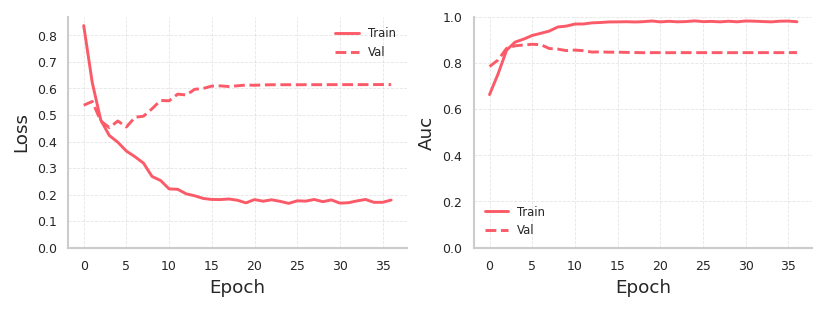

In [46]:
plot_metrics(resampled_history_v0)

##### Model 01

In [ ]:
model_cv1= make_model(units=[128,64], units_tab=[256,64], activation="mish", gn=0.09, do=0.20, output_bias=0, lr=5e-4) # Model v3 (best 0.86323)

resampled_history_v1 = model_cv1.fit(
                              resampled_ds_v1,
                              epochs=201,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3,  factor=0.5, monitor="val_auc", mode="max", min_lr=0.000001, verbose=1),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max", verbose=1)],
                              validation_data=dataset_validation_v1
                              )

model_cv1.evaluate(dataset_validation_v1)

In [ ]:
plot_metrics(resampled_history_v1)

#### Evaluate Model:

In [47]:
train_predictions_resampled_cv0 = model_cv0.predict(dataset_train)
valid_predictions_resampled_cv0 = model_cv0.predict(dataset_validation)
test_predictions_resampled_cv0 = model_cv0.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


In [48]:
df_subm["rainfall"] = test_predictions_resampled_cv0
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_transformer_enhanced_v0_all_data_ext.csv")
df_subm

,rainfall
id,
2190,0.996138
2191,0.994402
2192,0.977331
2193,0.068503
2194,0.034653
...,...
2915,0.995973
2916,0.972898
2917,0.992842


In [ ]:
train_predictions_resampled_cv1 = model_cv1.predict(dataset_train_v1)
valid_predictions_resampled_cv1 = model_cv1.predict(dataset_validation_v1)
test_predictions_resampled_cv1 = model_cv1.predict(dataset_test_v1)

In [ ]:
plt.scatter(test_predictions_resampled_cv0,test_predictions_resampled_cv1)

In [ ]:
plot_cm(y_valid, valid_predictions_resampled_cv0)

In [ ]:
#plot_cm(y_valid_v1, dataset_validation_v1)
test_predictions_resampled_cv0.shape, test_predictions_resampled_cv1.shape

In [ ]:
df_subm["rainfall"] = (test_predictions_resampled_cv0+test_predictions_resampled_cv1)/2
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_enhanced_v0_all_data_ext.csv")
df_subm

### 4.3 CNN Classifier

In [ ]:
%%capture
!pip install sktime

In [ ]:
from sktime.classification.deep_learning.cnn import CNNClassifier

METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(10_000).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())
  print(label.numpy().shape)
  print(features.numpy().shape)

In [ ]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=2000,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
train = np.concatenate((inputs, features), axis=0)
y = np.concatenate((targets, label), axis=0)
train.shape, y.shape

In [ ]:
call_bk = [keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")]

model = GRUFCNNClassifier( hidden_dim=128, gru_layers=2, verbose=True)





#CNNClassifier(n_epochs=8, batch_size=64, kernel_size=3, avg_pool_size=2, n_conv_layers=2, callbacks=call_bk,
#                      verbose=True, loss=keras.losses.BinaryCrossentropy(), metrics=METRICS, random_state=42,
#                      activation='sigmoid', use_bias=True, optimizer=keras.optimizers.Adam(learning_rate=1e-3), filter_sizes=None, padding='auto')

In [ ]:
y_prob_pred = model.fit_predict_proba(train, y, cv=5)

In [ ]:
import tensorflow as tf
from tensorflow import keras

class TimeSeriesPositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='gelu')(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Example Usage
sequence_length = 7 # Example sequence length
embed_dim = 30 # Example embedding dimension.
head_size = 32
num_heads = 4
ff_dim = 128
dropout = 0.1

inputs = keras.layers.Input(shape=(sequence_length, embed_dim))
x = TimeSeriesPositionalEmbedding(sequence_length, embed_dim)(inputs)
x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

model = keras.Model(inputs=inputs, outputs=x)
model.summary()

## Test SKTime:

In [ ]:
%%capture
!pip install sktime

In [ ]:
from sktime.datasets import load_italy_power_demand

In [ ]:
# Increase display width
pd.set_option("display.width", 1000)

## 2.1 Panel data - sktime data formats

Panel is an abstract data type where the values are observed for:

* instance, e.g., patient
* variable, e.g., blood pressure, body temperature of the patient
* time/index, e.g., January 12, 2023 (usually but not necessarily a time index!)
One value X is: "patient 'A' had blood pressure 'X' on January 12, 2023"

Time series classification, regression, clustering: slices Panel data by instance

Preferred format 1: pd.DataFrame with 2-level MultiIndex, (instance, time) and columns: variables

Preferred format 2: 3D np.ndarray with index (instance, variable, time)

* sktime supports and recognizes multiple data formats for convenience and internal use, e.g., dask, xarray
* abstract data type = "scitype"; in-memory specification = "mtype"
* More information in tutorial on in-memory data representations and data loading

## 2.1.1 Preferred format 1 - pd-multiindex specification

pd-multiindex = pd.DataFrame with 2-level MultiIndex, (instance, time) and columns: variables

In [ ]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in pd-multiindex mtype
X, _ = load_italy_power_demand(return_type="pd-multiindex")

# renaming columns for illustrative purposes
X.columns = ["total_power_demand"]
X.index.names = ["day_ID", "hour_of_day"]

The Italy power demand dataset has:

* 1096 individual time series instances = single days of total power demand (mean subtracted)
* one single variable per time series instances, total_power_demand
    * total power demand on that day, in that hourly period
    * Since there's only one column, it is a univariate dataset
* individual time series are observed at 24 time (period) points (the same number for all instances)

In the dataset, days are jumbled and of different scope (independent sampling).

* considered independent - because hour_of_day in one sample doesn't affect hour_of_day in another
* for task, e.g., "identify season or weekday/weekend from pattern"

In [ ]:
X

In [ ]:
from sktime.datasets import load_basic_motions

# load an example time series panel in pd-multiindex mtype
X, _ = load_basic_motions(return_type="pd-multiindex")

# renaming columns for illustrative purposes
X.columns = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]
X.index.names = ["trial_no", "timepoint"]

The basic motions dataset has:

* 80 individual time series instances = trials = person engaging in an activity like running, badminton, etc.
* six variables per time series instance, dim_0 to dim_5 (renamed according to the values they represent)
  * 3 accelerometer and 3 gyrometer measurements
  * hence a multivariate dataset
* individual time series are observed at 100 time points (the same number for all instances)

In [ ]:
# The outermost index represents the instance number
# whereas the inner index represents the index of the particular index
# within that instance.
X

In [ ]:
# Select:
# * the fourth variable (gyroscope 1)
# * of the first instance (trial 1 = 0 in python)
# * values at all 100 timestamps
#
X.loc[0, "gyro_1"]

In [ ]:
X.loc[0, "gyro_1"].plot()

## 2.1.2 preferred format 2 - numpy3D

    numpy3D = 3D np.ndarray with index (instance, variable, time)

instance/time index is interpreted as integer

IMPORTANT: unlike pd-multiindex, this assumes:

* all individual series have the same length

* all individual series have the same index

In [ ]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in numpy mtype
X, _ = load_italy_power_demand(return_type="numpy3D")

In [ ]:
# (num_instances, num_variables, length)
X.shape

In [ ]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")

In [ ]:
# (num_instances, num_variables, length)
X.shape

## 2.2.3 Time Series Classification - deployment vignette
Basic deployment vignette for TSC:

load/setup training data, X in a Panel (more specifically numpy3D) format, y as 1D np.ndarray

load/setup new data for prediction (can be done after 3 too)

specify the classifier using sklearn-like syntax

fit classifier to training data, fit(X, y)

predict labels on new data, predict(X_new)

In [ ]:
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train", return_type="numpy3D")
X_new, _ = load_italy_power_demand(split="test", return_type="numpy3D")

In [ ]:
# this is in numpy3D format, but could also be pd-multiindex or other
X_train.shape, X_new.shape

In [ ]:
# y is a 1D np.ndarray of labels - same length as number of instances in X_train
y_train.shape

In [ ]:
# step 3 - specify the classifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

# example 1 - 3-NN with simple dynamic time warping distance (requires numba)
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3)

# example 2 - custom distance:
# 3-nearest neighbour classifier with Euclidean distance (on flattened time series)
# (requires scipy)
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)

In [ ]:
# all classifiers is scikit-learn / scikit-base compatible!
# nested parameter interface via get_params, set_params
clf.get_params()

In [ ]:
# step 4 - fit/train the classifier
clf.fit(X_train, y_train)

In [ ]:
# the classifier is now fitted
clf.is_fitted

In [ ]:
# and we can inspect fitted parameters if we like
clf.get_fitted_params()

In [ ]:
# step 5 - predict labels on new data
y_pred = clf.predict(X_new)
y_prob = clf.predict_proba(X_new)

In [ ]:
# predictions and unique counts, for illustration
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head

# step 1-- prepare a dataset (multivariate for demonstration)
X_train, y_train = load_arrow_head(split="train", return_type="numpy3D")
X_new, _ = load_arrow_head(split="test", return_type="numpy3D")

In [ ]:
X_train.shape, y_train.shape

In [ ]:
#X_train

In [ ]:
import sktime.classification.deep_learning as dl_clf
from sktime.classification.deep_learning import GRUFCNNClassifier
from sktime.datasets import load_unit_test
X_train, y_train = load_unit_test(split="train", return_type="numpy3D")
X_test, y_test = load_unit_test(split="test", return_type="numpy3D")

In [ ]:
X_train.shape

In [ ]:
cnn = GRUFCNNClassifier( hidden_dim=128, gru_layers=2, verbose=True)
cnn.fit(X_train, y_train)